# **Importing data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install gdown
import gdown


In [ ]:
# Importing Demographic Data

demo_link = 'https://drive.google.com/file/d/1gsOTrMNuXkb87z7P_As8DF3IeVMvyRe3/view'

demo_path = 'https://drive.google.com/uc?export=download&id=' +demo_link.split("/")[-2]

df_demo = pd.read_csv(demo_path)

# Importing Loan Origin Data

loan_origin_link = 'https://drive.google.com/file/d/1bd45Xmbu2uXp9Q5kbYmpXnulOujtP79J/view'

loan_origin_path = 'https://drive.google.com/uc?export=download&id=' +loan_origin_link.split("/")[-2]

df_loan = pd.read_csv(loan_origin_path)

# Importing final Dataset
repay_link = 'https://drive.google.com/file/d/1dhyyDH9c8YNBeH0Q2q5ROZZUKgoDw0nF/view?usp=sharing'

file_id = repay_link.split("/")[-2]

!gdown "https://drive.google.com/uc?export=download&id={file_id}" -O final.csv

df_repayment = pd.read_csv("final.csv")



Downloading...
From (original): https://drive.google.com/uc?export=download&id=1dhyyDH9c8YNBeH0Q2q5ROZZUKgoDw0nF
From (redirected): https://drive.google.com/uc?export=download&id=1dhyyDH9c8YNBeH0Q2q5ROZZUKgoDw0nF&confirm=t&uuid=83767628-81f1-45e1-9aa7-71c083b6c1e0
To: /content/final.csv
100% 249M/249M [00:01<00:00, 132MB/s]


# **I. Data Preparation**

## **1. Merge 3 tables**

Note: Because 3 tables have same columns CONTRACT NO which can consider as be primary key, we merge 3 tables for data preparation

### Delete the null in Primary Key in 2 tables




In [ ]:
#delete primary key's null of demo
df_demo = df_demo[df_demo['CONTRACT_NO'].notnull()]

# Check result
print("Total rows after deleting primary key's null of demo:", len(df_demo))

Total rows after deleting primary key's null of demo: 315507


In [ ]:
# Delete primary key's null of loan
df_loan = df_loan[df_loan['CONTRACT_NO'].notnull()]

# Check result
print("Total rows after deleting primary key's null of loan:", len(df_loan))

Total rows after deleting primary key's null of loan: 315643




### We merge 3 tables on CONTRACT_NO

In [ ]:
df_merged = df_demo.merge(df_loan, how='left', on='CONTRACT_NO')

In [ ]:
df_final = df_repayment.merge(df_merged, how = 'inner', on = 'CONTRACT_NO')

In [ ]:
df_merged.shape

(315507, 30)

In [ ]:
df_final['CONTRACT_NO'].value_counts(dropna=False)

CONTRACT_NO
765326    13
345333    13
357251    13
778163    13
434442    13
          ..
467329    13
467370    13
786262    13
466945    13
779252    13
Name: count, Length: 101043, dtype: int64

In [ ]:
duplicates_count = df_final.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")


Number of duplicate rows: 0


In [ ]:
df_final['CONTRACT_NO'].value_counts(dropna=False)

CONTRACT_NO
765326    13
345333    13
357251    13
778163    13
434442    13
          ..
467329    13
467370    13
786262    13
466945    13
779252    13
Name: count, Length: 101043, dtype: int64

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313559 entries, 0 to 1313558
Data columns (total 46 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CONTRACT_NO                 1313559 non-null  int64  
 1   SYS_RUN_DATE                1313559 non-null  object 
 2   TOTAL_EMI_AMOUNT            1312101 non-null  float64
 3   DUE_DATE_OF_MON             1110520 non-null  object 
 4   PARTNER_CODE                1313559 non-null  int64  
 5   OUTSTANDING                 1313559 non-null  float64
 6   PRI_PAST_DUE                1313559 non-null  float64
 7   INT_PAST_DUE                1313559 non-null  float64
 8   OD_PAST_DUE                 1313559 non-null  float64
 9   OVER_DUE_DAYS_LD            1313559 non-null  float64
 10  OVER_DUE_DAYS_CLIENT        1313559 non-null  float64
 11  LAST_PAYMENT_DATE           1193508 non-null  object 
 12  LAST_PAYMENT_AMOUNT         1193472 non-null  float64
 1

In [ ]:
df_final.shape

(1313559, 46)

##**2. Fix type and format of columns**

###Extract the month and year from DISBURSEMENT_DATE to 2 columns and change types of them to 'float'

In [ ]:
df_final['DISBURSEMENT_DATE'] = pd.to_datetime(df_final['DISBURSEMENT_DATE'], errors='coerce')

# Step 2: Extract the month and year
df_final['month'] = df_final['DISBURSEMENT_DATE'].dt.month.astype(float)  # Extract month and convert to float
df_final['year'] = df_final['DISBURSEMENT_DATE'].dt.year.astype(float)    # Extract year and convert to float



###Change the encode of HAS_INSURANCE: YES to 1, NO to 0

In [ ]:
# Step 1: Replace 'yes' with 1 and 'no' with 0 in the 'HAS_INSURANCE' column
df_final['HAS_INSURANCE'] = df_final['HAS_INSURANCE'].replace({'YES': 1, 'NO': 0})

# Step 2: Convert the 'HAS_INSURANCE' column to float
df_final['HAS_INSURANCE'] = df_final['HAS_INSURANCE'].astype(float)


<ipython-input-14-6ca4ab92c07d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['HAS_INSURANCE'] = df_final['HAS_INSURANCE'].replace({'YES': 1, 'NO': 0})


## **3. Fix NULL of dataset**

Note:
- We use economic and business understanding to fill as much null as we can
- Most of solution is based on using the mode value in each corresponding category
- With null in the columns we have no clue to fill, we use ffill to maintain the Data integrity

### 3.1 Check Correlations of columns in DATESET

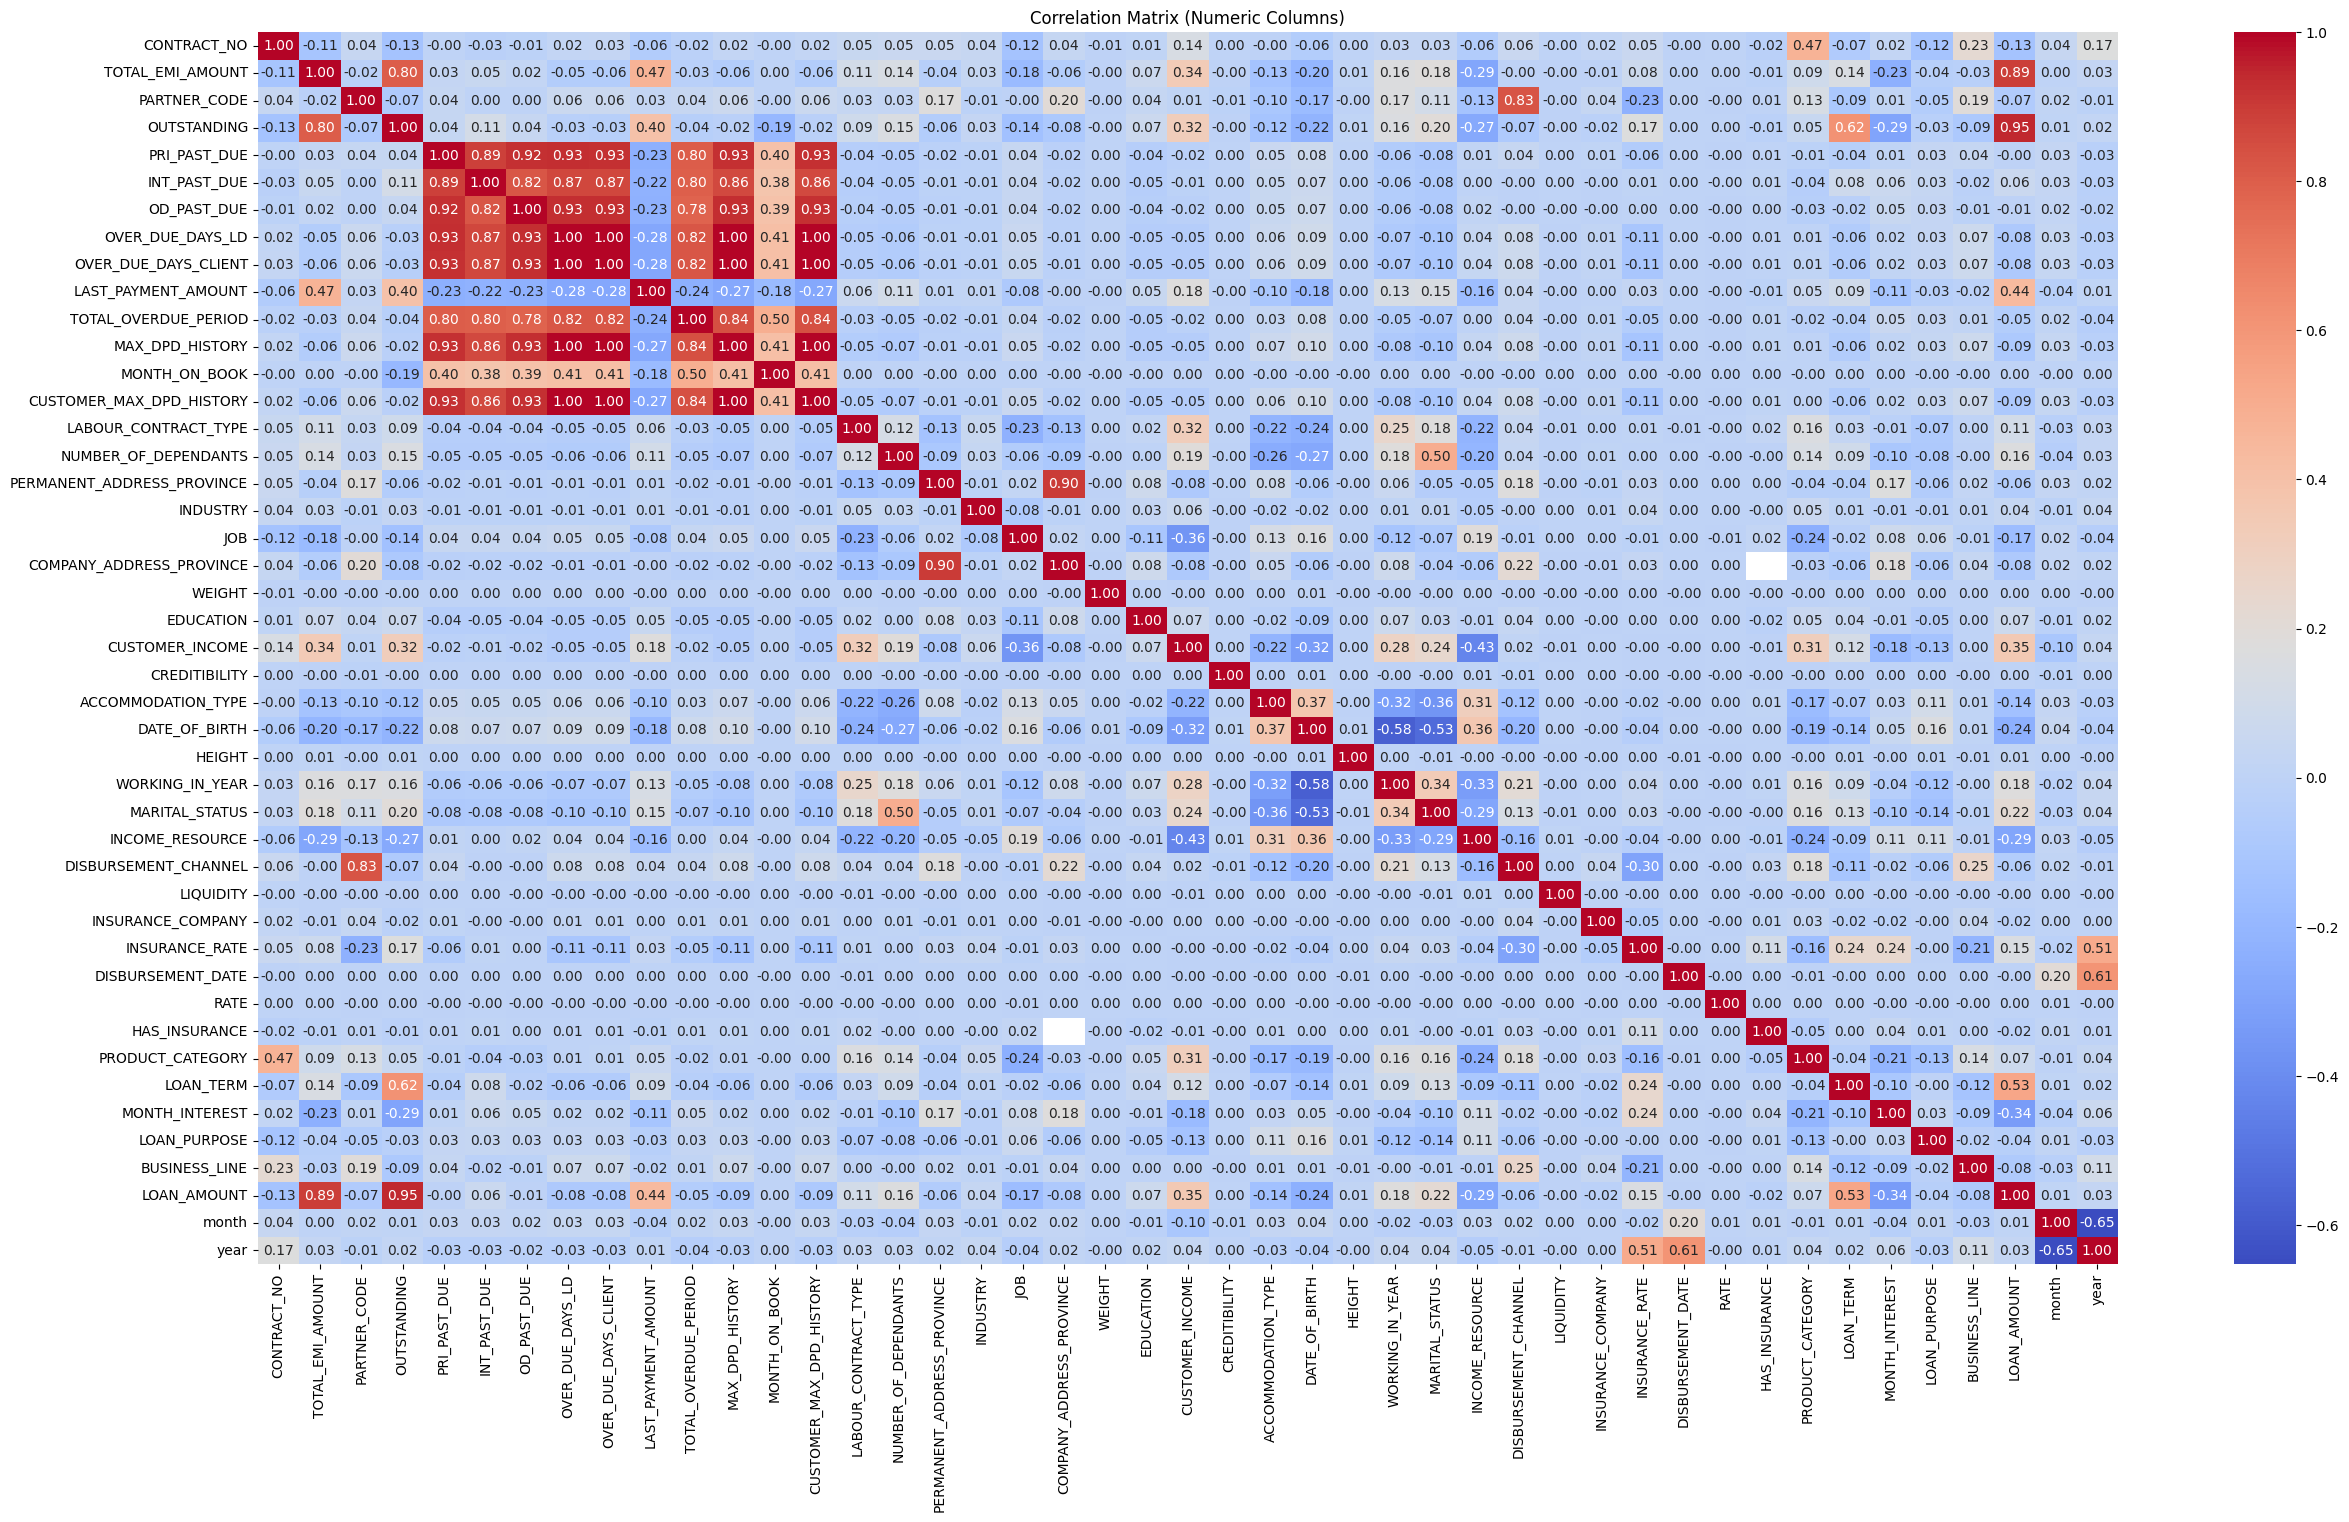

In [ ]:
# Select columns that are not of type 'object'
numeric_columns = df_final.select_dtypes(exclude=['object'])

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(30, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (Numeric Columns)")
plt.show()

###3.2 Geographic Information

####PERMANENT_ADDRESS_PROVINCE & COMPANY_ADDRESS_PROVINCE


Note:
- High correlation: 0.86
- People might choose to work in near of their house
- However, there might be some place that does not have company near that

▶ Solution: Fill the null by the mode value of company address in each permanent address and reverse

In [ ]:
# Check the most common "COMPANY_ADDRESS_PROVINCE" for each "PERMANENT_ADDRESS_PROVINCE" to identify patterns
province_pattern = df_final.groupby("PERMANENT_ADDRESS_PROVINCE")["COMPANY_ADDRESS_PROVINCE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
province_pattern.head()


PERMANENT_ADDRESS_PROVINCE
1.0     1.0
2.0    27.0
4.0    27.0
6.0    27.0
8.0    26.0
Name: COMPANY_ADDRESS_PROVINCE, dtype: float64

In [ ]:
# Fill missing values in "COMPANY_ADDRESS_PROVINCE" based on the patterns identified with "PERMANENT_ADDRESS_PROVINCE"
print('Before fill', df_final['COMPANY_ADDRESS_PROVINCE'].isnull().sum())
df_final['COMPANY_ADDRESS_PROVINCE'] = df_final.apply(lambda row: province_pattern[row['PERMANENT_ADDRESS_PROVINCE']]
                                              if pd.isnull(row['COMPANY_ADDRESS_PROVINCE']) and row['PERMANENT_ADDRESS_PROVINCE'] in province_pattern
                                              else row['COMPANY_ADDRESS_PROVINCE'], axis=1)
print('After fill', df_final['COMPANY_ADDRESS_PROVINCE'].isnull().sum())

Before fill 404352
After fill 61529


In [ ]:
# Check the most common "PERMANENT_ADDRESS_PROVINCE" for each "COMPANY_ADDRESS_PROVINCE" to identify patterns
province_pattern = df_final.groupby("COMPANY_ADDRESS_PROVINCE")["PERMANENT_ADDRESS_PROVINCE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
province_pattern.head()

COMPANY_ADDRESS_PROVINCE
1.0      1.0
4.0     19.0
6.0     19.0
10.0    25.0
14.0    34.0
Name: PERMANENT_ADDRESS_PROVINCE, dtype: float64

In [ ]:
# Fill missing values in "PERMANENT_ADDRESS_PROVINCE based on the patterns identified with ""COMPANY_ADDRESS_PROVINCE"
print('Before fill', df_final['PERMANENT_ADDRESS_PROVINCE'].isnull().sum())
df_final['PERMANENT_ADDRESS_PROVINCE'] = df_final.apply(lambda row: province_pattern[row['COMPANY_ADDRESS_PROVINCE']]
                                              if pd.isnull(row['PERMANENT_ADDRESS_PROVINCE']) and row['COMPANY_ADDRESS_PROVINCE'] in province_pattern
                                              else row['PERMANENT_ADDRESS_PROVINCE'], axis=1)
print('After fill', df_final['PERMANENT_ADDRESS_PROVINCE'].isnull().sum())

Before fill 198042
After fill 61542


####DISBURSEMENT_CHANNEL & COMPANY_ADDRESS_PROVINCE


Note:
- Certain channels may be predominant in specific places
- Company might choose the channel that near their place or they have known before
> Solution: Fill the null by the mode value of DISBURSEMENT_CHANNEL in each COMPANY ADDRESS

In [ ]:
# Check the most common "DISBURSEMENT_CHANNEL" for each "COMPANY_ADDRESS_PROVINCE" to identify patterns
province_pattern = df_final.groupby("COMPANY_ADDRESS_PROVINCE")["DISBURSEMENT_CHANNEL"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
province_pattern.head()


COMPANY_ADDRESS_PROVINCE
1.0     1.0
4.0     1.0
6.0     1.0
10.0    1.0
14.0    1.0
Name: DISBURSEMENT_CHANNEL, dtype: float64

In [ ]:
# Fill missing values in "DISBURSEMENT_CHANNEL based on the patterns identified with ""COMPANY_ADDRESS_PROVINCE"
print('Before fill', df_final['DISBURSEMENT_CHANNEL'].isnull().sum())
df_final['DISBURSEMENT_CHANNEL'] = df_final.apply(lambda row: province_pattern[row['COMPANY_ADDRESS_PROVINCE']]
                                              if pd.isnull(row['DISBURSEMENT_CHANNEL']) and row['COMPANY_ADDRESS_PROVINCE'] in province_pattern
                                              else row['DISBURSEMENT_CHANNEL'], axis=1)
print('After fill', df_final['DISBURSEMENT_CHANNEL'].isnull().sum())

Before fill 365313
After fill 17160


In [ ]:
df_final.isnull().sum().sort_values(ascending=False)

MONTH_INTEREST                366561
INSURANCE_COMPANY             366184
BUSINESS_LINE                 366054
LOAN_TERM                     366054
PRODUCT_CATEGORY              365339
HAS_INSURANCE                 365300
year                          364871
month                         364871
DISBURSEMENT_DATE             364871
LIQUIDITY                     364442
INSURANCE_RATE                363766
LOAN_AMOUNT                   363116
LOAN_PURPOSE                  362739
RATE                          362180
LABOUR_CONTRACT_TYPE          259766
WORKING_IN_YEAR               218959
NUMBER_OF_DEPENDANTS          206986
ACCOMMODATION_TYPE            205491
MARITAL_STATUS                204932
INDUSTRY                      204425
INCOME_RESOURCE               203684
DUE_DATE_OF_MON               203039
EDUCATION                     202631
HEIGHT                        200161
DATE_OF_BIRTH                 197171
CREDITIBILITY                 196976
CUSTOMER_INCOME               196456
WEIGHT                        196365
JOB                           195793
LAST_PAYMENT_AMOUNT           120087
LAST_PAYMENT_DATE             120051
TOTAL_OVERDUE_PERIOD          101043
MAX_DPD_HISTORY               101043
CUSTOMER_MAX_DPD_HISTORY       89430
PERMANENT_ADDRESS_PROVINCE     61542
COMPANY_ADDRESS_PROVINCE       61529
DISBURSEMENT_CHANNEL           17160
TOTAL_EMI_AMOUNT                1458
MONTH_ON_BOOK                      0
SYS_RUN_DATE                       0
OVER_DUE_DAYS_CLIENT               0
OVER_DUE_DAYS_LD                   0
OD_PAST_DUE                        0
INT_PAST_DUE                       0
PRI_PAST_DUE                       0
OUTSTANDING                        0
PARTNER_CODE                       0
CONTRACT_NO                        0
dtype: int64

###3.3 Demographic Information

####DATE_OF_BIRTH and MARITAL_STATUS

Note:
- Older individuals are more likely to be married.
- DATE_OF_BIRTH can be used to infer the probability of being married based on typical age ranges.
>Solution: Fill nulls in MARITAL_STATUS based on the majority marital status in those age groups.

In [ ]:
# Check the most common "MARITAL_STATUS" for each "DATE_OF_BIRTH" to identify patterns
birth_pattern = df_final.groupby("DATE_OF_BIRTH")["MARITAL_STATUS"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
birth_pattern

DATE_OF_BIRTH
1962.0    2.0
1963.0    2.0
1964.0    2.0
1965.0    2.0
1966.0    2.0
1967.0    2.0
1968.0    2.0
1969.0    2.0
1970.0    2.0
1971.0    2.0
1972.0    2.0
1973.0    2.0
1974.0    2.0
1975.0    2.0
1976.0    2.0
1977.0    2.0
1978.0    2.0
1979.0    2.0
1980.0    2.0
1981.0    2.0
1982.0    2.0
1983.0    2.0
1984.0    2.0
1985.0    2.0
1986.0    2.0
1987.0    2.0
1988.0    2.0
1989.0    2.0
1990.0    2.0
1991.0    2.0
1992.0    2.0
1993.0    0.0
1994.0    0.0
1995.0    0.0
1996.0    0.0
1997.0    0.0
1998.0    0.0
1999.0    0.0
2000.0    0.0
2001.0    0.0
2002.0    0.0
2003.0    0.0
Name: MARITAL_STATUS, dtype: float64

In [ ]:
# Fill missing values in "MARITAL_STATUS based on the patterns identified with ""DATE_OF_BIRTH"
print('Before fill', df_final['MARITAL_STATUS'].isnull().sum())
df_final['MARITAL_STATUS'] = df_final.apply(lambda row: birth_pattern[row['DATE_OF_BIRTH']]
                                              if pd.isnull(row['MARITAL_STATUS']) and row['DATE_OF_BIRTH'] in birth_pattern
                                              else row['MARITAL_STATUS'], axis=1)
print('After fill', df_final['MARITAL_STATUS'].isnull().sum())

Before fill 204932
After fill 29536


####EDUCATION and JOB

Note:
- Higher education levels generally correlate with certain job types
>Use the JOB column to predict EDUCATION level through a frequency-based imputation

In [ ]:
# Check the most common "EDUCATION" for each "JOB" to identify patterns
Job_pattern = df_final.groupby("JOB")["EDUCATION"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Job_pattern

JOB
0.0    1.0
1.0    1.0
2.0    1.0
3.0    NaN
4.0    1.0
5.0    0.0
6.0    1.0
7.0    6.0
8.0    1.0
9.0    1.0
Name: EDUCATION, dtype: float64

In [ ]:
# Fill missing values in "EDUCATION based on the patterns identified with ""JOB"
print('Before fill', df_final['EDUCATION'].isnull().sum())
df_final['EDUCATION'] = df_final.apply(lambda row: Job_pattern[row['JOB']]
                                              if pd.isnull(row['EDUCATION']) and row['JOB'] in Job_pattern
                                              else row['EDUCATION'], axis=1)
print('After fill', df_final['EDUCATION'].isnull().sum())

Before fill 202631
After fill 30472


####NUMBER_OF_DEPENDANTS and MARITAL_STATUS

Note:
- Correlation: 0.48
- Married individuals tend to have dependants more often than single individuals.
>Solution: Impute NUMBER_OF_DEPENDANTS by information from MARITAL STATUS

In [ ]:
#Check the information of NUMBER OF DEPENDANTS based on MARITAL STATUS
marital_counts_matrix = df_final.pivot_table(
    index='MARITAL_STATUS',
    columns='NUMBER_OF_DEPENDANTS',
    aggfunc='size',
    fill_value=0
)

#Show result
marital_counts_matrix

NUMBER_OF_DEPENDANTS    0.0     1.0     2.0    3.0   4.0   5.0   6.0   10.0  \
MARITAL_STATUS                                                                
0.0                   399451   10855    3952    442    65    26     0    13   
1.0                    43849   28132   11973   1391   143    39     0     0   
2.0                   195078  163553  147680  33956  4693   559    26     0   
3.0                    11427    6968    4056    741    13     0     0     0   
4.0                     8177    2782    1846    260    52    26     0     0   

NUMBER_OF_DEPENDANTS  20.0  
MARITAL_STATUS              
0.0                      0  
1.0                      0  
2.0                     13  
3.0                      0  
4.0                      0

82765 People with status 0.0 have number_of_dependants equal to 0 => Fill all rows with nod null and ms = 0 to 0

In [ ]:
#Fill null in NUMBER_OF_DEPENDANTS to 0 of people with status 0.0
print('Before fix: ', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum() )
df_final.loc[(df_final['MARITAL_STATUS'] == 0) & (df_final['NUMBER_OF_DEPENDANTS'].isnull()), 'NUMBER_OF_DEPENDANTS'] = 0
print('After fix: ', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum() )

Before fix:  206986
After fix:  129233



Nearly 100% of people with status 1.0,  3.0, 4.0 have mode number of dependants is 0 => fill these status with 0. The number of dependants in marital status = 2.0 mostly on 0-2, however we dont have evidence to fill this status

In [ ]:
# Print the number of nulls before filling
print('Before fill:', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum())

# Fill nulls with 0 where the marital status is 1, 3, or 4
df_final.loc[df_final['MARITAL_STATUS'].isin([1, 3, 4]) & df_final['NUMBER_OF_DEPENDANTS'].isnull(), 'NUMBER_OF_DEPENDANTS'] = 0

# Print the number of nulls after filling
print('After fill:', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum())

Before fill: 129233
After fill: 107744


#### Number of Depedants from Date of birth, marital status and customer income


Note:
- We have already known most of number of dependants in data set is zero in every type of marital status
- People with low age might have less number of dependants
- Customer income might affect the number of dependants

In [ ]:
Birth_pattern = df_final.groupby("DATE_OF_BIRTH")["NUMBER_OF_DEPENDANTS"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Birth_pattern

DATE_OF_BIRTH
1962.0    0.0
1963.0    0.0
1964.0    0.0
1965.0    0.0
1966.0    0.0
1967.0    0.0
1968.0    0.0
1969.0    0.0
1970.0    0.0
1971.0    0.0
1972.0    0.0
1973.0    0.0
1974.0    0.0
1975.0    0.0
1976.0    0.0
1977.0    0.0
1978.0    0.0
1979.0    0.0
1980.0    0.0
1981.0    0.0
1982.0    0.0
1983.0    0.0
1984.0    0.0
1985.0    0.0
1986.0    0.0
1987.0    0.0
1988.0    0.0
1989.0    0.0
1990.0    0.0
1991.0    0.0
1992.0    0.0
1993.0    0.0
1994.0    0.0
1995.0    0.0
1996.0    0.0
1997.0    0.0
1998.0    0.0
1999.0    0.0
2000.0    0.0
2001.0    0.0
2002.0    0.0
2003.0    0.0
Name: NUMBER_OF_DEPENDANTS, dtype: float64

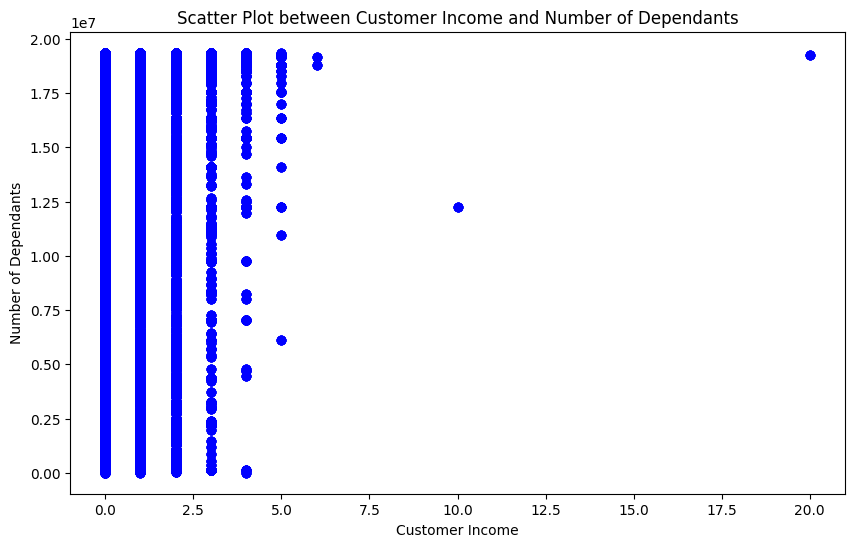

In [ ]:
# Drop rows with nulls in CUSTOMER_INCOME or NUMBER_OF_DEPENDANTS for visualization purposes
df_cleaned = df_final.dropna(subset=['CUSTOMER_INCOME', 'NUMBER_OF_DEPENDANTS'])

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y = df_cleaned['CUSTOMER_INCOME'],x = df_cleaned['NUMBER_OF_DEPENDANTS'], alpha=0.5, color='blue')

# Set plot title and labels
plt.title('Scatter Plot between Customer Income and Number of Dependants')
plt.xlabel('Customer Income')
plt.ylabel('Number of Dependants')

# Display the plot
plt.show()

So now we know in every category 0 still be the mode of number of dependants
>Solution: Fill null of number of dependants with 0

In [ ]:
# Điền giá trị 0 vào các ô null trong cột NUMBER_OF_DEPENDANTS
df_final['NUMBER_OF_DEPENDANTS'].fillna(0, inplace=True)

# Kiểm tra lại số lượng null sau khi điền
print('After fill:', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum())


After fill: 0


<ipython-input-32-a5da09f42dac>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['NUMBER_OF_DEPENDANTS'].fillna(0, inplace=True)


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313559 entries, 0 to 1313558
Data columns (total 48 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   CONTRACT_NO                 1313559 non-null  int64         
 1   SYS_RUN_DATE                1313559 non-null  object        
 2   TOTAL_EMI_AMOUNT            1312101 non-null  float64       
 3   DUE_DATE_OF_MON             1110520 non-null  object        
 4   PARTNER_CODE                1313559 non-null  int64         
 5   OUTSTANDING                 1313559 non-null  float64       
 6   PRI_PAST_DUE                1313559 non-null  float64       
 7   INT_PAST_DUE                1313559 non-null  float64       
 8   OD_PAST_DUE                 1313559 non-null  float64       
 9   OVER_DUE_DAYS_LD            1313559 non-null  float64       
 10  OVER_DUE_DAYS_CLIENT        1313559 non-null  float64       
 11  LAST_PAYMENT_DATE       

###3.4 Loan and Financial Information

####CUSTOMER INCOME

Note:
We believe the factor affect customer income includes "INCOME_RESOURCE", "JOB" and "ACCOMMODATION_TYPE" with INCOME_RESOURCE > JOB > ACCOMMODATION_TYPE.
>So we decide to fill null in CUSTOMER_INCOME by information from 3 category
and sort by influent extent

In [ ]:
income_pattern = df_final.groupby("INCOME_RESOURCE")["CUSTOMER_INCOME"].agg(lambda x: x.mean() if not x.empty else None)
income_pattern
print('Before fill', df_final['CUSTOMER_INCOME'].isnull().sum())
df_final['CUSTOMER_INCOME'] = df_final.apply(lambda row: income_pattern[row['INCOME_RESOURCE']]
                                              if pd.isnull(row['CUSTOMER_INCOME']) and row['INCOME_RESOURCE'] in income_pattern
                                              else row['CUSTOMER_INCOME'], axis=1)
print('After fill', df_final['CUSTOMER_INCOME'].isnull().sum())

Before fill 196456
After fill 29666


In [ ]:
income_pattern = df_final.groupby("JOB")["CUSTOMER_INCOME"].agg(lambda x: x.mean() if not x.empty else None)
income_pattern
print('Before fill', df_final['CUSTOMER_INCOME'].isnull().sum())
df_final['CUSTOMER_INCOME'] = df_final.apply(lambda row: income_pattern[row['JOB']]
                                              if pd.isnull(row['CUSTOMER_INCOME']) and row['JOB'] in income_pattern
                                              else row['CUSTOMER_INCOME'], axis=1)
print('After fill', df_final['CUSTOMER_INCOME'].isnull().sum())

Before fill 29666
After fill 4550


In [ ]:
income_pattern = df_final.groupby("ACCOMMODATION_TYPE")["CUSTOMER_INCOME"].agg(lambda x: x.mean() if not x.empty else None)
income_pattern
print('Before fill', df_final['CUSTOMER_INCOME'].isnull().sum())
df_final['CUSTOMER_INCOME'] = df_final.apply(lambda row: income_pattern[row['ACCOMMODATION_TYPE']]
                                              if pd.isnull(row['CUSTOMER_INCOME']) and row['ACCOMMODATION_TYPE'] in income_pattern
                                              else row['CUSTOMER_INCOME'], axis=1)
print('After fill', df_final['CUSTOMER_INCOME'].isnull().sum())

Before fill 4550
After fill 780


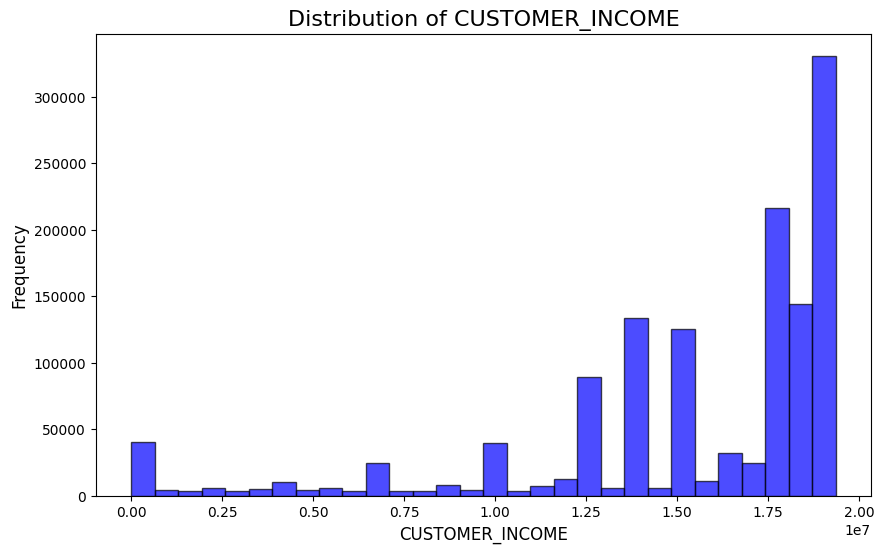

In [ ]:
#Draw the customer income distribution
plt.figure(figsize=(10, 6))

# Draw the histogram
plt.hist(df_final['CUSTOMER_INCOME'], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of CUSTOMER_INCOME', fontsize=16)
plt.xlabel('CUSTOMER_INCOME', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()


In [ ]:
df = df_final.copy()

In [ ]:
df_final = df.copy()

####LOAN_AMOUNT

Note:
* Customer income might decide the loan_amount because
  * Lenders assess a customer's income to evaluate their capacity to repay the loan
  * Debt-to-Income Ratio (DTI)
* Loan Purpose will also affect the loan_amount, for instance, the house loan might be higher than a car loan
* Loan Term is also a factor help determined the loan amount, higher loan term might go with higher loan amount. However the effect of this can not be equal with 2 above factors

In [ ]:
print('Before Fill: ', df_final['LOAN_AMOUNT'].isnull().sum())
# Divide the LOAN_AMOUNT column into 12 equal intervals and create a new column
df_final['CUSTOMER_INCOME_BIN'] = pd.qcut(df_final['CUSTOMER_INCOME'], q=12, labels=False, duplicates='drop')

# # Grouping to see the most common "CUSTOMER_INCOME" values within each "LOAN_AMOUNT" category
LOAN_AMOUNT_pattern = df_final.groupby("CUSTOMER_INCOME")["LOAN_AMOUNT"].agg(lambda x: x.mean() if not x.empty else None)
LOAN_AMOUNT_pattern
# Fill missing values in "CUSTOMER_INCOME" based on the patterns identified with "LOAN_AMOUNT"
df_final['LOAN_AMOUNT'] = df_final.apply(lambda row: LOAN_AMOUNT_pattern[row['CUSTOMER_INCOME']]
                                         if pd.isnull(row['LOAN_AMOUNT']) and row['CUSTOMER_INCOME'] in LOAN_AMOUNT_pattern
                                         else row['LOAN_AMOUNT'], axis=1)
print('After Fill: ', df_final['LOAN_AMOUNT'].isnull().sum())

Before Fill:  363116
After Fill:  22308


In [ ]:
income_pattern = df_final.groupby("LOAN_PURPOSE")["LOAN_AMOUNT"].agg(lambda x: x.mode() if not x.empty else None)
income_pattern
print('Before fill', df_final['LOAN_AMOUNT'].isnull().sum())
df_final['LOAN_AMOUNT'] = df_final.apply(lambda row: income_pattern[row['LOAN_PURPOSE']]
                                              if pd.isnull(row['LOAN_AMOUNT']) and row['LOAN_PURPOSE'] in income_pattern
                                              else row['LOAN_AMOUNT'], axis=1)
print('After fill', df_final['LOAN_AMOUNT'].isnull().sum())

Before fill 22308
After fill 13871


In [ ]:
income_pattern = df_final.groupby("LOAN_TERM")["LOAN_AMOUNT"].agg(lambda x: x.mode() if not x.empty else None)
income_pattern
print('Before fill', df_final['LOAN_AMOUNT'].isnull().sum())
df_final['LOAN_AMOUNT'] = df_final.apply(lambda row: income_pattern[row['LOAN_TERM']]
                                              if pd.isnull(row['LOAN_AMOUNT']) and row['LOAN_TERM'] in income_pattern
                                              else row['LOAN_AMOUNT'], axis=1)
print('After fill', df_final['LOAN_AMOUNT'].isnull().sum())

Before fill 13871
After fill 12753


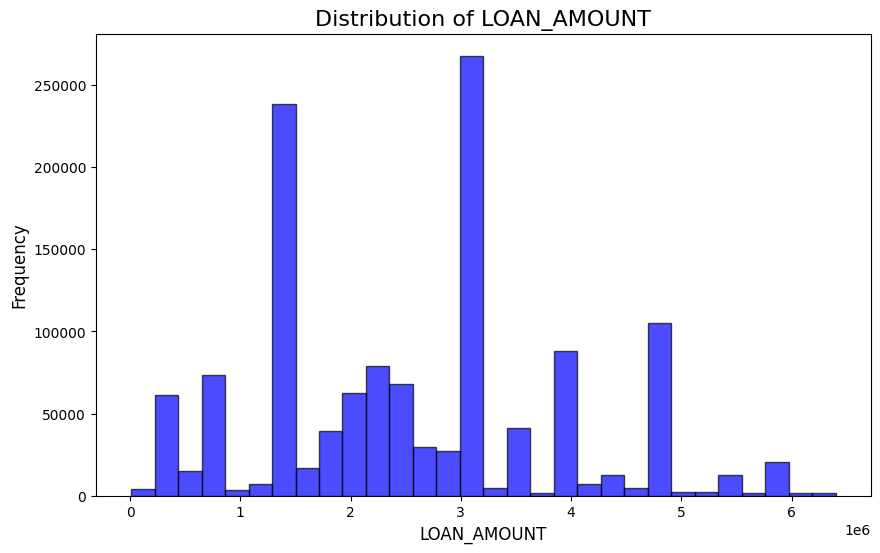

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_final['LOAN_AMOUNT'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of LOAN_AMOUNT', fontsize=16)
plt.xlabel('LOAN_AMOUNT', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

####Loan Amount and Loan Term

Note:
- Correlation 0,62
- Large loan amount might go with long term loan
> Solution: Use loan amount to predict long term information

In [ ]:
print('Before Fill: ', df_final['LOAN_TERM'].isnull().sum())
# Divide the LOAN_AMOUNT column into 12 equal intervals and create a new column
df_final['LOAN_AMOUNT_BIN'] = pd.qcut(df_final['LOAN_AMOUNT'], q=12, labels=False, duplicates="drop")

# Grouping to see the most common "LOAN_AMOUNT_BIN" values within each "LOAN_TERM" category
Loan_Term_pattern = df_final.groupby("LOAN_AMOUNT_BIN")["LOAN_TERM"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern
# Fill missing values in "LOAN_AMOUNT_BIN" based on the patterns identified with "LOAN_TERM"
df_final['LOAN_TERM'] = df_final.apply(lambda row: Loan_Term_pattern[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['LOAN_TERM']) and row['LOAN_AMOUNT_BIN'] in Loan_Term_pattern
                                         else row['LOAN_TERM'], axis=1)
print('After Fill: ', df_final['LOAN_TERM'].isnull().sum())

Before Fill:  366054
After Fill:  12753


####LOAN_TERM & MONTH_INTEREST

Note:
- Loan term will affect the month_interest, with longer term, interest will be higer
> FIll null of long_term by month_interest

In [ ]:
print('Before Fill: ', df_final['LOAN_TERM'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("MONTH_INTEREST")["LOAN_TERM"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['LOAN_TERM'] = df_final.apply(lambda row: Loan_Term_pattern1[row['MONTH_INTEREST']]
                                         if pd.isnull(row['LOAN_TERM']) and row['MONTH_INTEREST'] in Loan_Term_pattern1
                                         else row['LOAN_TERM'], axis=1)
print('After Fill: ', df_final['LOAN_TERM'].isnull().sum())

Before Fill:  12753
After Fill:  12519


####LOAN_AMOUNT AND LOAN_PURPOSE

*Note
- As loan purpose is one of the factor to decide loan amount, we can predict the null of loan purpose by using loan amount

In [ ]:
print('Before Fill: ', df_final['LOAN_PURPOSE'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("LOAN_AMOUNT_BIN")["LOAN_PURPOSE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['LOAN_PURPOSE'] = df_final.apply(lambda row: Loan_Term_pattern1[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['LOAN_PURPOSE']) and row['LOAN_AMOUNT_BIN'] in Loan_Term_pattern1
                                         else row['LOAN_PURPOSE'], axis=1)
print('After Fill: ', df_final['LOAN_PURPOSE'].isnull().sum())

Before Fill:  362739
After Fill:  12753


####LOAN_AMOUNT and PRODUCT_CATEGORY

Note:
- Certain products are tied to specific loan amount
>If PRODUCT_CATEGORY is missing, impute based on the common combinations observed for each Loan_amount. Conversely, use PRODUCT_CATEGORY to predict missing LOAN_AMOUNT.

In [ ]:
print('Before Fill: ', df_final['PRODUCT_CATEGORY'].isnull().sum())
# Divide the LOAN_AMOUNT column into 12 equal intervals and create a new column
df_final['LOAN_AMOUNT_BIN'] = pd.qcut(df_final['LOAN_AMOUNT'], q=12, labels=False, duplicates="drop")

# Grouping to see the most common "PRODUCT_CATEGORY" values within each "LOAN_AMOUNT" category
LOAN_AMOUNT_pattern = df_final.groupby("LOAN_AMOUNT_BIN")["PRODUCT_CATEGORY"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
LOAN_AMOUNT_pattern
# Fill missing values in "PRODUCT_CATEGORY" based on the patterns identified with "LOAN_AMOUNT"
df_final['PRODUCT_CATEGORY'] = df_final.apply(lambda row: LOAN_AMOUNT_pattern[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['PRODUCT_CATEGORY']) and row['LOAN_AMOUNT_BIN'] in LOAN_AMOUNT_pattern
                                         else row['PRODUCT_CATEGORY'], axis=1)
print('After Fill: ', df_final['PRODUCT_CATEGORY'].isnull().sum())

Before Fill:  365339
After Fill:  12558


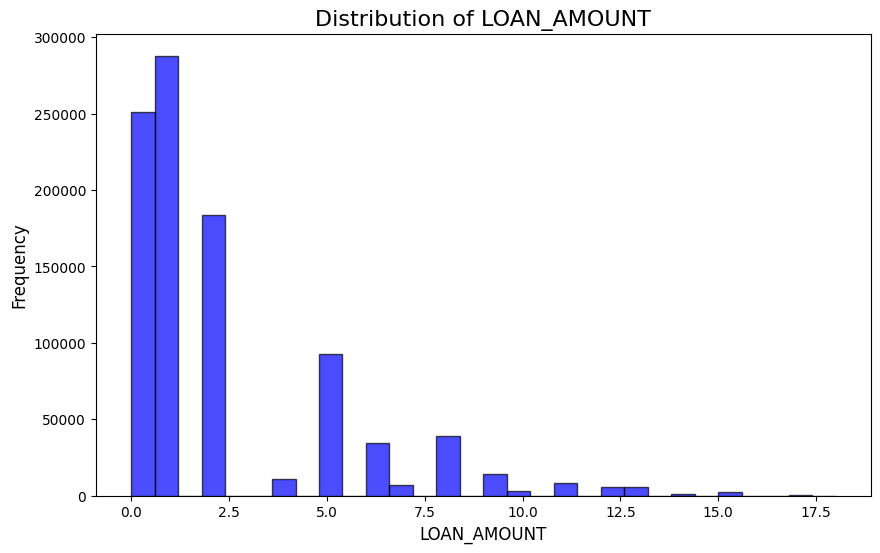

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(df['PRODUCT_CATEGORY'], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of LOAN_AMOUNT', fontsize=16)
plt.xlabel('LOAN_AMOUNT', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

####CUSTOMER_INCOME & INCOME_RESOUCES

Note:
- As INCOME_RESOURCES is one of the factor to determine customer_income, we can use customer income to predict income_resource

In [ ]:
# Print the count of null values before filling
print('Before Fill: ', df_final['INCOME_RESOURCE'].isnull().sum())

# Create bins for CUSTOMER_INCOME
df_final['CUSTOMER_INCOME_BIN'] = pd.qcut(df['CUSTOMER_INCOME'], q=12, labels=False, duplicates='drop')

# Grouping to find the most common INCOME_RESOURCE value for each CUSTOMER_INCOME group
LOAN_AMOUNT_pattern = df_final.groupby("CUSTOMER_INCOME")["INCOME_RESOURCE"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Apply the pattern to fill missing values in "INCOME_RESOURCE"
df_final['INCOME_RESOURCE'] = df_final.apply(
    lambda row: LOAN_AMOUNT_pattern[row['CUSTOMER_INCOME']]
    if pd.isnull(row['INCOME_RESOURCE']) and row['CUSTOMER_INCOME'] in LOAN_AMOUNT_pattern
    else row['INCOME_RESOURCE'],
    axis=1
)

# Print the count of null values after filling
print('After Fill: ', df_final['INCOME_RESOURCE'].isnull().sum())


Before Fill:  203684
After Fill:  42146


####ACCOMODATION_TYPE and CUSTOMER INCOME

Note:
- People with higher income might live in different accommodation type with lower one

In [ ]:
# Print the count of null values before filling
print('Before Fill: ', df_final['ACCOMMODATION_TYPE'].isnull().sum())

# Create bins for CUSTOMER_INCOME
df_final['CUSTOMER_INCOME_BIN'] = pd.qcut(df_final['CUSTOMER_INCOME'], q=12, labels=False, duplicates='drop')

# Grouping to find the most common JOB value for each CUSTOMER_INCOME group
JOB_pattern = df_final.groupby("CUSTOMER_INCOME")["ACCOMMODATION_TYPE"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Apply the pattern to fill missing values in "JOB"
df_final['ACCOMMODATION_TYPE'] = df_final.apply(
    lambda row: JOB_pattern[row['CUSTOMER_INCOME']]
    if pd.isnull(row['ACCOMMODATION_TYPE']) and row['CUSTOMER_INCOME'] in JOB_pattern
    else row['ACCOMMODATION_TYPE'],
    axis=1
)

# Print the count of null values after filling
print('After Fill: ', df_final['ACCOMMODATION_TYPE'].isnull().sum())



Before Fill:  205491
After Fill:  13377


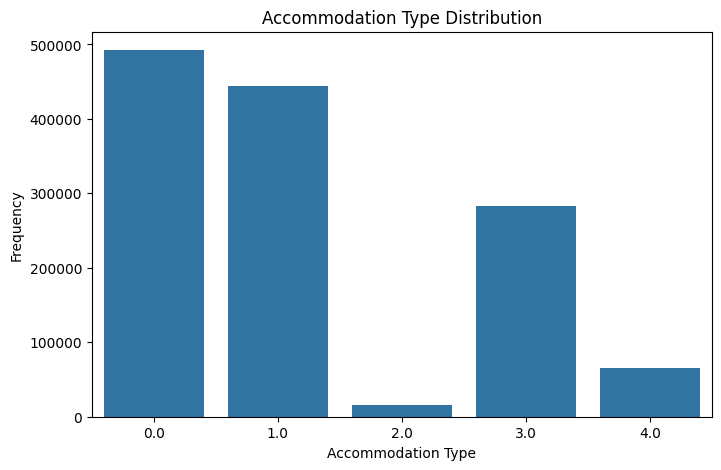

In [ ]:
# Accommodation Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='ACCOMMODATION_TYPE', data=df_final)
plt.title("Accommodation Type Distribution")
plt.xlabel("Accommodation Type")
plt.ylabel("Frequency")
plt.show()

Note:
- It is clear that more year of experiences might go with higher income
>So we use customer income to predict the working in year

####LOAN PURPOSE AND MONTH_INTEREST

Note:
- Loan purpose decides the amount of month_interest
  - Different Purposes, Different Risks: Lenders evaluate the risk associated with the purpose of a loan.
  - Business Loans vs. Personal Loans
> Predict month_interest by loan_Purpose

In [ ]:
loan_pattern = df_final.groupby("LOAN_PURPOSE")["MONTH_INTEREST"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
loan_pattern
print('Before fill', df_final['MONTH_INTEREST'].isnull().sum())
df_final['MONTH_INTEREST'] = df_final.apply(lambda row: loan_pattern[row['LOAN_PURPOSE']]
                                              if pd.isnull(row['MONTH_INTEREST']) and row['LOAN_PURPOSE'] in loan_pattern
                                              else row['MONTH_INTEREST'], axis=1)
print('After fill', df_final['MONTH_INTEREST'].isnull().sum())

Before fill 366561
After fill 12519


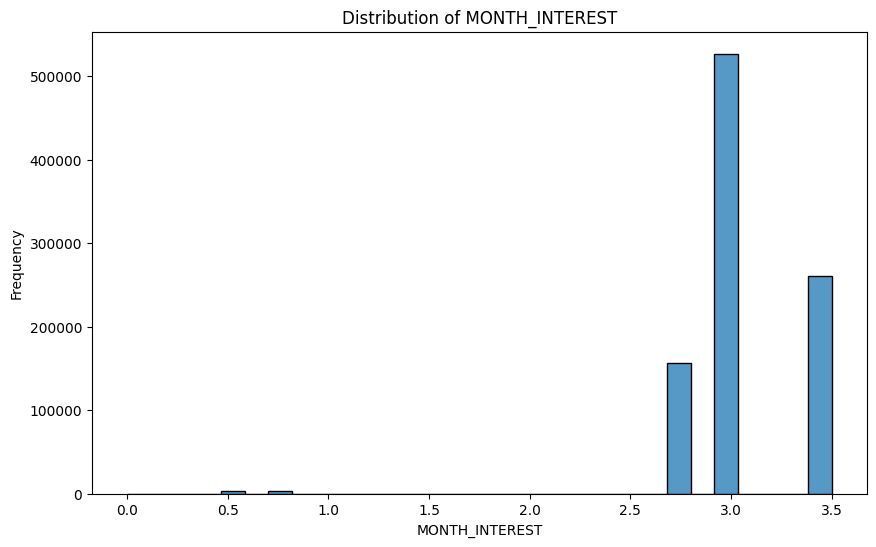

In [ ]:
# Assuming df is your DataFrame
plt.figure(figsize=(10,6))  # Optional: Change the size of the plot

# Plot the distribution of 'MONTH_INTEREST' column
sns.histplot(df_final['INSURANCE_RATE'], kde=False, bins=30)

# Add labels and title
plt.title('Distribution of MONTH_INTEREST')
plt.xlabel('MONTH_INTEREST')
plt.ylabel('Frequency')

# Show the plot
plt.show()


####Loan Amount and Business Line

Note:
Loan amount can determine the business line because
- Industry Risk Profile: High-risk industries may face smaller loan amounts due to higher chances of default.
- Revenue Stability: Consistent revenue in stable industries can lead to larger approved loan amounts.
- Collateral Availability: Asset-rich businesses can secure larger loans with valuable collateral.

In [ ]:
print('Before Fill: ', df_final['BUSINESS_LINE'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("LOAN_AMOUNT_BIN")["BUSINESS_LINE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['BUSINESS_LINE'] = df_final.apply(lambda row: Loan_Term_pattern1[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['BUSINESS_LINE']) and row['LOAN_AMOUNT_BIN'] in Loan_Term_pattern1
                                         else row['BUSINESS_LINE'], axis=1)
print('After Fill: ', df_final['BUSINESS_LINE'].isnull().sum())

Before Fill:  366054
After Fill:  12519


### **3.5 INSURANCE**

####INSURANCE_COMPANY and INSURANCE_RATE

Note:
- Insurance companies usually come with their own insurance rates, the larger insurance companies usually have lower insurance rates.
> Predict null of insurance rate by insurance comapny and reverse

In [ ]:
print('Before Fill: ', df_final['INSURANCE_RATE'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("INSURANCE_COMPANY")["INSURANCE_RATE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['INSURANCE_RATE'] = df_final.apply(lambda row: Loan_Term_pattern1[row['INSURANCE_COMPANY']]
                                         if pd.isnull(row['INSURANCE_RATE']) and row['INSURANCE_COMPANY'] in Loan_Term_pattern1
                                         else row['INSURANCE_RATE'], axis=1)
print('After Fill: ', df_final['INSURANCE_RATE'].isnull().sum())

Before Fill:  363766
After Fill:  221806


In [ ]:
print('Before Fill: ', df_final['INSURANCE_COMPANY'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("INSURANCE_RATE")["INSURANCE_COMPANY"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['INSURANCE_COMPANY'] = df_final.apply(lambda row: Loan_Term_pattern1[row['INSURANCE_RATE']]
                                         if pd.isnull(row['INSURANCE_COMPANY']) and row['INSURANCE_RATE'] in Loan_Term_pattern1
                                         else row['INSURANCE_COMPANY'], axis=1)
print('After Fill: ', df_final['INSURANCE_COMPANY'].isnull().sum())

Before Fill:  366184
After Fill:  221806


#### Has Insurance with insurance rate

In [ ]:
# Fill null values in HAS_INSURANCE with 0 if INSURANCE_RATE is 0
df_final['HAS_INSURANCE'] = df_final.apply(
    lambda row: 0 if pd.isnull(row['HAS_INSURANCE']) and row['INSURANCE_RATE'] == 0 else row['HAS_INSURANCE'],
    axis=1
)

# Print the count of null values after filling
print('After Fill: ', df_final['HAS_INSURANCE'].isnull().sum())

After Fill:  365287


In [ ]:
# Fill null values in HAS_INSURANCE with 1
df_final['HAS_INSURANCE'].fillna(1, inplace=True)

# Print the count of null values after filling
print('After Fill: ', df_final['HAS_INSURANCE'].isnull().sum())

After Fill:  0


<ipython-input-58-619418ab21e8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['HAS_INSURANCE'].fillna(1, inplace=True)


####DISBURSEMENT and INSURANCE RATE

Note:
Data show that the Insurance rate has risen through 2 years show that we can predict the Disburment date by using the insurance rate information

In [ ]:
marital_pattern = df_final.groupby("INSURANCE_RATE")["DISBURSEMENT_DATE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
marital_pattern
print('Before fill', df_final['DISBURSEMENT_DATE'].isnull().sum())
df_final['DISBURSEMENT_DATE'] = df_final.apply(lambda row: marital_pattern[row['INSURANCE_RATE']]
                                              if pd.isnull(row['DISBURSEMENT_DATE']) and row['INSURANCE_RATE'] in marital_pattern
                                              else row['DISBURSEMENT_DATE'], axis=1)
print('After fill', df_final['DISBURSEMENT_DATE'].isnull().sum())

Before fill 364871
After fill 200655


###**3.6 OTHER RELATIONSHIP**

####LABOUR CONTRACT_TYPE AND JOB

Note:
- Some specific job require specific labour_contract_type

In [ ]:
# Fill missing values in "LABOUR_CONTRACT_TYPE based on the patterns identified with ""JOB"
marital_pattern = df_final.groupby("JOB")["LABOUR_CONTRACT_TYPE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
marital_pattern
print('Before fill', df_final['LABOUR_CONTRACT_TYPE'].isnull().sum())
df_final['LABOUR_CONTRACT_TYPE'] = df_final.apply(lambda row: marital_pattern[row['JOB']]
                                              if pd.isnull(row['LABOUR_CONTRACT_TYPE']) and row['JOB'] in marital_pattern
                                              else row['LABOUR_CONTRACT_TYPE'], axis=1)
print('After fill', df_final['LABOUR_CONTRACT_TYPE'].isnull().sum())

Before fill 259766
After fill 40859


####Adjust month and year column by new disbursement date

In [ ]:
df_final.drop(['month', 'year'], axis = 1, inplace = True)
df_final['DISBURSEMENT_DATE'] = pd.to_datetime(df_final['DISBURSEMENT_DATE'], errors='coerce')

# Step 2: Extract the month and year
df_final['month'] = df_final['DISBURSEMENT_DATE'].dt.month.astype(float)  # Extract month and convert to float
df_final['year'] = df_final['DISBURSEMENT_DATE'].dt.year.astype(float)    # Extract year and convert to float


###**3.7 FFILL all null without clues**

Note:
With other columns, we dont have clue to fill their null, so we decide to use ffill to preserve the data interity

In [ ]:
df = df_final.copy()
df.fillna(method='ffill', inplace=True)

# Hiển thị kết quả
df.isnull().sum()

<ipython-input-62-afe289383d9e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


CONTRACT_NO                    0
SYS_RUN_DATE                   0
TOTAL_EMI_AMOUNT               0
DUE_DATE_OF_MON                1
PARTNER_CODE                   0
OUTSTANDING                    0
PRI_PAST_DUE                   0
INT_PAST_DUE                   0
OD_PAST_DUE                    0
OVER_DUE_DAYS_LD               0
OVER_DUE_DAYS_CLIENT           0
LAST_PAYMENT_DATE              1
LAST_PAYMENT_AMOUNT            1
TOTAL_OVERDUE_PERIOD           1
MAX_DPD_HISTORY                1
MONTH_ON_BOOK                  0
CUSTOMER_MAX_DPD_HISTORY       0
LABOUR_CONTRACT_TYPE           0
NUMBER_OF_DEPENDANTS           0
PERMANENT_ADDRESS_PROVINCE     0
INDUSTRY                       0
JOB                           13
COMPANY_ADDRESS_PROVINCE       0
WEIGHT                         0
EDUCATION                     13
CUSTOMER_INCOME                0
CREDITIBILITY                  0
ACCOMMODATION_TYPE             0
DATE_OF_BIRTH                  0
HEIGHT                        13
WORKING_IN_YEAR                0
MARITAL_STATUS                 0
INCOME_RESOURCE                0
DISBURSEMENT_CHANNEL           0
LIQUIDITY                      0
INSURANCE_COMPANY              0
INSURANCE_RATE                 0
DISBURSEMENT_DATE              0
RATE                           0
HAS_INSURANCE                  0
PRODUCT_CATEGORY               0
LOAN_TERM                      0
MONTH_INTEREST                 0
LOAN_PURPOSE                   0
BUSINESS_LINE                  0
LOAN_AMOUNT                    0
CUSTOMER_INCOME_BIN            0
LOAN_AMOUNT_BIN                0
month                          0
year                           0
dtype: int64

In [ ]:
# Fill nulls in the JOB column with the mode of df_final
df['JOB'].fillna(df_final['JOB'].mode()[0], inplace=True)

# Fill nulls in the WEIGHT column with the mode of df_final
df['WEIGHT'].fillna(df_final['WEIGHT'].mode()[0], inplace=True)

df['EDUCATION'].fillna(df_final['EDUCATION'].mode()[0], inplace=True)
df['HEIGHT'].fillna(df_final['HEIGHT'].mode()[0], inplace=True)

<ipython-input-63-a49654d5a58c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['JOB'].fillna(df_final['JOB'].mode()[0], inplace=True)
<ipython-input-63-a49654d5a58c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [ ]:
df_loan_demo = df.copy()

JOB and weight still have null, we fill by using mode

Xoá các cột không còn cần thiết

## **4. REPAYMENT**

In [ ]:
!pip install lunarcalendar
import pandas as pd
from lunarcalendar import Converter, Solar, Lunar



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.3 MB/s eta 0:00:00


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
nearest_day = df['DUE_DATE_OF_MON'].dropna().dt.day.min()

# Điền giá trị null của DUE_DATE_OF_MON bằng ngày gần nhất của tháng và năm từ SYS_RUN_DATE
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT))
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')

# Thêm cột ngày trong tuần (được mã hóa từ Monday = 1 đến Sunday = 7)
df['WEEKDAY'] = df['DUE_DATE_OF_MON'].dt.weekday + 1


# Thêm cột ngày âm lịch
def convert_to_lunar(date):
    solar = Solar(date.year, date.month, date.day)
    lunar = Converter.Solar2Lunar(solar)
    return f"{lunar.year}-{lunar.month}-{lunar.day}"

df['LUNAR_DATE'] = df['DUE_DATE_OF_MON'].apply(convert_to_lunar)
df['WEEKDAY'] = df.groupby('CONTRACT_NO')['WEEKDAY'].transform(lambda x: [0] + list(x.iloc[1:]))

In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT)
)


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'], errors='coerce')
df['SYS_RUN_DATE'] = df['SYS_RUN_DATE'].dt.strftime('%Y-%m')

In [ ]:
# Fill in null in the TOTAL_EMI_AMOUNT column (all records with the same contract_no have the same TOTAL_EMI_AMOUNT )
df['TOTAL_EMI_AMOUNT'] = df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


<ipython-input-72-9d1c2e29976a>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['TOTAL_EMI_AMOUNT'] = df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [ ]:
# Fill null in the CUSTOMER_MAX_DPD_HISTORY column with 0
df['CUSTOMER_MAX_DPD_HISTORY'] = df['CUSTOMER_MAX_DPD_HISTORY'].fillna(0)

In [ ]:
# The following columns are also filled with 0
df['TOTAL_OVERDUE_PERIOD'] = df['TOTAL_OVERDUE_PERIOD'].fillna(0)
df['MAX_DPD_HISTORY'] = df['MAX_DPD_HISTORY'].fillna(0)
df['LAST_PAYMENT_AMOUNT'] = df['LAST_PAYMENT_AMOUNT'].fillna(0)

In [ ]:
df.head()

CONTRACT_NO SYS_RUN_DATE  TOTAL_EMI_AMOUNT DUE_DATE_OF_MON  PARTNER_CODE  \
0       765326      2022-06        588.217647      2022-06-02             0   
1       765326      2022-07        588.217647      2022-07-08             0   
2       765326      2022-08        588.217647      2022-08-08             0   
3       765326      2022-09        588.217647      2022-09-08             0   
4       765326      2022-10        588.217647      2022-10-08             0   

   OUTSTANDING  PRI_PAST_DUE  INT_PAST_DUE  OD_PAST_DUE  OVER_DUE_DAYS_LD  \
0  2302.172887           0.0           0.0          0.0               0.0   
1  2271.227348           0.0           0.0          0.0               0.0   
2  2240.111009           0.0           0.0          0.0               0.0   
3  2207.314432           0.0           0.0          0.0               0.0   
4  2171.298613           0.0           0.0          0.0               0.0   

   ...  MONTH_INTEREST LOAN_PURPOSE  BUSINESS_LINE  LOAN_AMOUNT  \
0  ...             1.8          3.0            0.0     750000.0   
1  ...             1.8          3.0            0.0     750000.0   
2  ...             1.8          3.0            0.0     750000.0   
3  ...             1.8          3.0            0.0     750000.0   
4  ...             1.8          3.0            0.0     750000.0   

   CUSTOMER_INCOME_BIN  LOAN_AMOUNT_BIN  month    year  WEEKDAY  LUNAR_DATE  
0                  1.0              0.0    6.0  2022.0        0    2022-5-4  
1                  1.0              0.0    6.0  2022.0        5   2022-6-10  
2                  1.0              0.0    6.0  2022.0        1   2022-7-11  
3                  1.0              0.0    6.0  2022.0        4   2022-8-13  
4                  1.0              0.0    6.0  2022.0        6   2022-9-13  

[5 rows x 52 columns]

In [ ]:
# Check and fill null values for 'LAST_PAYMENT_DATE'
def fill_last_payment_date(row):
    if pd.isna(row['LAST_PAYMENT_DATE']):  # Process only when LAST_PAYMENT_DATE is null
        if row['OVER_DUE_DAYS_LD'] == 0.0:
            # If OVER_DUE_DAYS_LD == 0.0, then LAST_PAYMENT_DATE = DUE_DATE_OF_MON - 1 day
            return row['DUE_DATE_OF_MON'] - pd.Timedelta(days=1)
        elif row['OVER_DUE_DAYS_LD'] > 0.0:
            # If OVER_DUE_DAYS_LD > 0.0, then LAST_PAYMENT_DATE = DUE_DATE_OF_MON - OVER_DUE_DAYS_LD - 3 days
            return row['DUE_DATE_OF_MON'] - pd.Timedelta(days=row['OVER_DUE_DAYS_LD'] + 3)
    return row['LAST_PAYMENT_DATE']

# Apply the function to the entire dataframe
df['LAST_PAYMENT_DATE'] = df.apply(fill_last_payment_date, axis=1)





In [ ]:
# Fill null in columns 'JOB', 'EDUCATION', 'HEIGHT' with their respective mode
for col in ['JOB', 'EDUCATION', 'HEIGHT']:
    mode_value = df[col].mode().iloc[0]
    df[col].fillna(mode_value, inplace=True)


<ipython-input-83-cef2036811aa>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [ ]:
df['WEEKDAY'] = df.groupby('CONTRACT_NO')['WEEKDAY'].transform(lambda x: [0] + list(x.iloc[1:]))

In [ ]:
total_outstanding = df['OUTSTANDING'].sum()
print(total_outstanding)

3792407389.2131557


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE']).dt.date

In [ ]:
total_penalty = df['OD_PAST_DUE'].sum()
print(total_penalty)

145175128.77556103


In [ ]:
result = df.groupby('CONTRACT_NO').apply(lambda x: (x['OD_PAST_DUE'] > 0).sum()).reset_index(name='Penalty_Count')
count_greater_than_zero = (result['Penalty_Count'] > 0).sum()
number_of_contracts=df['CONTRACT_NO'].nunique()
percent=(count_greater_than_zero/number_of_contracts)*100
print(f"{percent:.2f}%")

45.44%


<ipython-input-88-261fcb8d8202>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('CONTRACT_NO').apply(lambda x: (x['OD_PAST_DUE'] > 0).sum()).reset_index(name='Penalty_Count')


## **5. Drop unnecessary columns**

In [ ]:
df.drop(['LOAN_AMOUNT_BIN', 'CUSTOMER_INCOME_BIN','DISBURSEMENT_DATE'], axis =1 , inplace = True )

## **6. Create Columns**

###ADD BUCKETS

In [ ]:
# Redefine the DPD bucket classification function, as the environment has reset
def classify_dpd_bucket(days_overdue):
    if days_overdue == 0:
        return "B0"
    elif 1 <= days_overdue <= 9:
        return "B1"
    elif 10 <= days_overdue <= 30:
        return "B2"
    elif 31 <= days_overdue <= 60:
        return "B3"
    elif 61 <= days_overdue <= 90:
        return "B4"
    elif 91 <= days_overdue <= 120:
        return "B5"
    elif 121 <= days_overdue <= 150:
        return "B6"
    elif 151 <= days_overdue <= 180:
        return "B7"
    elif 181 <= days_overdue <= 210:
        return "B8"
    elif 211 <= days_overdue <= 240:
        return "B9"
    elif 241 <= days_overdue <= 270:
        return "B10"
    elif 181 <= days_overdue <= 210:
        return "B11"
    elif 211 <= days_overdue <= 240:
        return "B12"
    elif 241 <= days_overdue <= 270:
        return "B13"
    else:
        return "B14"
# Apply the DPD bucket classification function to the new data
df['DPD_BUCKET'] = df['OVER_DUE_DAYS_LD'].apply(classify_dpd_bucket)

### Calculate Age

In [ ]:
df['Age'] = 2024 - df['DATE_OF_BIRTH']

### Extract number from DPD Bucket

In [ ]:
# Tạo một cột mới chỉ chứa phần số từ cột DPD_BUCKET
df['BUCKET_NUMBER'] = df['DPD_BUCKET'].str.extract('(\d+)', expand=False).astype(int)

### Calculate Weekday, Lunar day, 1-3 day of lunar day of Due date and Payment Date

In [ ]:
!pip install lunarcalendar

import pandas as pd
from lunarcalendar import Converter, Solar, Lunar

In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
nearest_day = df['DUE_DATE_OF_MON'].dropna().dt.day.min()

# Fill the null value of DUE_DATE_OF_MON with the nearest day of the month and year from SYS_RUN_DATE
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT))

df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
df['LAST_PAYMENT_DATE'] = pd.to_datetime(df['LAST_PAYMENT_DATE'], errors='coerce')

# Add weekday column (Monday = 1, Sunday = 7)
df['WEEKDAY_DUE_DATE'] = df['DUE_DATE_OF_MON'].dt.weekday + 1
df['WEEKDAY_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].dt.weekday + 1

# Function to convert Gregorian date to Lunar date
def convert_to_lunar(date):
    try:
        solar = Solar(date.year, date.month, date.day)  # Create a Solar object
        lunar = Converter.Solar2Lunar(solar)  # Convert Solar to Lunar
        return f"{lunar.year}-{lunar.month}-{lunar.day}"  # Return formatted Lunar date
    except:
        return None  # Return None for invalid dates

# Add Lunar Date column
df['LUNAR_DATE_DUE_DATE'] = df['DUE_DATE_OF_MON'].apply(convert_to_lunar)
df['LUNAR_DATE_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].apply(convert_to_lunar)

# Adjust WEEKDAY for CONTRACT_NO groups (add 0 for the first row of each group)
def adjust_weekday(series):
    return [0] + list(series.iloc[1:].values)

df['WEEKDAY_DUE_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_DUE_DATE'].transform(adjust_weekday)
df['WEEKDAY_PAYMENT_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_PAYMENT_DATE'].transform(adjust_weekday)

In [ ]:
# Function to check if a Lunar Date falls on the 1st or 2nd or 3rd day of the lunar month
def is_lunar_1_or_2_or_3_day(lunar_date):
    try:
        if lunar_date:
            lunar_day = int(lunar_date.split('-')[2])  # Extract the day part of Lunar Date
            return lunar_day in [1, 2, 3]  # Check if it's the 1st or 2nd day
        return False
    except:
        return False

# Add a new column to indicate if DUE_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_DUE_DATE'] = df['LUNAR_DATE_DUE_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)

# Add a new column to indicate if PAYMENT_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_PAYMENT_DATE'] = df['LUNAR_DATE_PAYMENT_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)


In [ ]:
df[['IS_LUNAR_1-3_DAY_DUE_DATE', 'IS_LUNAR_1-3_DAY_PAYMENT_DATE', 'BUCKET_NUMBER']][(df['IS_LUNAR_1-3_DAY_DUE_DATE'] == 1) & (df['BUCKET_NUMBER'] == 1)]


IS_LUNAR_1-3_DAY_DUE_DATE  IS_LUNAR_1-3_DAY_PAYMENT_DATE  \
4779                             1                              0   
5206                             1                              0   
5752                             1                              0   
5960                             1                              0   
6441                             1                              1   
...                            ...                            ...   
1312343                          1                              1   
1312732                          1                              0   
1313056                          1                              0   
1313135                          1                              0   
1313162                          1                              1   

         BUCKET_NUMBER  
4779                 1  
5206                 1  
5752                 1  
5960                 1  
6441                 1  
...                ...  
1312343              1  
1312732              1  
1313056              1  
1313135              1  
1313162              1  

[2663 rows x 3 columns]

#**II. METRIC**


##ROLL RATE MATRIX

In [ ]:
df_repayment_6_12 = df[df['MONTH_ON_BOOK'].isin([6, 12])]
df_repayment_6_12_tf = df_repayment_6_12.groupby('CONTRACT_NO').agg({'DPD_BUCKET':['first', 'last']})
df_repayment_6_12_tf.columns = ['_'.join(x) for x in df_repayment_6_12_tf.columns]
df_repayment_6_12_tf = df_repayment_6_12_tf.reset_index()
df_repayment_6_12_tf

CONTRACT_NO DPD_BUCKET_first DPD_BUCKET_last
0            340732               B0              B0
1            341505               B0              B3
2            341586               B0              B0
3            342421               B3             B10
4            342823               B0              B5
...             ...              ...             ...
101038       856744               B7             B14
101039       856747               B4             B10
101040       856750               B7             B14
101041       856760               B5             B14
101042       856761               B7             B14

[101043 rows x 3 columns]

In [ ]:
rollrate = pd.pivot_table(df_repayment_6_12_tf, values='CONTRACT_NO', index=['DPD_BUCKET_first'],
                       columns=['DPD_BUCKET_last'], aggfunc="count", fill_value=0, margins = True)
rollrate2 = rollrate.div(rollrate.iloc[:,-1], axis=0 )

sorted_columns = sorted(rollrate2.columns, key=lambda x: (int(x[1:]) if x != 'All' else float('inf')))

# Reorder the columns in the DataFrame
df_sorted = rollrate2[sorted_columns]

df_sorted.to_csv('rollrate.csv')
df_sorted


DPD_BUCKET_last         B0        B1        B2        B3        B4        B5  \
DPD_BUCKET_first                                                               
B0                0.719107  0.004636  0.055210  0.045366  0.044542  0.044179   
B1                0.076179  0.043531  0.065296  0.043531  0.061669  0.081016   
B2                0.034035  0.003333  0.055789  0.038421  0.047018  0.050877   
B3                0.009141  0.000548  0.008592  0.010603  0.017550  0.021024   
B4                0.002957  0.000000  0.000821  0.001807  0.006406  0.008541   
B5                0.001317  0.000000  0.000219  0.000658  0.000439  0.002414   
B6                0.000234  0.000000  0.000234  0.000000  0.000234  0.000468   
B7                0.000412  0.000000  0.000000  0.000000  0.000000  0.000000   
B8                0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
All               0.512990  0.003860  0.043348  0.035391  0.036094  0.036628   

DPD_BUCKET_last         B6        B7        B8        B9       B10       B14  \
DPD_BUCKET_first                                                               
B0                0.042894  0.040967  0.003100  0.000000  0.000000  0.000000   
B1                0.090689  0.118501  0.419589  0.000000  0.000000  0.000000   
B2                0.079298  0.107544  0.545789  0.037895  0.000000  0.000000   
B3                0.034004  0.036563  0.065082  0.735466  0.061426  0.000000   
B4                0.013305  0.010512  0.024310  0.039258  0.833771  0.058311   
B5                0.006585  0.003292  0.003292  0.010097  0.025241  0.946444   
B6                0.001403  0.000468  0.000935  0.000468  0.002104  0.993453   
B7                0.000000  0.000000  0.000412  0.000000  0.000000  0.999177   
B8                0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
All               0.038617  0.038855  0.041606  0.044793  0.054789  0.113031   

DPD_BUCKET_last   All  
DPD_BUCKET_first       
B0                1.0  
B1                1.0  
B2                1.0  
B3                1.0  
B4                1.0  
B5                1.0  
B6                1.0  
B7                1.0  
B8                1.0  
All               1.0

##FLOW RATE MATRIX

In [ ]:
result = []

for row in df_sorted.index[:-1]:
    stay = df_sorted.loc[row, row]
    cure = df_sorted.loc[row, :row].iloc[:-1].sum() if row != "B0" else np.nan
    roll = df_sorted.loc[row, row:].iloc[1:-1].sum()
    if not np.isnan(cure):
        roll = 1 - stay - cure
    result.append([row, cure, stay, roll])

result_df = pd.DataFrame(result, columns=["DPD_Bucket", "Cure", "Stay", "Roll"])
result_df[["Cure", "Stay", "Roll"]] = result_df[["Cure", "Stay", "Roll"]].multiply(100).round(12)
result_df["Cure"] = result_df["Cure"].apply(lambda x: f"{x:.2f}%" if x != "" else "")
result_df["Stay"] = result_df["Stay"].apply(lambda x: f"{x:.2f}%")
result_df["Roll"] = result_df["Roll"].apply(lambda x: f"{x:.2f}%")
result_df["Cure"] = result_df["Cure"].replace({"nan%": " "})

print(result_df.to_string(index=False))


DPD_Bucket  Cure   Stay    Roll
        B0       71.91%  28.09%
        B1 7.62%  4.35%  88.03%
        B2 3.74%  5.58%  90.68%
        B3 1.83%  1.06%  97.11%
        B4 0.56%  0.64%  98.80%
        B5 0.26%  0.24%  99.50%
        B6 0.12%  0.14%  99.74%
        B7 0.04%  0.00%  99.96%
        B8 0.00%  0.00% 100.00%


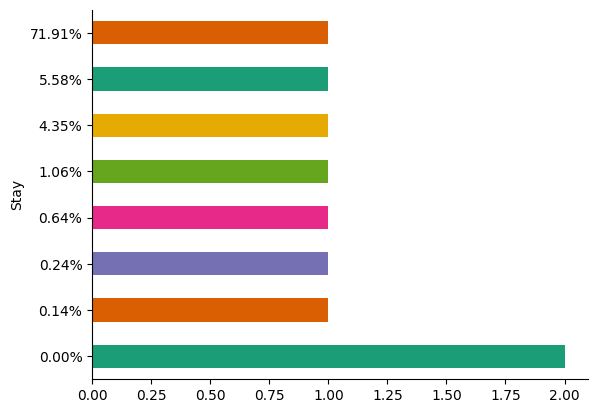

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
result_df.groupby('Stay').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##TRANSACTION MATRIX


In [ ]:

# Prepare the migration data
# Get the bucket status by month
data_sorted = df.sort_values(['CONTRACT_NO', 'MONTH_ON_BOOK'])
data_grouped = data_sorted.groupby('CONTRACT_NO')

# Get bucket at current and next time
data_sorted['Next_Bucket'] = data_grouped['DPD_BUCKET'].shift(-1)

# Create transaction matrix
transaction_matrix = pd.crosstab(data_sorted['DPD_BUCKET'], data_sorted['Next_Bucket'], normalize='index')

sorted_columns = sorted(transaction_matrix.columns, key=lambda x: int(x[1:]))
transaction_matrix_final = transaction_matrix[sorted_columns]
transaction_matrix_final

sorted_index = sorted(transaction_matrix.index, key=lambda x: int(x[1:]))
transaction_matrix_final_sorted = transaction_matrix_final.reindex(sorted_index)

# Display the final sorted DataFrame
transaction_matrix_final_sorted.round(3).to_csv('transaction.csv')
transaction_matrix_final_sorted



Next_Bucket        B0        B1        B2        B3        B4        B5  \
DPD_BUCKET                                                                
B0           0.942013  0.005654  0.051670  0.000662  0.000001  0.000000   
B1           0.069058  0.242778  0.121725  0.566438  0.000000  0.000000   
B2           0.042628  0.012915  0.222677  0.714000  0.007781  0.000000   
B3           0.009201  0.002598  0.020349  0.080748  0.878423  0.008681   
B4           0.003654  0.000270  0.002280  0.004487  0.079964  0.892867   
B5           0.001287  0.000086  0.000601  0.000343  0.003947  0.051677   
B6           0.000831  0.000000  0.000299  0.000133  0.000133  0.001496   
B7           0.000195  0.000000  0.000078  0.000039  0.000000  0.000117   
B8           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
B9           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
B10          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
B14          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

Next_Bucket        B6        B7        B8        B9       B10       B14  
DPD_BUCKET                                                               
B0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
B1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
B2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
B3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
B4           0.016478  0.000000  0.000000  0.000000  0.000000  0.000000  
B5           0.922641  0.019418  0.000000  0.000000  0.000000  0.000000  
B6           0.034896  0.951577  0.010635  0.000000  0.000000  0.000000  
B7           0.000272  0.012411  0.978525  0.008364  0.000000  0.000000  
B8           0.000000  0.000000  0.002626  0.979131  0.018242  0.000000  
B9           0.000000  0.000000  0.000000  0.003908  0.976553  0.019539  
B10          0.000000  0.000000  0.000000  0.000000  0.002069  0.997931  
B14          0.000000  0.000000  0.000000  0.000000  0.000000  1.000000

##VINTAGE MATRIX

In [ ]:
# Chuyển đổi SYS_RUN_DATE sang kiểu datetime
df_repayment_vintage = df.copy()
df_repayment_vintage['SYS_RUN_DATE'] = pd.to_datetime(df_repayment_vintage['SYS_RUN_DATE'], errors='coerce')

# Tính toán ORIGIN_QUARTER (thay vì ORIGIN_MONTH)
# Sử dụng .dt.to_period('Q') để chuyển thành quý (quarter)
df_repayment_vintage['ORIGIN_QUARTER'] = (df_repayment_vintage['SYS_RUN_DATE'] - pd.to_timedelta(df_repayment_vintage['MONTH_ON_BOOK'] * 30, unit='D')).dt.to_period('Q')

# Step 1: Create flags for 30 DPD and 90 DPD
df_repayment_vintage['IS_30_DPD'] = df_repayment_vintage['OVER_DUE_DAYS_CLIENT'] >= 30
df_repayment_vintage['IS_90_DPD'] = df_repayment_vintage['OVER_DUE_DAYS_CLIENT'] >= 90

# Step 2: Group data by ORIGIN_QUARTER and MONTH_ON_BOOK, and calculate relevant metrics
dpd_matrix = (
    df_repayment_vintage.groupby(['ORIGIN_QUARTER', 'MONTH_ON_BOOK'])
    .agg(
        Total_Customers=('CONTRACT_NO', 'count'),
        Customers_30_DPD=('IS_30_DPD', 'sum'),
        Customers_90_DPD=('IS_90_DPD', 'sum')
    )
    .reset_index()
)

# Step 3: Calculate 30 DPD and 90 DPD rates
dpd_matrix['30_DPD_Rate'] = (dpd_matrix['Customers_30_DPD'] / dpd_matrix['Total_Customers']) * 100
dpd_matrix['90_DPD_Rate'] = (dpd_matrix['Customers_90_DPD'] / dpd_matrix['Total_Customers']) * 100

# Step 4: Pivot the data to create separate matrices for 30 DPD and 90 DPD rates
dpd_30_pivot = dpd_matrix.pivot(
    index='ORIGIN_QUARTER',  # Change to ORIGIN_QUARTER
    columns='MONTH_ON_BOOK',
    values='30_DPD_Rate'
).fillna(0)

dpd_90_pivot = dpd_matrix.pivot(
    index='ORIGIN_QUARTER',  # Change to ORIGIN_QUARTER
    columns='MONTH_ON_BOOK',
    values='90_DPD_Rate'
).fillna(0)
dpd_30_pivot = dpd_30_pivot[dpd_30_pivot.index != '2022Q1']
dpd_90_pivot = dpd_90_pivot[dpd_90_pivot.index != '2022Q1']
# Display 30 DPD pivot table for reference
dpd_30_pivot.to_excel('dpd_30_pivot.xlsx')
dpd_90_pivot.to_excel('dpd_90_pivot.xlsx')
dpd_30_pivot.round(2)


MONTH_ON_BOOK   0.0   1.0   2.0   3.0    4.0    5.0    6.0    7.0    8.0   \
ORIGIN_QUARTER                                                              
2022Q2           0.0  0.03  1.48  4.34   8.19  14.62  20.14  25.30  30.50   
2022Q3           0.0  0.04  3.65  9.02  14.20  20.67  26.21  30.80  34.97   
2022Q4           0.0  0.08  2.76  9.29  13.86  19.46  24.06  28.05  31.54   
2023Q1           0.0  0.04  3.03  6.22  10.61  15.32  19.30  22.62  26.13   

MONTH_ON_BOOK    9.0    10.0   11.0   12.0  
ORIGIN_QUARTER                              
2022Q2          35.29  39.36  43.16  46.68  
2022Q3          38.38  41.42  44.27  46.95  
2022Q4          34.64  37.66  40.26  42.82  
2023Q1          29.18  31.93  34.43  36.70

In [ ]:
dpd_90_pivot.round(2)

MONTH_ON_BOOK   0.0   1.0   2.0   3.0   4.0   5.0    6.0    7.0    8.0   \
ORIGIN_QUARTER                                                            
2022Q2           0.0   0.0   0.0  0.09  1.41  3.71   7.61  13.80  18.96   
2022Q3           0.0   0.0   0.0  0.03  3.59  8.56  13.47  19.66  25.04   
2022Q4           0.0   0.0   0.0  0.06  3.14  8.70  13.25  18.93  23.32   
2023Q1           0.0   0.0   0.0  0.02  1.58  6.12  10.44  14.85  18.45   

MONTH_ON_BOOK    9.0    10.0   11.0   12.0  
ORIGIN_QUARTER                              
2022Q2          24.08  29.05  33.90  37.98  
2022Q3          29.65  33.71  37.23  40.35  
2022Q4          27.17  30.37  33.32  36.28  
2023Q1          21.50  24.93  28.00  30.77

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313559 entries, 0 to 1313558
Data columns (total 58 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   CONTRACT_NO                    1313559 non-null  int64         
 1   SYS_RUN_DATE                   1313559 non-null  datetime64[ns]
 2   TOTAL_EMI_AMOUNT               1313559 non-null  float64       
 3   DUE_DATE_OF_MON                1313559 non-null  datetime64[ns]
 4   PARTNER_CODE                   1313559 non-null  int64         
 5   OUTSTANDING                    1313559 non-null  float64       
 6   PRI_PAST_DUE                   1313559 non-null  float64       
 7   INT_PAST_DUE                   1313559 non-null  float64       
 8   OD_PAST_DUE                    1313559 non-null  float64       
 9   OVER_DUE_DAYS_LD               1313559 non-null  float64       
 10  OVER_DUE_DAYS_CLIENT           1313559 non-null  float

##Monthly Roll Rate

###Monthly Roll Rate for B0 Bucket

In [ ]:

# Ensure SYS_RUN_DATE is treated as a datetime object
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])

# Sort data by contract number and system run date
df = df.sort_values(by=['CONTRACT_NO', 'SYS_RUN_DATE'])

# Shift the bucket column to calculate transitions month over month
df['Previous_Bucket'] = df.groupby('CONTRACT_NO')['DPD_BUCKET'].shift(1)

# Filter rows where the previous bucket was B0
b0_transitions_updated = df[df['Previous_Bucket'] == "B0"]

# Recalculate the monthly roll rates using the updated classification
roll_rate_data_updated = (
    b0_transitions_updated.groupby(b0_transitions_updated['SYS_RUN_DATE'].dt.to_period('M'))
    .apply(lambda x: (x['DPD_BUCKET'] != "B0").mean() * 100)
    .reset_index(name='Roll Rate (%)')
)

# Rename the date column for clarity
roll_rate_data_updated['Month'] = roll_rate_data_updated['SYS_RUN_DATE'].astype(str)
roll_rate_data_updated = roll_rate_data_updated[['Month', 'Roll Rate (%)']]

# Display the updated roll rate data to the user
print("Updated Monthly Roll Rate for B0 Bucket:")
print(roll_rate_data_updated)

Updated Monthly Roll Rate for B0 Bucket:
      Month  Roll Rate (%)
0   2022-04       3.772291
1   2022-05       3.956883
2   2022-06       3.882883
3   2022-07       3.403650
4   2022-08       4.351583
5   2022-09       6.147504
6   2022-10       6.213472
7   2022-11       6.515329
8   2022-12       7.053527
9   2023-01       8.418723
10  2023-02       5.529715
11  2023-03       5.843274
12  2023-04       6.956392
13  2023-05       5.725826
14  2023-06       5.489200
15  2023-07       5.408244
16  2023-08       4.979410
17  2023-09       5.385173
18  2023-10       4.613695
19  2023-11       4.452118
20  2023-12       4.158853
21  2024-01       3.999579
22  2024-02       4.790895


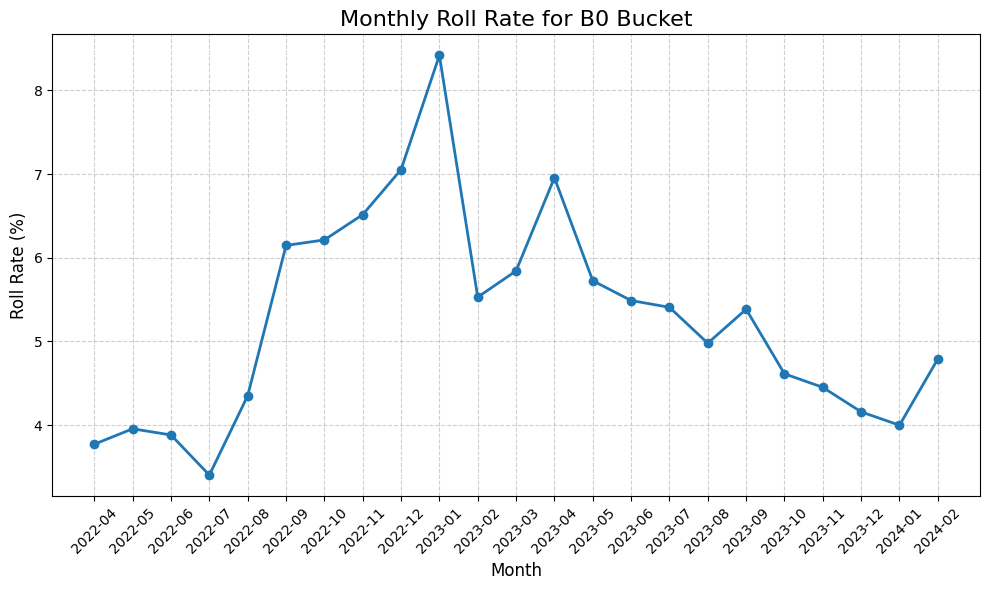

In [ ]:
# Create a line plot for the roll rate data
plt.figure(figsize=(10, 6))
plt.plot(roll_rate_data_updated['Month'], roll_rate_data_updated['Roll Rate (%)'], marker='o', linestyle='-', linewidth=2)

# Add labels, title, and grid
plt.title('Monthly Roll Rate for B0 Bucket', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Roll Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###Monthly Roll Rates: B0 to All Higher Buckets (B1 to B14)

In [ ]:
# Calculate roll rates from B0 to each higher bucket (B1 to B14)
def calculate_bucket_roll_rate(group):
    total_b0 = len(group)
    roll_rates = {}
    for bucket in group['DPD_BUCKET'].unique():
        if bucket != "B0":  # Only consider transitions to higher buckets
            roll_rates[bucket] = (group['DPD_BUCKET'] == bucket).sum() / total_b0 * 100
    return roll_rates

# Group data by month and calculate roll rates for each bucket
bucket_roll_rates = (
    b0_transitions_updated.groupby(b0_transitions_updated['SYS_RUN_DATE'].dt.to_period('M'))
    .apply(calculate_bucket_roll_rate)
)

# Transform the roll rates into a DataFrame for easier analysis
bucket_roll_rates_df = pd.DataFrame(bucket_roll_rates.tolist(), index=bucket_roll_rates.index).fillna(0)
bucket_roll_rates_df.index = bucket_roll_rates_df.index.astype(str)
bucket_roll_rates_df.reset_index(inplace=True)
bucket_roll_rates_df.rename(columns={'index': 'Month'}, inplace=True)

# Display the roll rate data
print(bucket_roll_rates_df)

   SYS_RUN_DATE        B2        B1        B3        B4
0       2022-04  3.374486  0.397805  0.000000  0.000000
1       2022-05  3.575254  0.381628  0.000000  0.000000
2       2022-06  3.450450  0.432432  0.000000  0.000000
3       2022-07  3.018528  0.204705  0.180418  0.000000
4       2022-08  3.969670  0.228591  0.153323  0.000000
5       2022-09  5.628189  0.519315  0.000000  0.000000
6       2022-10  5.682884  0.347077  0.181517  0.001995
7       2022-11  5.925610  0.589719  0.000000  0.000000
8       2022-12  6.537644  0.318909  0.196973  0.000000
9       2023-01  6.090857  2.327865  0.000000  0.000000
10      2023-02  3.977416  1.552299  0.000000  0.000000
11      2023-03  5.478826  0.201724  0.162724  0.000000
12      2023-04  6.447133  0.509259  0.000000  0.000000
13      2023-05  5.552727  0.173098  0.000000  0.000000
14      2023-06  5.098763  0.390437  0.000000  0.000000
15      2023-07  5.093200  0.170648  0.144395  0.000000
16      2023-08  4.666145  0.138949  0.174317  0

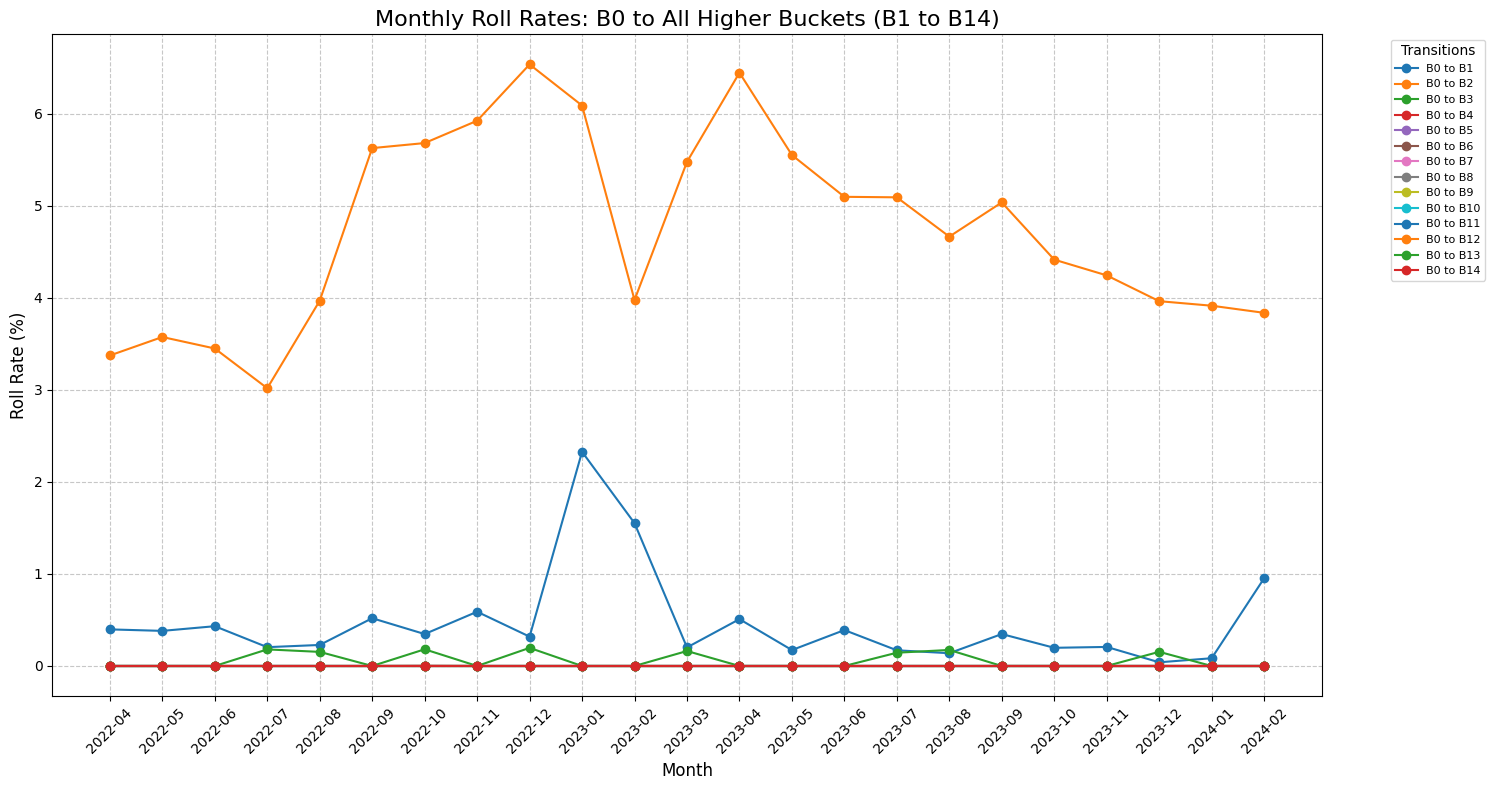

In [ ]:
# Get all bucket columns explicitly from B1 to B14
buckets_to_plot = [f"B{i}" for i in range(1, 15)]

# Ensure all selected buckets exist in the data, fill missing ones with zero
for bucket in buckets_to_plot:
    if bucket not in bucket_roll_rates_df.columns:
        bucket_roll_rates_df[bucket] = 0

# Plot transitions from B0 to B1 through B14
plt.figure(figsize=(15, 8))

# Access the 'SYS_RUN_DATE' column instead of 'Month' for the x-axis
for bucket in buckets_to_plot:
    plt.plot(bucket_roll_rates_df['SYS_RUN_DATE'], bucket_roll_rates_df[bucket], marker='o', label=f'B0 to {bucket}')

# Add plot details
plt.title('Monthly Roll Rates: B0 to All Higher Buckets (B1 to B14)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Roll Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Transitions', fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

# **Machine Learning**

## **1. Data Preprocessing**

### Add Buckets

In [ ]:
# Redefine the DPD bucket classification function, as the environment has reset
def classify_dpd_bucket(days_overdue):
    if days_overdue == 0:
        return "B0"
    elif 1 <= days_overdue <= 9:
        return "B1"
    elif 10 <= days_overdue <= 30:
        return "B2"
    elif 31 <= days_overdue <= 60:
        return "B3"
    elif 61 <= days_overdue <= 90:
        return "B4"
    elif 91 <= days_overdue <= 120:
        return "B5"
    elif 121 <= days_overdue <= 150:
        return "B6"
    elif 151 <= days_overdue <= 180:
        return "B7"
    elif 181 <= days_overdue <= 210:
        return "B8"
    elif 211 <= days_overdue <= 240:
        return "B9"
    elif 241 <= days_overdue <= 270:
        return "B10"
    elif 271 <= days_overdue <= 300:
        return "B11"
    elif 301 <= days_overdue <= 330:
        return "B12"
    elif 331 <= days_overdue <= 360:
        return "B13"
    else:
        return "B14"
# Apply the DPD bucket classification function to the new data
df_repayment['DPD_BUCKET'] = df_repayment['OVER_DUE_DAYS_LD'].apply(classify_dpd_bucket)


### Filter B0 and MONTH_ON_BOOK >= 3

In [ ]:
# Filter rows where DPD_BUCKET is "B0" and MONTH_ON_BOOK equals 3
filtered_b0_month3 = df_repayment[(df_repayment['DPD_BUCKET'] == "B0") & (df_repayment['MONTH_ON_BOOK'] == 3)]

# Include all rows where MONTH_ON_BOOK is greater than 3
filtered_after_month3 = df_repayment[df_repayment['MONTH_ON_BOOK'] > 3]

# Take out CONTRACT_NO in filtered_b0_month3
valid_contracts = filtered_b0_month3['CONTRACT_NO'].unique()

# Keep rows only where filtered_after_month3 have CONTRACT_NO in valid_contracts
filtered_after_month3 = filtered_after_month3[filtered_after_month3['CONTRACT_NO'].isin(valid_contracts)]

# Combine the filtered dataframes
filtered_df = pd.concat([filtered_b0_month3, filtered_after_month3])


### Add target variable "IS_ROLL_UP"

In [ ]:
# Sort data by CONTRACT_NO and SYS_RUN_DATE to process next month's DPD_BUCKET
filtered_df = filtered_df.sort_values(by=['CONTRACT_NO', 'SYS_RUN_DATE'])

# Shift DPD_BUCKET to get next month's bucket for each contract
filtered_df['NEXT_MONTH_DPD'] = filtered_df.groupby('CONTRACT_NO')['DPD_BUCKET'].shift(-1)

# Define the target variable: 1 if NEXT_MONTH_DPD is higher, 0 otherwise, NaN if no next month
def create_target_variable(current, next_month):
    if pd.isna(next_month):  # Nếu không có thông tin của tháng sau
        return None  # Trả về NaN
    if next_month > current:
        return 1  # Rolled into a higher bucket
    return 0  # Did not roll into a higher bucket

# Apply the function to create the target variable
filtered_df['IS_ROLL_UP'] = filtered_df.apply(
    lambda row: create_target_variable(row['DPD_BUCKET'], row['NEXT_MONTH_DPD']), axis=1
)


### Fill Null

In [ ]:
# Fill null ở cột TOTAL_EMI_AMOUNT (tất cả các bản ghi có cùng contract_no thì đều có cùng TOTAL_EMI_AMOUNT )
filtered_df['TOTAL_EMI_AMOUNT'] = filtered_df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Các cột sau cũng fill bằng 0
filtered_df['TOTAL_OVERDUE_PERIOD'] = filtered_df['TOTAL_OVERDUE_PERIOD'].fillna(0)
filtered_df['MAX_DPD_HISTORY'] = filtered_df['MAX_DPD_HISTORY'].fillna(0)
filtered_df['LAST_PAYMENT_AMOUNT'] = filtered_df['LAST_PAYMENT_AMOUNT'].fillna(0)

<ipython-input-11-8ef3a3edbb48>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df['TOTAL_EMI_AMOUNT'] = filtered_df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


### Merge table

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030020 entries, 50716 to 1274935
Data columns (total 20 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CONTRACT_NO               1030020 non-null  int64  
 1   SYS_RUN_DATE              1030020 non-null  object 
 2   TOTAL_EMI_AMOUNT          1030020 non-null  float64
 3   DUE_DATE_OF_MON           977250 non-null   object 
 4   PARTNER_CODE              1030020 non-null  int64  
 5   OUTSTANDING               1030020 non-null  float64
 6   PRI_PAST_DUE              1030020 non-null  float64
 7   INT_PAST_DUE              1030020 non-null  float64
 8   OD_PAST_DUE               1030020 non-null  float64
 9   OVER_DUE_DAYS_LD          1030020 non-null  float64
 10  OVER_DUE_DAYS_CLIENT      1030020 non-null  float64
 11  LAST_PAYMENT_DATE         1030020 non-null  object 
 12  LAST_PAYMENT_AMOUNT       1030020 non-null  float64
 13  TOTAL_OVERDUE_PERIOD      10

In [ ]:
df = pd.merge(filtered_df, df_demo_loan, on='CONTRACT_NO', how='left')


In [ ]:
# Drop rows where LABOUR_CONTRACT_TYPE is null
df_nonull = df.dropna(subset=['LABOUR_CONTRACT_TYPE'])

In [ ]:
df = df_nonull.copy()

### Feature Engineering (doing)

#### Calculate Age

In [ ]:
df['Age'] = 2024 - df_nonull['DATE_OF_BIRTH']

#### Extract number from DPD Bucket


In [ ]:
# Tạo một cột mới chỉ chứa phần số từ cột DPD_BUCKET
df['BUCKET_NUMBER'] = df['DPD_BUCKET'].str.extract('(\d+)', expand=False).astype(int)

#### Calculate Weekday, Lunar day, 1-3 day of lunar day of Due date and Payment Date

In [ ]:
!pip install lunarcalendar

import pandas as pd
from lunarcalendar import Converter, Solar, Lunar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.6 MB/s eta 0:00:00


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
nearest_day = df['DUE_DATE_OF_MON'].dropna().dt.day.min()

# Điền giá trị null của DUE_DATE_OF_MON bằng ngày gần nhất của tháng và năm từ SYS_RUN_DATE
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT))

df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
df['LAST_PAYMENT_DATE'] = pd.to_datetime(df['LAST_PAYMENT_DATE'], errors='coerce')

# Add weekday column (Monday = 1, Sunday = 7)
df['WEEKDAY_DUE_DATE'] = df['DUE_DATE_OF_MON'].dt.weekday + 1
df['WEEKDAY_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].dt.weekday + 1

# Function to convert Gregorian date to Lunar date
def convert_to_lunar(date):
    try:
        solar = Solar(date.year, date.month, date.day)  # Create a Solar object
        lunar = Converter.Solar2Lunar(solar)  # Convert Solar to Lunar
        return f"{lunar.year}-{lunar.month}-{lunar.day}"  # Return formatted Lunar date
    except:
        return None  # Return None for invalid dates

# Add Lunar Date column
df['LUNAR_DATE_DUE_DATE'] = df['DUE_DATE_OF_MON'].apply(convert_to_lunar)
df['LUNAR_DATE_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].apply(convert_to_lunar)

# Adjust WEEKDAY for CONTRACT_NO groups (add 0 for the first row of each group)
def adjust_weekday(series):
    return [0] + list(series.iloc[1:].values)

df['WEEKDAY_DUE_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_DUE_DATE'].transform(adjust_weekday)
df['WEEKDAY_PAYMENT_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_PAYMENT_DATE'].transform(adjust_weekday)


In [ ]:
# Function to check if a Lunar Date falls on the 1st or 2nd or 3rd day of the lunar month
def is_lunar_1_or_2_or_3_day(lunar_date):
    try:
        if lunar_date:
            lunar_day = int(lunar_date.split('-')[2])  # Extract the day part of Lunar Date
            return lunar_day in [1, 2, 3]  # Check if it's the 1st or 2nd day
        return False
    except:
        return False

# Add a new column to indicate if DUE_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_DUE_DATE'] = df['LUNAR_DATE_DUE_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)

# Add a new column to indicate if PAYMENT_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_PAYMENT_DATE'] = df['LUNAR_DATE_PAYMENT_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)


In [ ]:
df[['IS_LUNAR_1-3_DAY_DUE_DATE', 'IS_LUNAR_1-3_DAY_PAYMENT_DATE', 'BUCKET_NUMBER']][(df['IS_LUNAR_1-3_DAY_DUE_DATE'] == 1) & (df['BUCKET_NUMBER'] == 1)]

# Đào sẽ ra INSIGHT khách hàng ko đi trả nợ vào đầu tháng dẫn đến việc lên mức nợ B1 => Đưa ra đề xuất làm cách nào đấy để xử lý

IS_LUNAR_1-3_DAY_DUE_DATE  IS_LUNAR_1-3_DAY_PAYMENT_DATE  \
33339                            1                              0   
39238                            1                              0   
40008                            1                              0   
41668                            1                              0   
42958                            1                              0   
...                            ...                            ...   
1029272                          1                              0   
1029292                          1                              0   
1029421                          1                              0   
1029431                          1                              0   
1029441                          1                              0   

         BUCKET_NUMBER  
33339                1  
39238                1  
40008                1  
41668                1  
42958                1  
...                ...  
1029272              1  
1029292              1  
1029421              1  
1029431              1  
1029441              1  

[1985 rows x 3 columns]

#### Data after feature engineering

In [ ]:
df.T

0                    1        \
CONTRACT_NO                                 340732               340732   
SYS_RUN_DATE                   2022-06-01 00:00:00  2022-07-01 00:00:00   
TOTAL_EMI_AMOUNT                        828.049918           828.049918   
DUE_DATE_OF_MON                2022-06-02 00:00:00  2022-07-02 00:00:00   
PARTNER_CODE                                     0                    0   
OUTSTANDING                            3413.815021          3374.102794   
PRI_PAST_DUE                                   0.0                  0.0   
INT_PAST_DUE                                   0.0                  0.0   
OD_PAST_DUE                                    0.0                  0.0   
OVER_DUE_DAYS_LD                               0.0                  0.0   
OVER_DUE_DAYS_CLIENT                           0.0                  0.0   
LAST_PAYMENT_DATE              2022-05-30 00:00:00  2022-07-01 00:00:00   
LAST_PAYMENT_AMOUNT                     825.631072           825.429181   
TOTAL_OVERDUE_PERIOD                           0.0                  0.0   
MAX_DPD_HISTORY                                0.0                  0.0   
MONTH_ON_BOOK                                  3.0                  4.0   
CUSTOMER_MAX_DPD_HISTORY                       0.0                  0.0   
DPD_BUCKET                                      B0                   B0   
NEXT_MONTH_DPD                                  B0                   B0   
IS_ROLL_UP                                     0.0                  0.0   
LABOUR_CONTRACT_TYPE                           4.0                  4.0   
NUMBER_OF_DEPENDANTS                           0.0                  0.0   
PERMANENT_ADDRESS_PROVINCE                    27.0                 27.0   
INDUSTRY                                       2.0                  2.0   
JOB                                            9.0                  9.0   
COMPANY_ADDRESS_PROVINCE                      27.0                 27.0   
WEIGHT                                        59.0                 59.0   
EDUCATION                                      1.0                  1.0   
CUSTOMER_INCOME                         18808000.0           18808000.0   
CREDITIBILITY                                  4.0                  4.0   
ACCOMMODATION_TYPE                             1.0                  1.0   
DATE_OF_BIRTH                               1993.0               1993.0   
HEIGHT                                       174.0                174.0   
WORKING_IN_YEAR                                4.0                  4.0   
MARITAL_STATUS                                 0.0                  0.0   
INCOME_RESOURCE                                5.0                  5.0   
DISBURSEMENT_CHANNEL                           1.0                  1.0   
LIQUIDITY                                      1.0                  1.0   
INSURANCE_COMPANY                              0.0                  0.0   
INSURANCE_RATE                                 3.0                  3.0   
RATE                                           3.0                  3.0   
HAS_INSURANCE                                  1.0                  1.0   
PRODUCT_CATEGORY                               2.0                  2.0   
LOAN_TERM                                     30.0                 30.0   
MONTH_INTEREST                                 1.5                  1.5   
LOAN_PURPOSE                                   6.0                  6.0   
BUSINESS_LINE                                  0.0                  0.0   
LOAN_AMOUNT                              3540000.0            3540000.0   
month                                          2.0                  2.0   
year                                        2022.0               2022.0   
Age                                           31.0                 31.0   
BUCKET_NUMBER                                    0                    0   
WEEKDAY_DUE_DATE                                 0                  

In [ ]:
df.columns

Index(['CONTRACT_NO', 'SYS_RUN_DATE', 'TOTAL_EMI_AMOUNT', 'DUE_DATE_OF_MON',
       'PARTNER_CODE', 'OUTSTANDING', 'PRI_PAST_DUE', 'INT_PAST_DUE',
       'OD_PAST_DUE', 'OVER_DUE_DAYS_LD', 'OVER_DUE_DAYS_CLIENT',
       'LAST_PAYMENT_DATE', 'LAST_PAYMENT_AMOUNT', 'TOTAL_OVERDUE_PERIOD',
       'MAX_DPD_HISTORY', 'MONTH_ON_BOOK', 'CUSTOMER_MAX_DPD_HISTORY',
       'DPD_BUCKET', 'NEXT_MONTH_DPD', 'IS_ROLL_UP', 'LABOUR_CONTRACT_TYPE',
       'NUMBER_OF_DEPENDANTS', 'PERMANENT_ADDRESS_PROVINCE', 'INDUSTRY', 'JOB',
       'COMPANY_ADDRESS_PROVINCE', 'WEIGHT', 'EDUCATION', 'CUSTOMER_INCOME',
       'CREDITIBILITY', 'ACCOMMODATION_TYPE', 'DATE_OF_BIRTH', 'HEIGHT',
       'WORKING_IN_YEAR', 'MARITAL_STATUS', 'INCOME_RESOURCE',
       'DISBURSEMENT_CHANNEL', 'LIQUIDITY', 'INSURANCE_COMPANY',
       'INSURANCE_RATE', 'RATE', 'HAS_INSURANCE', 'PRODUCT_CATEGORY',
       'LOAN_TERM', 'MONTH_INTEREST', 'LOAN_PURPOSE', 'BUSINESS_LINE',
       'LOAN_AMOUNT', 'month', 'year', 'Age', 'BUCKET_NUMBER',
  

### Correlation và Feature Importance


<ipython-input-25-dc3befbfe30c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_with_target_df, x='Correlation', y='Feature', palette='coolwarm')


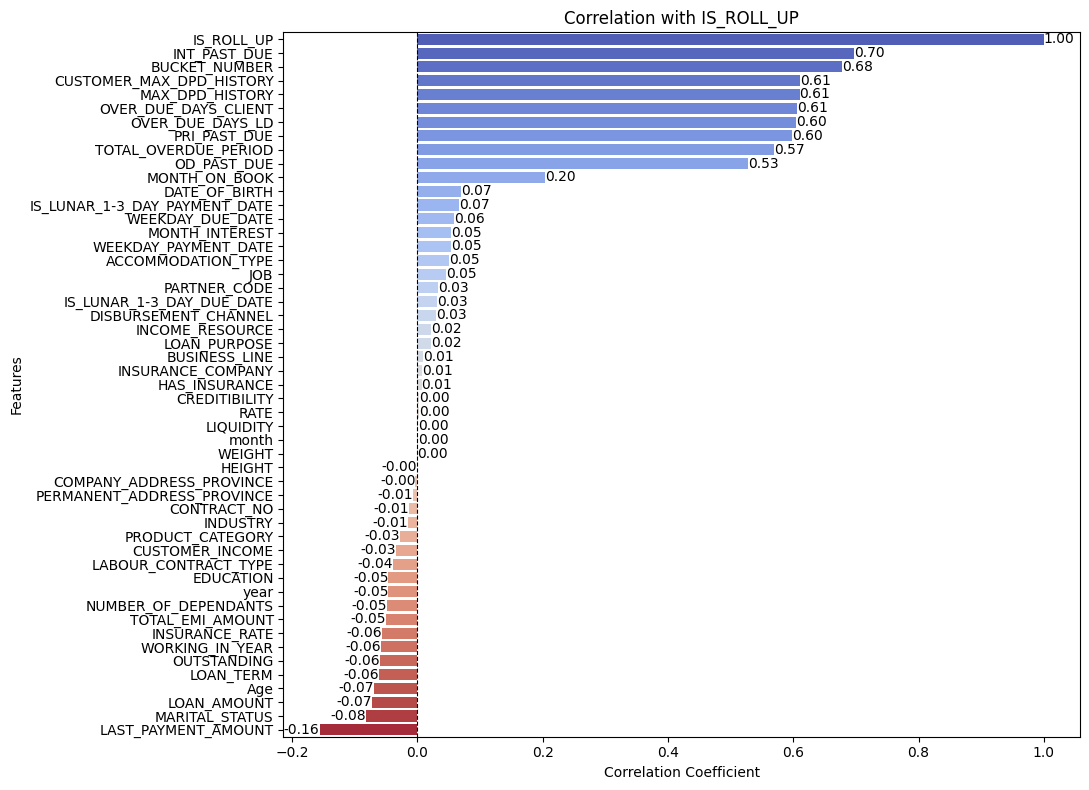

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_columns = df.select_dtypes(include=np.number)

# Calculate correlation with 'IS_ROLL_UP'
corr_with_target = numeric_columns.corr(method='pearson')['IS_ROLL_UP'].sort_values(ascending=False)

# Convert correlation series to DataFrame for better visualization
corr_with_target_df = corr_with_target.reset_index()
corr_with_target_df.columns = ['Feature', 'Correlation']

# Plot the correlation as a bar chart
plt.figure(figsize=(11, 8))
sns.barplot(data=corr_with_target_df, x='Correlation', y='Feature', palette='coolwarm')

# Annotate the bars with the correlation values rounded to 2 decimal places
for index, row in corr_with_target_df.iterrows():
    plt.text(
        row['Correlation'],  # X-coordinate (correlation value)
        index,  # Y-coordinate (position of the bar)
        f"{row['Correlation']:.2f}",  # Format to 2 decimal places
        color='black',  # Text color
        ha='left' if row['Correlation'] >= 0 else 'right',  # Align text based on positive/negative value
        va='center'  # Align text vertically
    )

plt.title('Correlation with IS_ROLL_UP')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)  # Add a reference line at 0
plt.tight_layout()
plt.show()


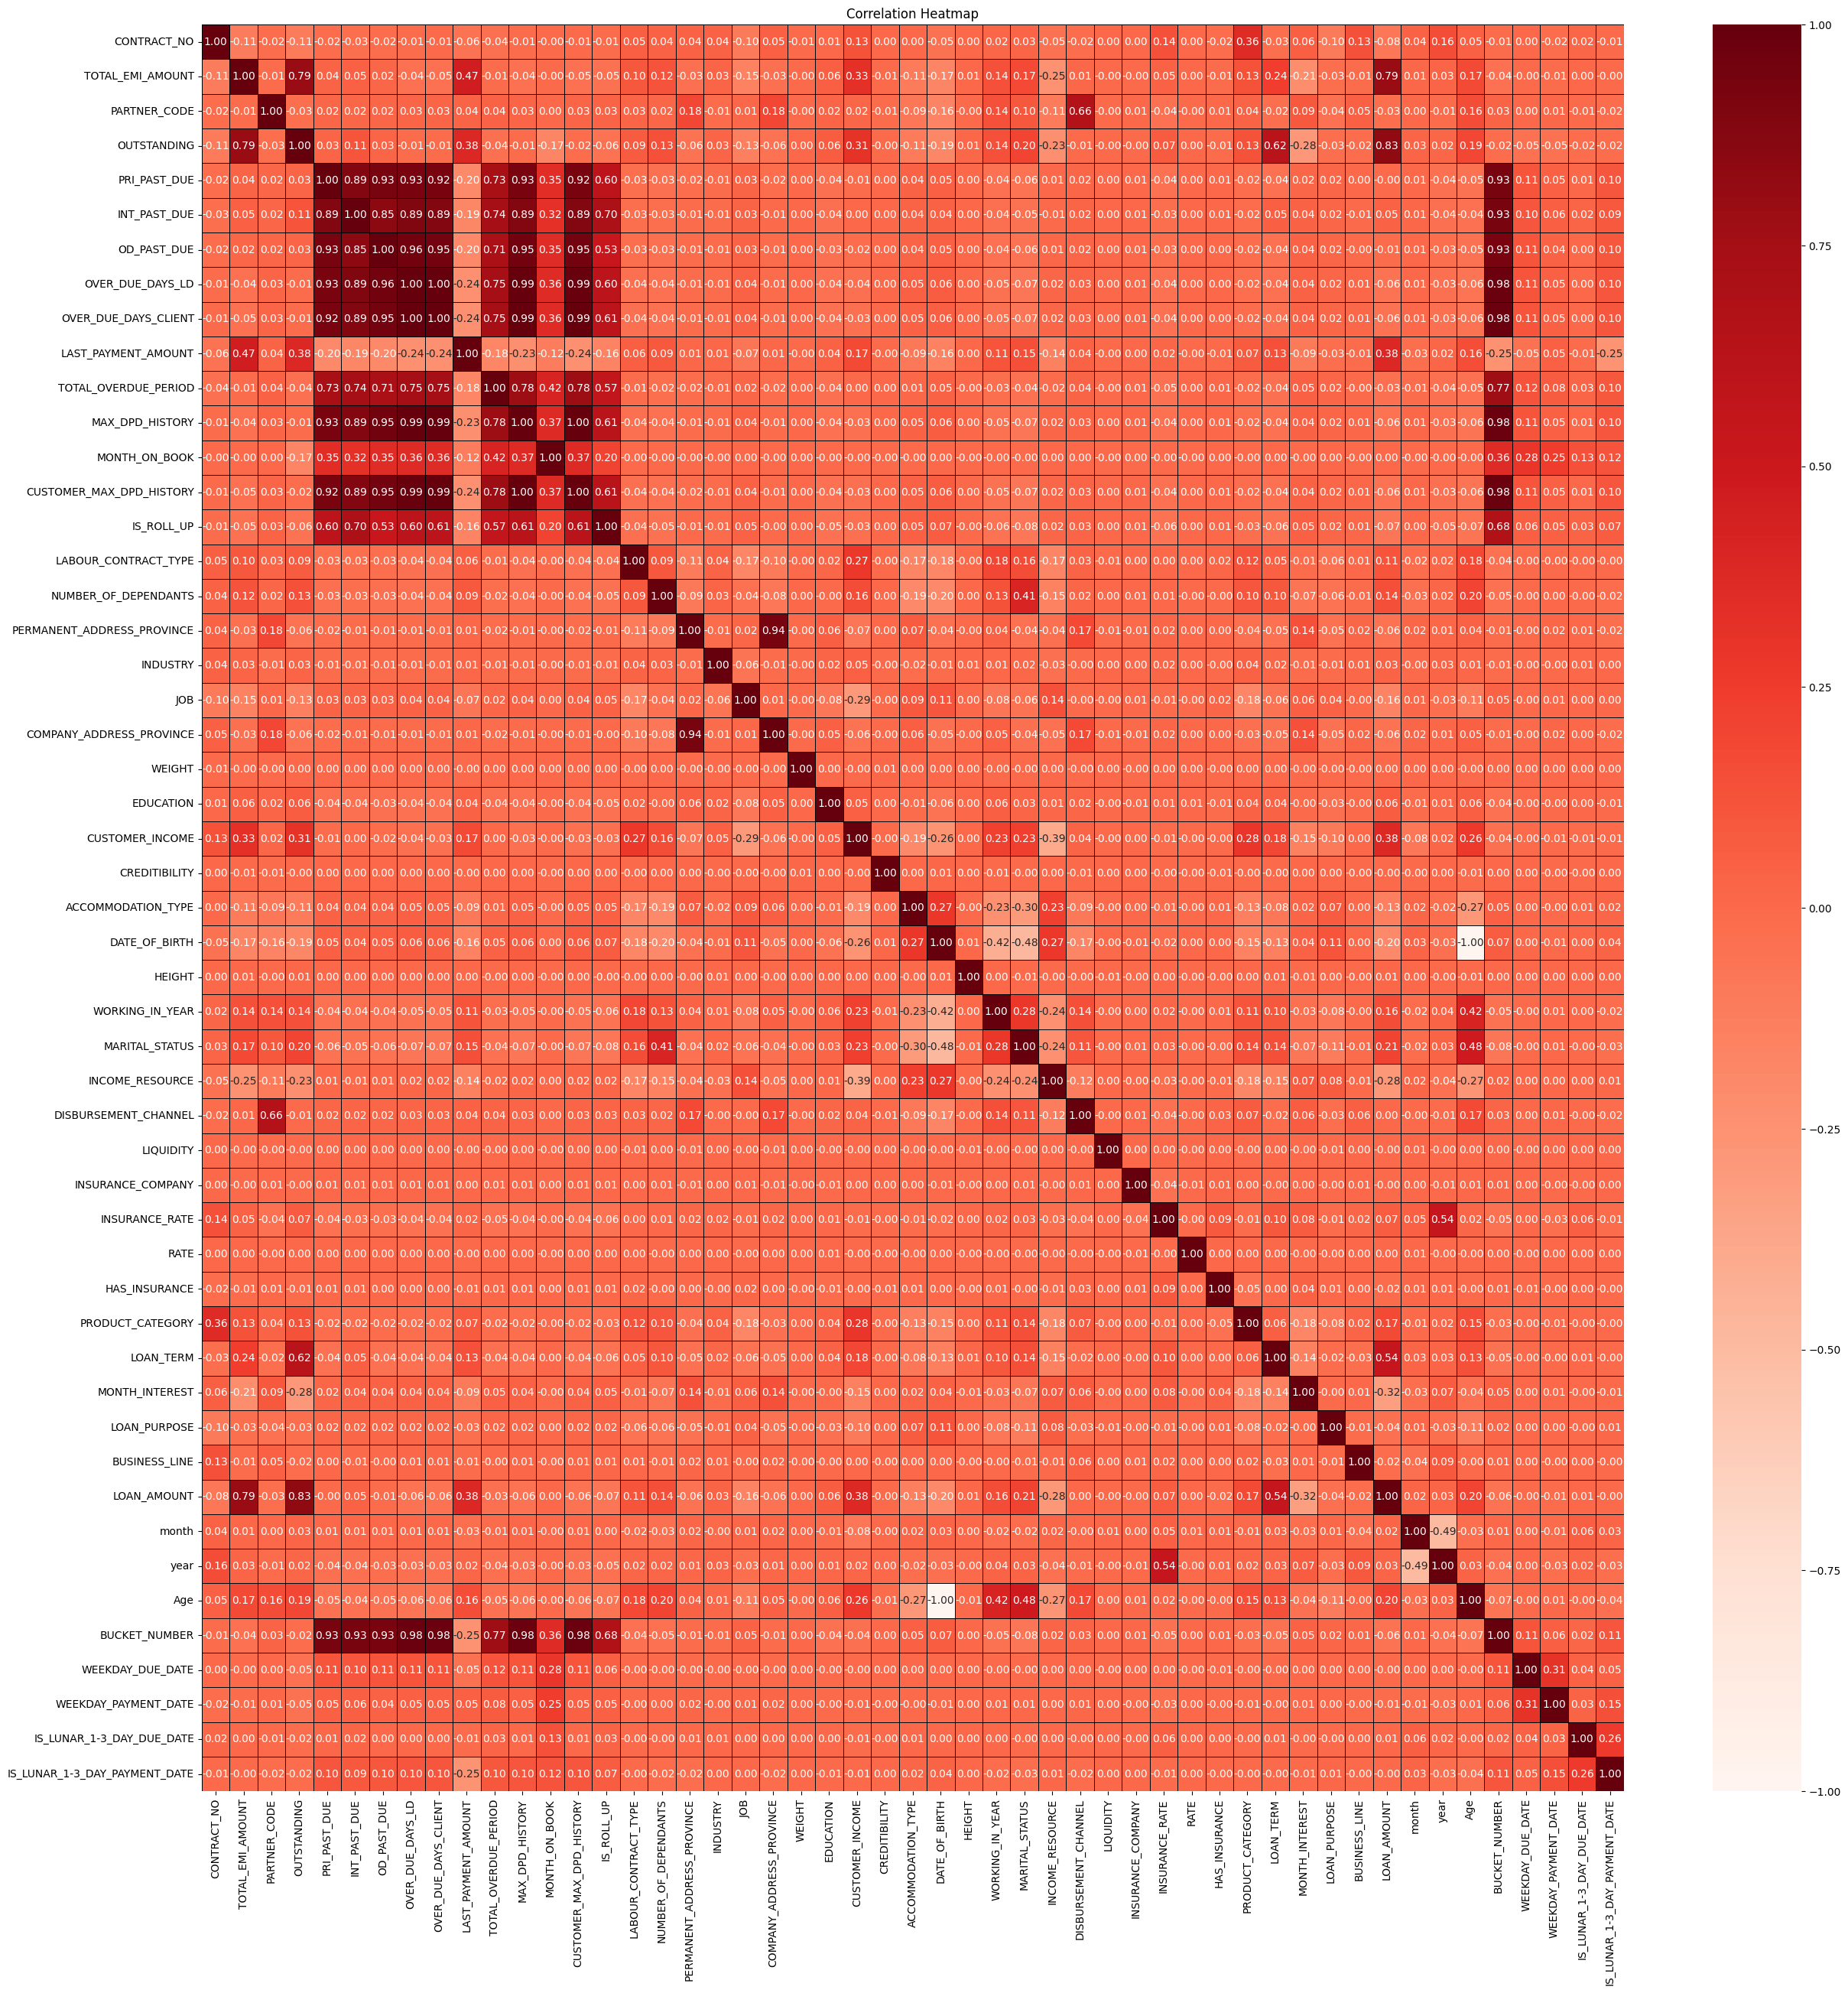

In [ ]:
# Calculate correlation matrix
# Select only numeric columns for correlation
corr_matrix = df.select_dtypes(include=np.number).corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True,cmap='Reds', linecolor='black',fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Feature Selection

#### Selecting features

In [ ]:
df_selection = df[[
    # Target variable
    'IS_ROLL_UP',

    # Demographic
    'MARITAL_STATUS',  # -0.08
    'Age',             # 0.20
    'NUMBER_OF_DEPENDANTS',  # -0.05
    'CUSTOMER_INCOME',       # -0.03
    'WORKING_IN_YEAR',

    # Loan Information
    'LOAN_AMOUNT',     # -0.07
    'LOAN_TERM',       # -0.06
    'MONTH_INTEREST',  # 0.05
    'PRODUCT_CATEGORY',    # -0.03
    'LOAN_PURPOSE',


    # Loan Repayment
    'MONTH_ON_BOOK',   # 0.53
    'TOTAL_EMI_AMOUNT',      # -0.05
    # 'PARTNER_CODE',        # 0.03
    'OUTSTANDING',           # -0.06
    'PRI_PAST_DUE',          # 0.60
    'INT_PAST_DUE',          # 0.70
    'OD_PAST_DUE',           # 0.60
    'OVER_DUE_DAYS_LD',      # 0.60
    # 'OVER_DUE_DAYS_CLIENT',  # 0.61 Không chọn vì mục tiêu liên quan đến hợp đồng hơn
    'LAST_PAYMENT_AMOUNT',   # -0.16
    'TOTAL_OVERDUE_PERIOD',  # 0.57
    'MAX_DPD_HISTORY',       # 0.61
    # 'CUSTOMER_MAX_DPD_HISTORY',  # 0.61

    # Behavior
    # 'WEEKDAY_DUE_DATE',      # 0.06
    'WEEKDAY_PAYMENT_DATE',  # 0.05
    'IS_LUNAR_1-3_DAY_DUE_DATE',  # 0.0
    'IS_LUNAR_1-3_DAY_PAYMENT_DATE'
]]



#### Evaluate selected

In [ ]:
# # kiểm tra và loại bỏ đa cộng tuyến (chứa thông tin như nhau)

# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Kiểm tra đa cộng tuyến

# X_selected = df_selection.dropna()

# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_selected.columns
# vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

# print(vif_data)


### Split data into predict and model data

In [ ]:
# Tách các dòng có IS_ROLL_UP là NaN (dòng cần dự đoán)
df_to_predict = df_selection[df_selection['IS_ROLL_UP'].isna()]

# Tách các dòng có IS_ROLL_UP không phải NaN (dòng để huấn luyện mô hình)
df_to_model = df_selection[df_selection['IS_ROLL_UP'].notna()]

# Kiểm tra kết quả
print("Rows in df_to_predict:", len(df_to_predict))
print("Rows in df_to_model:", len(df_to_model))


Rows in df_to_predict: 87458
Rows in df_to_model: 787122


### Split data: train, test, predict

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_to_model.drop(columns=['IS_ROLL_UP'], axis=1)
y = df_to_model['IS_ROLL_UP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_predict = df_to_predict.drop(columns=['IS_ROLL_UP'], axis=1)

### Address Imbalance in IS_ROLL_UP USING OVERSAMPLING

In [ ]:
y_train.value_counts()

IS_ROLL_UP
0.0    484859
1.0    144838
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling
smote = SMOTE()
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

# Check the distribution of the target variable after oversampling
unique, counts = np.unique(y_SMOTE, return_counts=True)
print(dict(zip(unique, counts)))

# Combine the resampled features and target into a new DataFrame
df_SMOTE = pd.concat([pd.DataFrame(X_SMOTE, columns=X.columns), pd.DataFrame(y_SMOTE, columns=['IS_ROLL_UP'])], axis=1)


{0.0: 484859, 1.0: 484859}


### Scale data

In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Khởi tạo scaler
scaler = StandardScaler()

# 2. Fit scaler trên dữ liệu train
scaler.fit(X_SMOTE)

# 3. Transform dữ liệu train và test
X_train_scaled = scaler.transform(X_SMOTE)
X_test_scaled = scaler.transform(X_test)

# 4. Transform dữ liệu predict (bạn không fit lại, chỉ transform)
X_predict_scaled = scaler.transform(X_predict)


## **2. Modeling**

#### Logistic Regression

##### Tunning hyperparameter

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo Logistic Regression
log = LogisticRegression(random_state=42, max_iter=1000)

# Tập tham số cần tìm
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],              # Regularization types
    'solver': ['liblinear', 'saga'],      # Solvers phù hợp với penalty
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=log,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params = random_search.best_params_
print("Best Parameters: ", best_params)

# Mô hình tối ưu
best_model_log = random_search.best_estimator_


NameError: name 'X_train_scaled' is not defined

Best Parameters:  {'solver': 'saga', 'penalty': 'l1', 'C': 100}

##### Cross Validation + Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Hàm tính GINI
def calculate_gini(y_true, y_proba):
    auc = roc_auc_score(y_true, y_proba)
    return 2 * auc - 1

# Hàm tính KS
def calculate_ks(y_true, y_proba):
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba', ascending=False)
    data['cum_good'] = (data['y_true'] == 0).cumsum() / (data['y_true'] == 0).sum()
    data['cum_bad'] = (data['y_true'] == 1).cumsum() / (data['y_true'] == 1).sum()
    return (data['cum_bad'] - data['cum_good']).max()

# Hàm tính PSI
def calculate_psi(expected, actual, bins=10):
    expected_percents, bins = np.histogram(expected, bins=bins, density=True)
    actual_percents, _ = np.histogram(actual, bins=bins, density=True)

    psi = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
    return psi

# Hàm tổng hợp metrics
def evaluate_model(model_name, y_true, y_proba, train_proba=None):
    auc = roc_auc_score(y_true, y_proba)
    gini = calculate_gini(y_true, y_proba)
    ks = calculate_ks(y_true, y_proba)
    psi = calculate_psi(train_proba, y_proba, bins=10) if train_proba is not None else None

    return {
        'Model': model_name,
        'AUC': auc,
        'GINI': gini,
        'KS': ks,
        'PSI': psi
    }


In [ ]:
from sklearn.model_selection import cross_val_score

# Hàm tổng hợp metrics, thêm mean cross-validation score
def evaluate_model(model_name, model, X_train, y_train, y_true, y_proba, train_proba=None, cv=5):
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    mean_cv_score = cv_scores.mean()

    # AUC, GINI, KS
    auc = roc_auc_score(y_true, y_proba)
    gini = calculate_gini(y_true, y_proba)
    ks = calculate_ks(y_true, y_proba)
    psi = calculate_psi(train_proba, y_proba, bins=10) if train_proba is not None else None

    return {
        'Model': model_name,
        'Mean CV AUC': mean_cv_score,
        'AUC': auc,
        'GINI': gini,
        'KS': ks,
        'PSI': psi
    }


In [ ]:
# Khởi tạo danh sách lưu kết quả
results = []

# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_log.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_log.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình Logistic Regression
logistic_metrics = evaluate_model(
    model_name="Logistic Regression",
    model=best_model_log,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(logistic_metrics)


#### Decision Tree

##### Tunning hyperparameter

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Tập tham số cần tìm
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],   # Hàm đo độ thuần khiết
    'max_depth': [None, 5, 10, 20, 30, 50],         # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],                # Số lượng mẫu tối thiểu để chia một node
    'min_samples_leaf': [1, 2, 4],                  # Số lượng mẫu tối thiểu trong một node lá
    'max_features': ['sqrt', 'log2', None],         # Số lượng đặc trưng được xem xét tại mỗi split
    'splitter': ['best', 'random']                  # Cách chọn điểm chia
}

# RandomizedSearchCV cho Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search_dt.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params_dt = random_search_dt.best_params_
print("Best Parameters for Decision Tree: ", best_params_dt)

# Mô hình tối ưu
best_model_dt = random_search_dt.best_estimator_


{'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}

##### Cross Validation + Evaluation

In [ ]:
# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_dt.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_dt.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình Decision Tree
dt_metrics = evaluate_model(
    model_name="Decision Tree",
    model=best_model_dt,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(dt_metrics)


#### XGBoost

##### Tunning hyperparameter

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Tập tham số cần tìm
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],       # Số lượng cây
    'max_depth': [3, 5, 7, 10],                     # Độ sâu tối đa của cây
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        # Tốc độ học
    'subsample': [0.6, 0.8, 1.0],                   # Tỷ lệ mẫu cho mỗi cây
    'colsample_bytree': [0.6, 0.8, 1.0],            # Tỷ lệ đặc trưng cho mỗi cây
    'gamma': [0, 0.1, 0.2, 0.5],                    # Điều kiện giảm độ thuần của node
    'reg_alpha': [0, 0.1, 0.5, 1],                  # Regularization L1
    'reg_lambda': [1, 1.5, 2, 3],                   # Regularization L2
}

# RandomizedSearchCV cho XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search_xgb.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params_xgb = random_search_xgb.best_params_
print("Best Parameters for XGBoost: ", best_params_xgb)

# Mô hình tối ưu
best_model_xgb = random_search_xgb.best_estimator_


{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}

##### Cross Validation + Evaluation

In [ ]:
# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_xgb.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_xgb.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình XGBoost
xgb_metrics = evaluate_model(
    model_name="XGBoost",
    model=best_model_xgb,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(xgb_metrics)


#### LightGBM

##### Tunning hyperparameter

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo LightGBM
lgbm = LGBMClassifier(random_state=42)

# Tập tham số cần tìm
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],       # Số lượng cây
    'max_depth': [3, 5, 10, 20],                   # Độ sâu tối đa của cây
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        # Tốc độ học
    'num_leaves': [10, 20, 31, 40],                 # Số lượng lá tối đa trong cây
    'min_child_samples': [10, 20, 50],              # Số lượng mẫu tối thiểu trong một node lá
    'subsample': [0.6, 0.8, 1.0],                   # Tỷ lệ mẫu cho mỗi cây
    'colsample_bytree': [0.6, 0.8, 1.0],            # Tỷ lệ đặc trưng cho mỗi cây
    'reg_alpha': [0, 0.1, 0.5, 1],                  # Regularization L1
    'reg_lambda': [1, 1.5, 2, 3],                   # Regularization L2
}

# RandomizedSearchCV cho LightGBM
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,         # Số lần thử nghiệm
    scoring='roc_auc', # Đánh giá dựa trên AUC
    cv=5,              # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit trên tập train
random_search_lgbm.fit(X_train_scaled, y_SMOTE)

# Lấy tham số tốt nhất
best_params_lgbm = random_search_lgbm.best_params_
print("Best Parameters for LightGBM: ", best_params_lgbm)

# Mô hình tối ưu
best_model_lgbm = random_search_lgbm.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 484859, number of negative: 484859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4503
[LightGBM] [Info] Number of data points in the train set: 969718, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

  {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}

##### Cross Validation + Evaluation

In [ ]:
# Dự đoán xác suất trên tập test và tập train
y_pred_proba = best_model_lgbm.predict_proba(X_test_scaled)[:, 1]
train_proba = best_model_lgbm.predict_proba(X_train_scaled)[:, 1]

# Đánh giá mô hình Decision Tree
lgbm_metrics = evaluate_model(
    model_name="LightGBM",
    model=best_model_lgbm,
    X_train=X_train_scaled,
    y_train=y_SMOTE,
    y_true=y_test,
    y_proba=y_pred_proba,
    train_proba=train_proba,
    cv=5  # Số lần cross-validation
)

# Thêm kết quả vào danh sách
results.append(lgbm_metrics)


[LightGBM] [Info] Number of positive: 387887, number of negative: 387887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4508
[LightGBM] [Info] Number of data points in the train set: 775774, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

## Choosing the best model

In [ ]:
# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.drop_duplicates(subset=['Model'])
results_df

Model  Mean CV AUC       AUC      GINI       KS       PSI
0  LightGBM     0.981645  0.938578  0.877156  0.76007  4.900286

In [ ]:
from lightgbm import LGBMClassifier

# Define the LightGBM model with the given parameters

best_model_lgbm = LGBMClassifier(
    subsample= 0.6,
    reg_lambda=3,
    reg_alpha=0,
    num_leaves=20,
    n_estimators=500,
    min_child_samples=20,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8,
    random_state=42
)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
best_model = best_model_lgbm
print("Best Model:", best_model)

Best Model: LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=5,
               n_estimators=500, num_leaves=20, random_state=42, reg_alpha=0,
               reg_lambda=3, subsample=0.6)


In [ ]:
best_model.fit(X_train_scaled, y_SMOTE)


[LightGBM] [Info] Number of positive: 484859, number of negative: 484859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 969718, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=5,
               n_estimators=500, num_leaves=20, random_state=42, reg_alpha=0,
               reg_lambda=3, subsample=0.6)

## **3. Prediction - Use K means Clustering to Label credit ratings**

### Predicted probability

In [ ]:
# Predict probabilities for the new data
df_to_predict['PREDICTED_PROBABILITY'] = best_model.predict_proba(X_predict_scaled)[:, 1]

<ipython-input-118-4c7e02ce058d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['PREDICTED_PROBABILITY'] = best_model.predict_proba(X_predict_scaled)[:, 1]


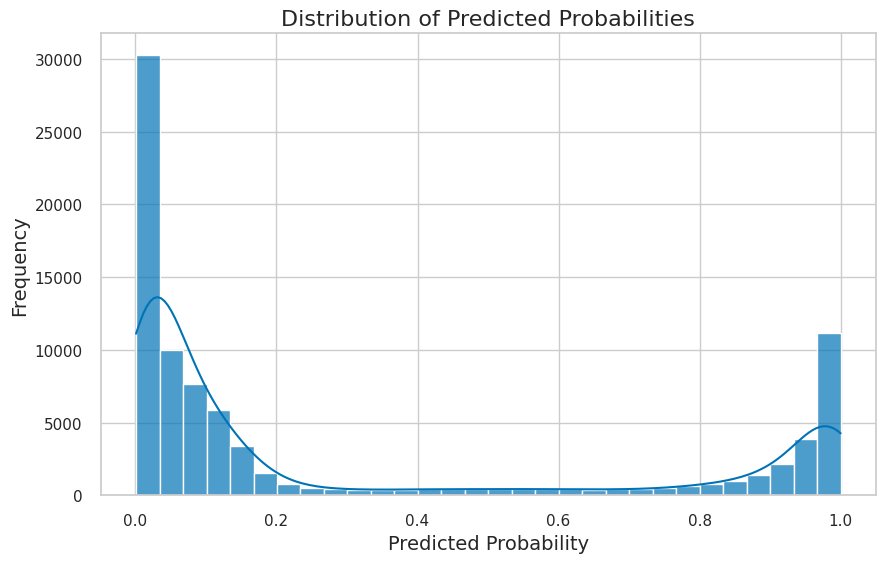

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Define the custom color
custom_color = "#0073b7"  # Replace with the HEX code of your desired color

# Plot the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(df_to_predict['PREDICTED_PROBABILITY'], bins=30, kde=True, color=custom_color, alpha=0.7)

# Add titles and labels
plt.title("Distribution of Predicted Probabilities", fontsize=16)
plt.xlabel("Predicted Probability", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Display the plot
plt.show()


## Kmeans for dividing score band

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Lấy dữ liệu xác suất từ DataFrame
probabilities = df_to_predict['PREDICTED_PROBABILITY'].values.reshape(-1, 1)

# Áp dụng K-Means với số cụm (clusters) phù hợp
kmeans = KMeans(n_clusters=9, random_state=42)
df_to_predict['CLUSTER'] = kmeans.fit_predict(probabilities)

# Kiểm tra trung tâm các cụm để hiểu cách phân nhóm
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers: ", cluster_centers)


Cluster Centers:  [[0.08668339]
 [0.81162322]
 [0.16295532]
 [0.50065275]
 [0.98561689]
 [0.02195455]
 [0.66162352]
 [0.33052912]
 [0.91704989]]


<ipython-input-176-8036e319a54d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['CLUSTER'] = kmeans.fit_predict(probabilities)


In [ ]:
# Sắp xếp cụm theo giá trị trung tâm để gán nhãn từ 'AAA' đến 'C'
cluster_order = np.argsort(cluster_centers.flatten())
score_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C']  # Bạn có thể thay đổi nhãn theo nhu cầu

# Tạo map để chuyển cụm thành nhãn
cluster_to_label = {cluster_order[i]: score_labels[i] for i in range(len(score_labels))}
df_to_predict['SCORE_BAND'] = df_to_predict['CLUSTER'].map(cluster_to_label)

# Xóa cột 'CLUSTER' nếu không cần thiết
df_to_predict.drop(columns=['CLUSTER'], inplace=True)

# Kiểm tra kết quả
print(df_to_predict[['PREDICTED_PROBABILITY', 'SCORE_BAND']].head())


    PREDICTED_PROBABILITY SCORE_BAND
9                0.062768         AA
19               0.736009          B
29               0.068563         AA
39               0.148154          A
49               0.982658          C


<ipython-input-177-10f91200ac7a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['SCORE_BAND'] = df_to_predict['CLUSTER'].map(cluster_to_label)
<ipython-input-177-10f91200ac7a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict.drop(columns=['CLUSTER'], inplace=True)


<ipython-input-195-003872e8117a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['TEMP_SCORE_BAND'] = df_to_predict.apply(adjust_score_band, axis=1)
<ipython-input-195-003872e8117a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict['ADJUSTED_SCORE_BAND'] = df_to_predict.apply(adjust_high_risk_to_lower, axis=1)
<ipython-input-195-003872e8117a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

ADJUSTED_SCORE_BAND
AAA    34441
C      13306
AA     11073
CC      9355
CCC     8921
B       3181
A       2676
BBB     2605
BB      1900
Name: count, dtype: int64


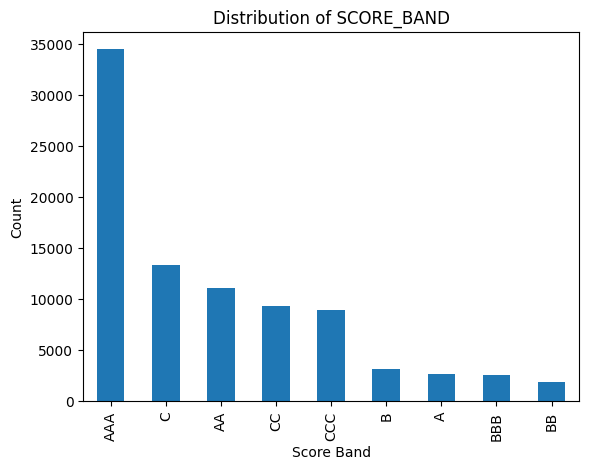

In [ ]:
# Hàm điều chỉnh SCORE_BAND với nhóm AAA, AA, A và nhóm rủi ro cao
def adjust_score_band(row):
    # Điều chỉnh nhóm rủi ro cao nhất
    if row['OVER_DUE_DAYS_LD'] > 200 or row['TOTAL_OVERDUE_PERIOD'] > 10:
        return 'C'
    elif row['OVER_DUE_DAYS_LD'] > 150 or row['TOTAL_OVERDUE_PERIOD'] > 8:
        return 'CC'
    elif row['OVER_DUE_DAYS_LD'] > 100 or row['TOTAL_OVERDUE_PERIOD'] > 6:
        return 'CCC'
    return row['SCORE_BAND']

# Áp dụng quy tắc điều chỉnh bước đầu
df_to_predict['TEMP_SCORE_BAND'] = df_to_predict.apply(adjust_score_band, axis=1)

# Hàm điều chỉnh nhóm rủi ro cao xuống nhóm thấp hơn nếu các giá trị thấp
def adjust_high_risk_to_lower(row):
    if row['TEMP_SCORE_BAND'] in ['CCC', 'CC', 'C']:  # Chỉ điều chỉnh nhóm rủi ro cao
        if row['OVER_DUE_DAYS_LD'] <= 50 and row['TOTAL_OVERDUE_PERIOD'] <= 4:
            return 'BBB'
        elif row['OVER_DUE_DAYS_LD'] <= 70 and row['TOTAL_OVERDUE_PERIOD'] <= 5:
            return 'BB'
        elif row['OVER_DUE_DAYS_LD'] <= 100 and row['TOTAL_OVERDUE_PERIOD'] <= 6:
            return 'B'
    return row['TEMP_SCORE_BAND']  # Giữ nguyên nếu không thuộc nhóm cần điều chỉnh

# Áp dụng quy tắc điều chỉnh nhóm rủi ro cao
df_to_predict['ADJUSTED_SCORE_BAND'] = df_to_predict.apply(adjust_high_risk_to_lower, axis=1)

# Xóa cột tạm nếu không cần thiết
df_to_predict.drop(columns=['TEMP_SCORE_BAND'], inplace=True)

# Kiểm tra phân phối các nhóm sau điều chỉnh
adjusted_distribution = df_to_predict['ADJUSTED_SCORE_BAND'].value_counts()
print(adjusted_distribution)

# Trực quan hóa kết quả
df_to_predict['ADJUSTED_SCORE_BAND'].value_counts().plot(kind='bar')
plt.title("Distribution of SCORE_BAND")
plt.xlabel("Score Band")
plt.ylabel("Count")
plt.show()


## Visualization

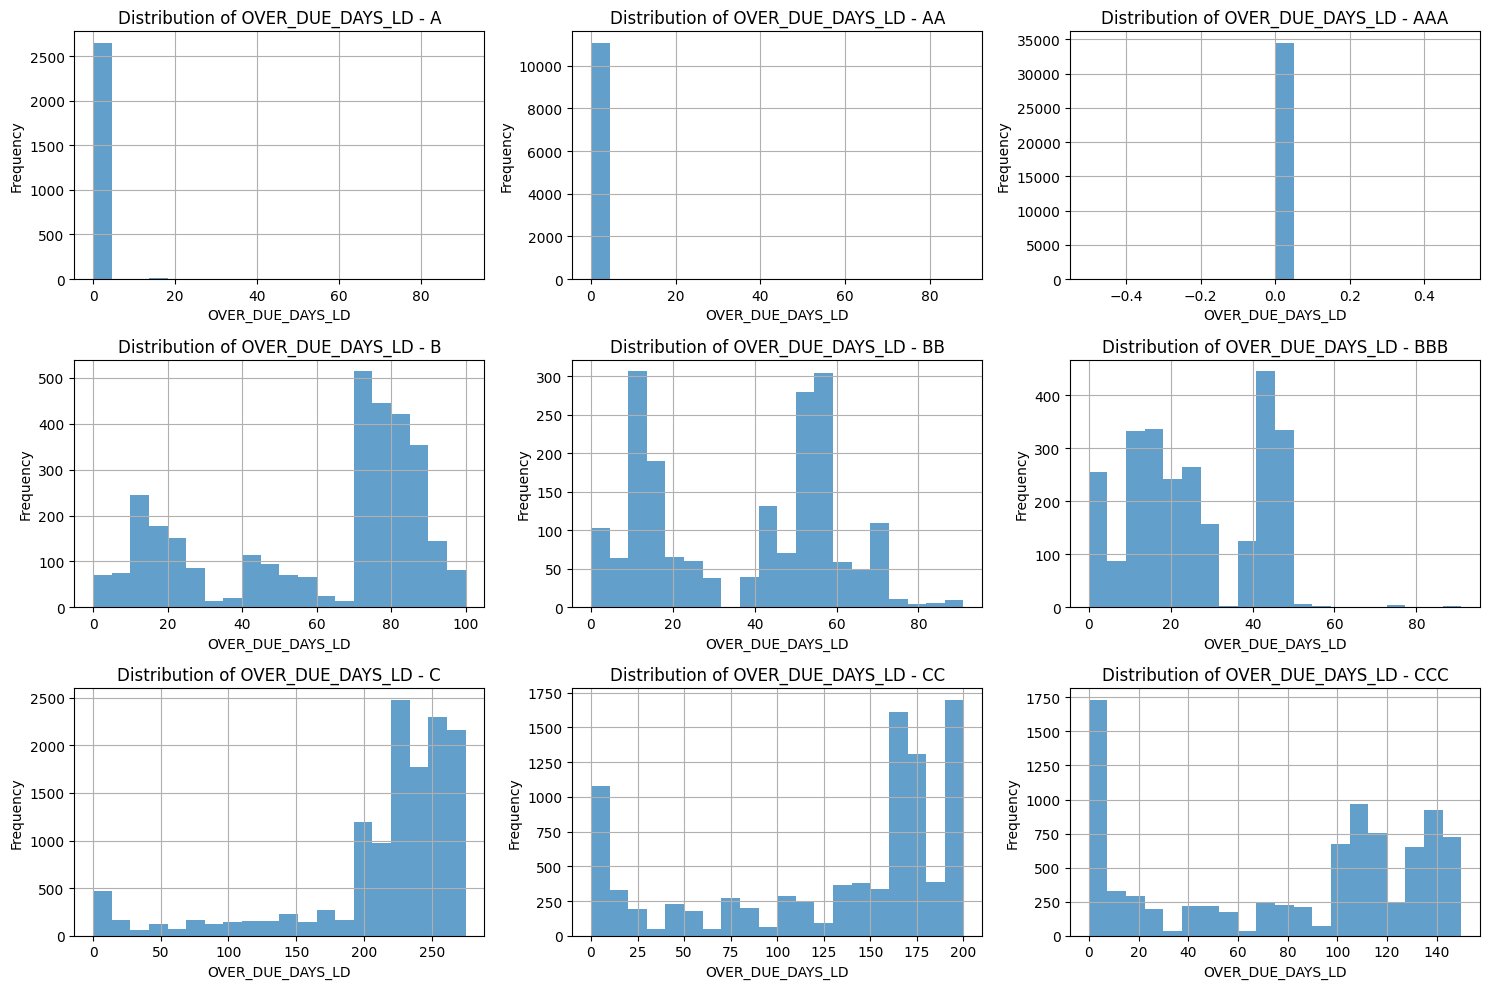

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ phân phối cho từng nhóm SCORE_BAND
score_bands = df_to_predict['ADJUSTED_SCORE_BAND'].unique()  # Các nhóm từ AAA đến C

# Thiết lập kích thước tổng thể
plt.figure(figsize=(15, 10))

# Lặp qua từng nhóm và vẽ histogram
for i, band in enumerate(sorted(score_bands), 1):
    plt.subplot(3, 3, i)  # Bố trí lưới 3x3 (có thể điều chỉnh nếu số nhóm khác)
    df_to_predict['OVER_DUE_DAYS_LD'][df_to_predict['ADJUSTED_SCORE_BAND'] == band].hist(bins=20, alpha=0.7)
    plt.title(f"Distribution of OVER_DUE_DAYS_LD - {band}")
    plt.xlabel('OVER_DUE_DAYS_LD')
    plt.ylabel('Frequency')

plt.tight_layout()  # Tự động căn chỉnh các biểu đồ
plt.show()


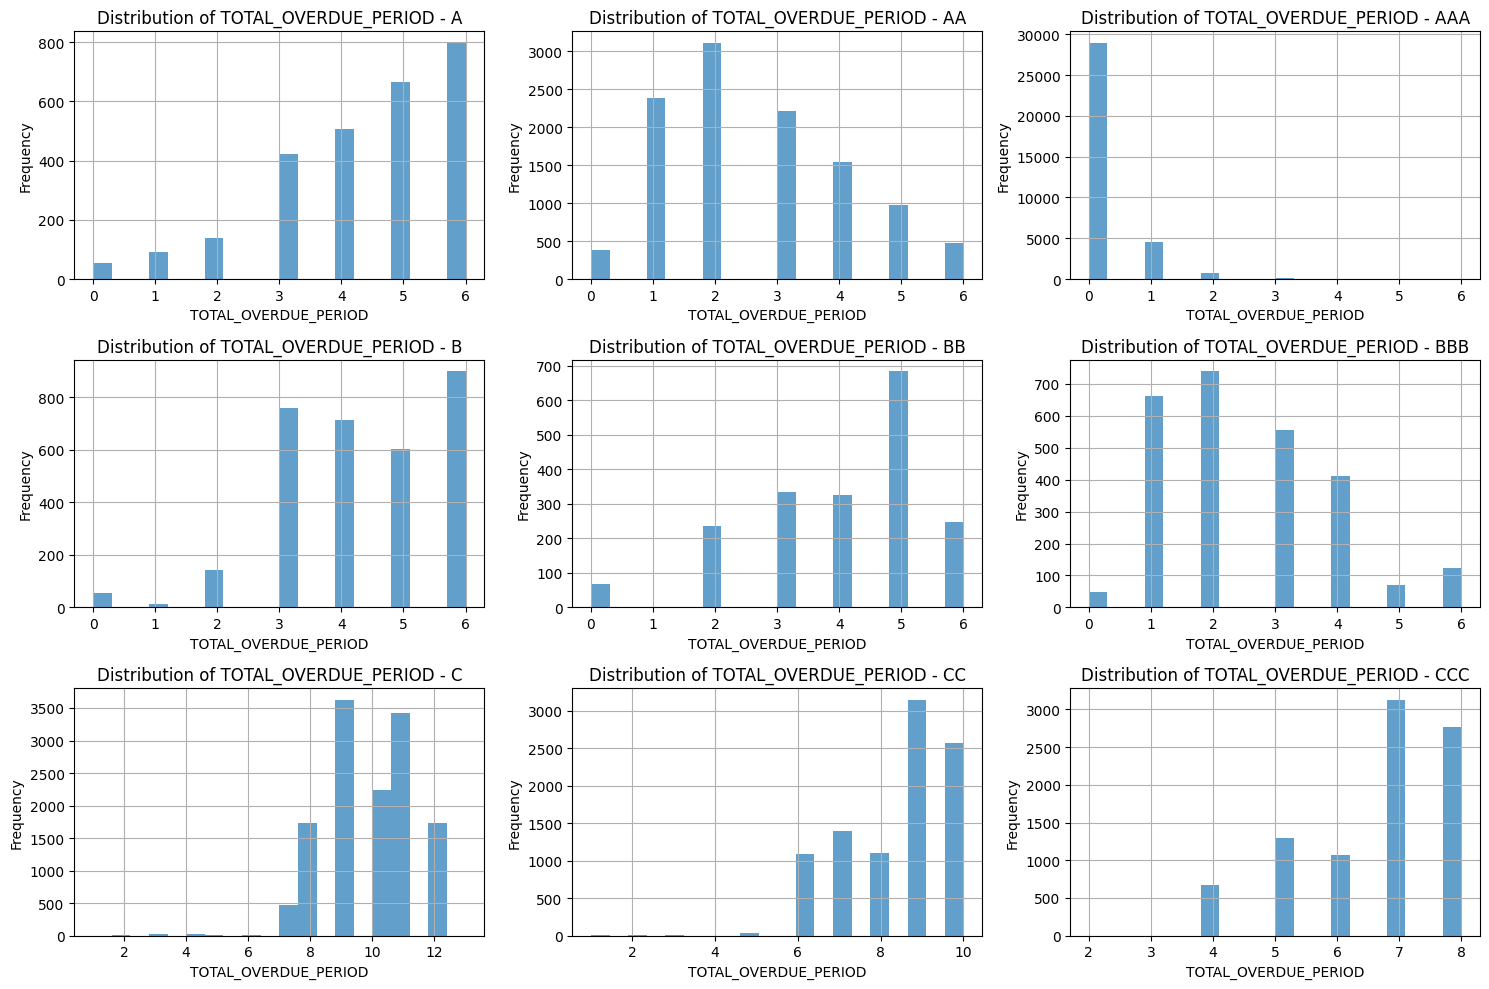

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ phân phối cho từng nhóm SCORE_BAND
score_bands = df_to_predict['ADJUSTED_SCORE_BAND'].unique()  # Các nhóm từ AAA đến C

# Thiết lập kích thước tổng thể
plt.figure(figsize=(15, 10))

# Lặp qua từng nhóm và vẽ histogram
for i, band in enumerate(sorted(score_bands), 1):
    plt.subplot(3, 3, i)  # Bố trí lưới 3x3 (có thể điều chỉnh nếu số nhóm khác)
    df_to_predict['TOTAL_OVERDUE_PERIOD'][df_to_predict['ADJUSTED_SCORE_BAND'] == band].hist(bins=20, alpha=0.7)
    plt.title(f"Distribution of TOTAL_OVERDUE_PERIOD - {band}")
    plt.xlabel('TOTAL_OVERDUE_PERIOD')
    plt.ylabel('Frequency')

plt.tight_layout()  # Tự động căn chỉnh các biểu đồ
plt.show()


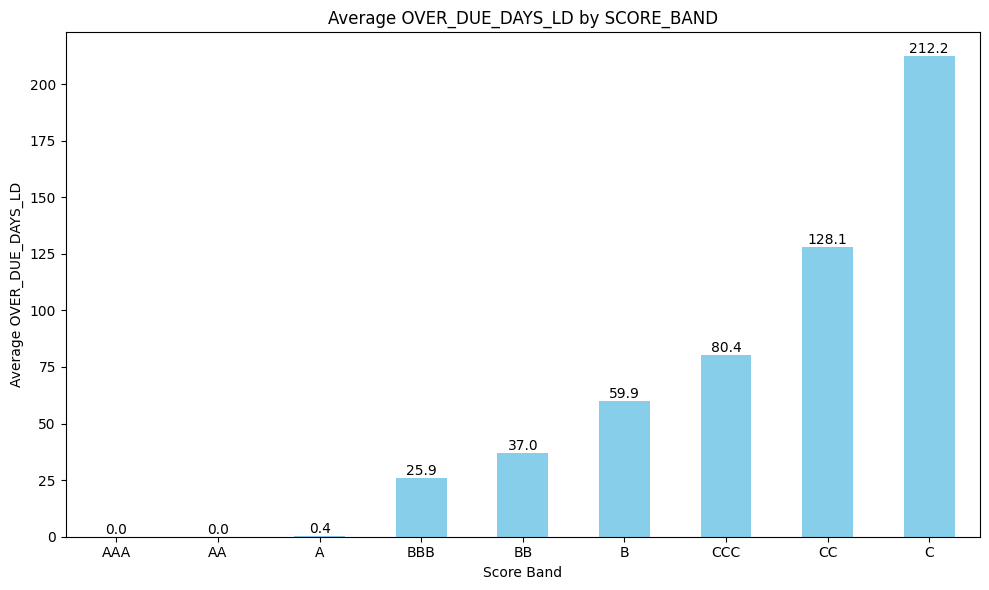

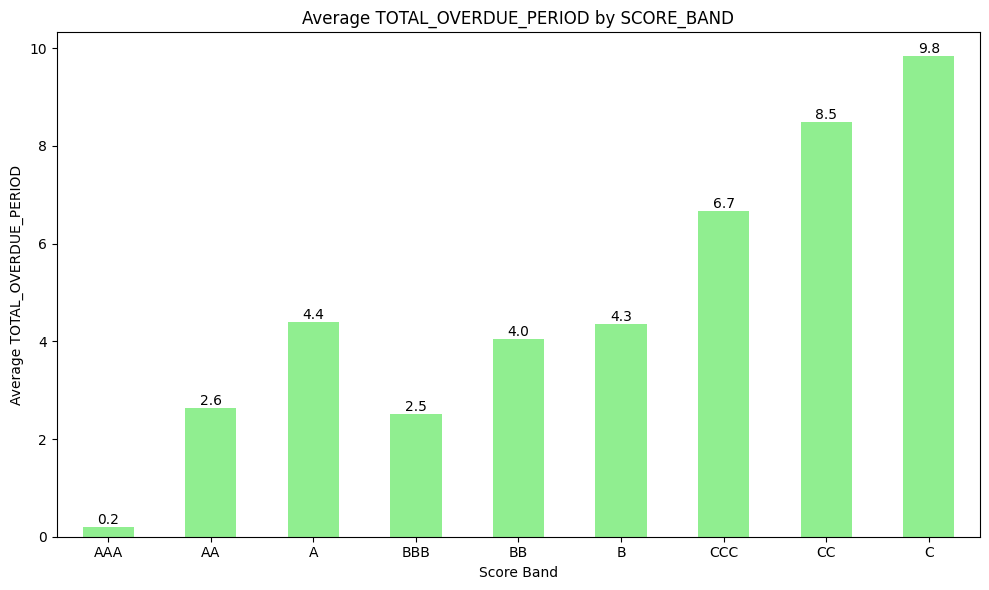

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Tạo thứ tự nhóm cụ thể
score_band_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C']

# Tính giá trị trung bình của OVER_DUE_DAYS_LD và TOTAL_OVERDUE_PERIOD theo nhóm
average_metrics = df_to_predict.groupby('ADJUSTED_SCORE_BAND')[['OVER_DUE_DAYS_LD', 'TOTAL_OVERDUE_PERIOD']].mean()

# Sắp xếp theo thứ tự cụ thể
average_metrics = average_metrics.reindex(score_band_order)

# Biểu đồ 1: Average_OVER_DUE_DAYS_LD
plt.figure(figsize=(10, 6))
ax = average_metrics['OVER_DUE_DAYS_LD'].plot(kind='bar', color='skyblue', legend=False)
plt.title('Average OVER_DUE_DAYS_LD by SCORE_BAND')
plt.xlabel('Score Band')
plt.ylabel('Average OVER_DUE_DAYS_LD')
plt.xticks(rotation=0)
plt.tight_layout()

# Thêm số ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

# Biểu đồ 2: Average_TOTAL_OVERDUE_PERIOD
plt.figure(figsize=(10, 6))
ax = average_metrics['TOTAL_OVERDUE_PERIOD'].plot(kind='bar', color='lightgreen', legend=False)
plt.title('Average TOTAL_OVERDUE_PERIOD by SCORE_BAND')
plt.xlabel('Score Band')
plt.ylabel('Average TOTAL_OVERDUE_PERIOD')
plt.xticks(rotation=0)
plt.tight_layout()

# Thêm số ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()


## **4. Clustering**

## Feature Selection

In [ ]:
df_to_predict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87458 entries, 9 to 1030019
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   IS_ROLL_UP                     0 non-null      float64
 1   MARITAL_STATUS                 87458 non-null  float64
 2   Age                            87458 non-null  float64
 3   NUMBER_OF_DEPENDANTS           87458 non-null  float64
 4   CUSTOMER_INCOME                87458 non-null  float64
 5   WORKING_IN_YEAR                87458 non-null  float64
 6   LOAN_AMOUNT                    87458 non-null  float64
 7   LOAN_TERM                      87458 non-null  float64
 8   MONTH_INTEREST                 87458 non-null  float64
 9   PRODUCT_CATEGORY               87458 non-null  float64
 10  LOAN_PURPOSE                   87458 non-null  float64
 11  MONTH_ON_BOOK                  87458 non-null  float64
 12  TOTAL_EMI_AMOUNT               87458 non-null  fl

In [ ]:
df_kmeans = df_to_predict.copy()

In [ ]:
df_kmeans.drop(columns=['PREDICTED_PROBABILITY', 'IS_ROLL_UP'], inplace=True)

In [ ]:
# Redefine the DPD bucket classification function, as the environment has reset
def classify_numberic_dpd_bucket(days_overdue):
    if days_overdue == 0:
        return 0
    elif 1 <= days_overdue <= 9:
        return 1
    elif 10 <= days_overdue <= 30:
        return 2
    elif 31 <= days_overdue <= 60:
        return 3
    elif 61 <= days_overdue <= 90:
        return 4
    elif 91 <= days_overdue <= 120:
        return 5
    elif 121 <= days_overdue <= 150:
        return 6
    elif 151 <= days_overdue <= 180:
        return 7
    elif 181 <= days_overdue <= 210:
        return 8
    elif 211 <= days_overdue <= 240:
        return 9
    elif 241 <= days_overdue <= 270:
        return 10
    elif 271 <= days_overdue <= 300:
        return 11
    elif 301 <= days_overdue <= 330:
        return 12
    elif 331 <= days_overdue <= 360:
        return 13
    else:
        return 14
# Apply the DPD bucket classification function to the new data
df_kmeans['NUMBERIC_DPD_BUCKET'] = df_kmeans['OVER_DUE_DAYS_LD'].apply(classify_numberic_dpd_bucket)


In [ ]:
# Encode SCORE_BAND column
score_map = {'AAA': 9, 'AA': 8, 'A': 7, 'BBB': 6, 'BB': 5, 'B': 4, 'CCC': 3, 'CC': 2, 'C': 1}
df_kmeans['SCORE_BAND_NUMERIC'] = df_kmeans['SCORE_BAND'].map(score_map)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select the relevant features for clustering
features = [
    # Demographic
    'Age',
    'NUMBER_OF_DEPENDANTS',
    'CUSTOMER_INCOME',
    'WORKING_IN_YEAR',

    # Loan Information
    'LOAN_AMOUNT',
    'LOAN_TERM',

    # Loan Repayment
    'TOTAL_EMI_AMOUNT',
    # 'LAST_PAYMENT_AMOUNT',
    'OUTSTANDING',
    # 'OVER_DUE_DAYS_LD',
    'NUMBERIC_DPD_BUCKET',
    'TOTAL_OVERDUE_PERIOD',
    # 'PRI_PAST_DUE',
    # 'INT_PAST_DUE',
    'OD_PAST_DUE',

    'SCORE_BAND_NUMERIC'

]

# Subset the data to include only the relevant features
data_subset = df_kmeans[features]

# Scale the data using StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_subset), columns=features)

# Display the first few rows of the preprocessed data
data_scaled.head()


Age  NUMBER_OF_DEPENDANTS  CUSTOMER_INCOME  WORKING_IN_YEAR  \
0 -0.491166             -0.634519         0.737989        -0.223092   
1 -0.915173             -0.634519         0.458782        -0.757986   
2  1.946876              0.505967         0.627421         2.629678   
3 -0.597168             -0.634519        -0.695053        -0.044794   
4 -0.173161              1.646453         0.800181        -0.757986   

   LOAN_AMOUNT  LOAN_TERM  TOTAL_EMI_AMOUNT  OUTSTANDING  NUMBERIC_DPD_BUCKET  \
0     0.695994   0.470170          0.243619     0.465000            -0.719312   
1    -0.828611  -0.374307         -0.674227    -0.509284             0.142691   
2     0.300183   1.314646         -0.593753     0.317661            -0.719312   
3     0.285524  -0.374307          0.173010     0.557330             2.154032   
4     0.643209   1.314646          0.340700     1.136387             0.717360   

   TOTAL_OVERDUE_PERIOD  OD_PAST_DUE  SCORE_BAND_NUMERIC  
0             -0.752072    -0.600876            0.478839  
1              1.032873    -0.248224           -0.819330  
2             -0.497080    -0.600876            0.478839  
3              1.032873     2.083252            0.154297  
4              0.522889     0.280747           -1.792957

## Optimal K

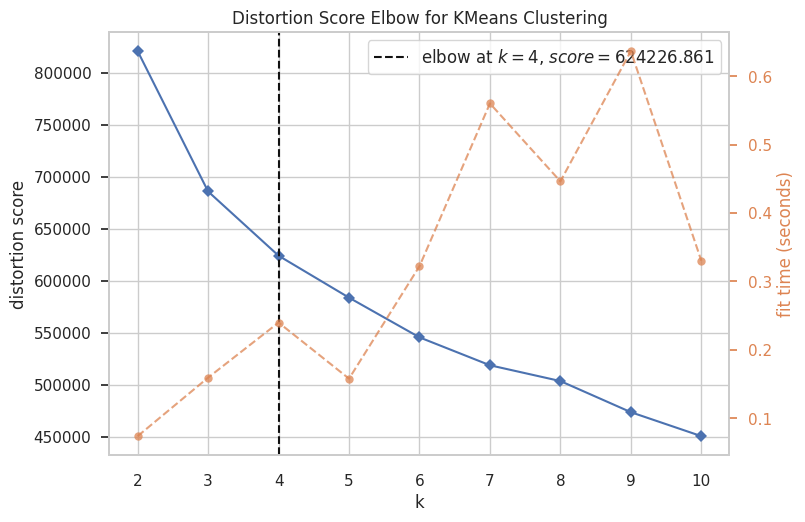

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=10, metric='distortion', random_state = 42)
Elbow_M.fit(data_scaled)
Elbow_M.show()

In [ ]:
k = 4  # optimal K
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)

# Get cluster labels for each customer
data_scaled['Cluster'] = kmeans.labels_

# View the cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print(cluster_centers)


        Age  NUMBER_OF_DEPENDANTS  CUSTOMER_INCOME  WORKING_IN_YEAR  \
0 -0.370124             -0.255788        -0.369884        -0.272928   
1  0.482523              0.324104         0.535113         0.420577   
2 -0.204456             -0.131474        -0.310264        -0.185667   
3  0.144043              0.092247         0.307734         0.076401   

   LOAN_AMOUNT  LOAN_TERM  TOTAL_EMI_AMOUNT  OUTSTANDING  NUMBERIC_DPD_BUCKET  \
0    -0.785369  -0.703083         -0.604899    -0.648536             0.976074   
1     0.993751   0.681709          0.889177     0.837033            -0.633149   
2    -0.524296  -0.305460         -0.515502    -0.616774            -0.693640   
3     0.578738   0.487825          0.498059     0.895494             1.484130   

   TOTAL_OVERDUE_PERIOD  OD_PAST_DUE  SCORE_BAND_NUMERIC  
0              0.873198     0.623023           -1.158528  
1             -0.486585    -0.569651            0.472944  
2             -0.637886    -0.598572            0.585035  
3 

## Visualization

<ipython-input-327-339cd2790b52>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Cluster', data=df_cluster,  palette="Pastel1")


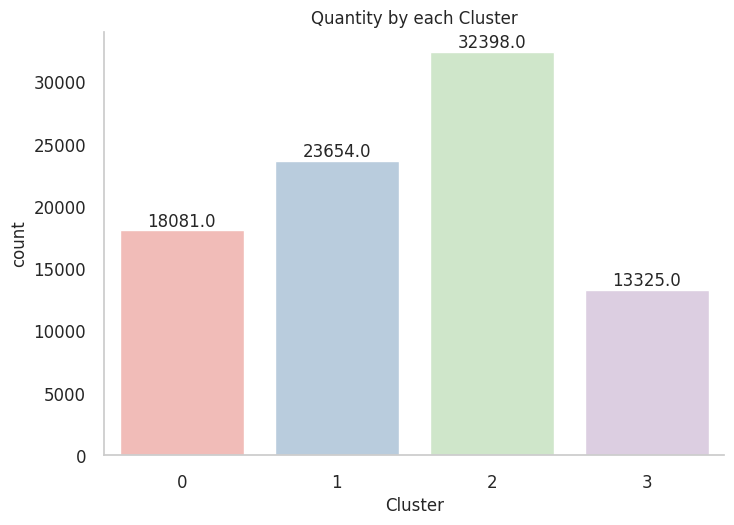

In [ ]:
df_cluster = df_kmeans.copy()

df_cluster['Cluster'] = kmeans.fit_predict(data_scaled)

ax = sns.countplot(x='Cluster', data=df_cluster,  palette="Pastel1")

# Access the patches
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{value}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.set_title('Quantity by each Cluster', size = 12)
ax.tick_params(labelsize = 12)
# Remove gridlines
sns.despine()  # Remove top and right spines
plt.grid(False)  # Remove gridlines

plt.show()

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


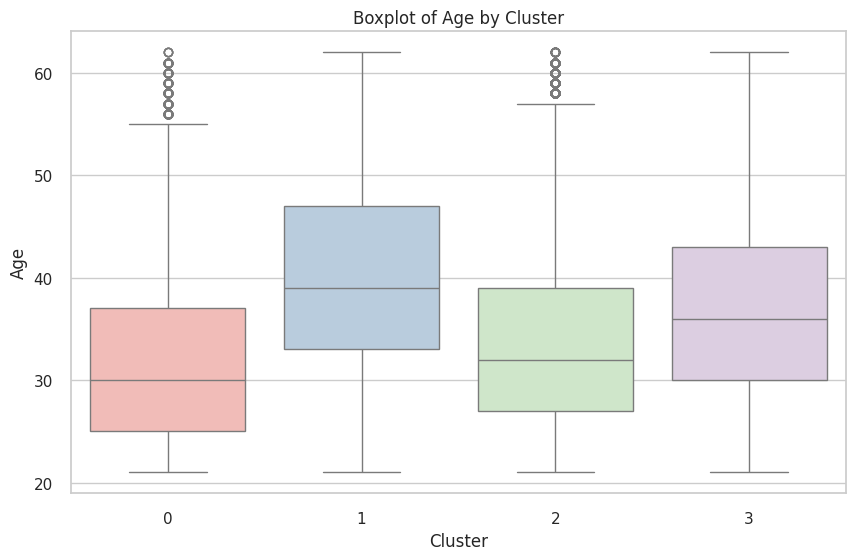

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


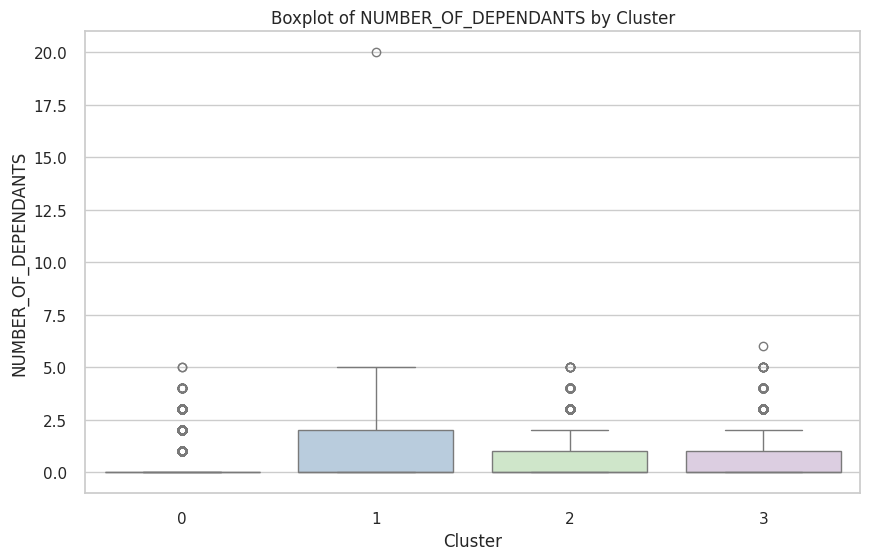

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


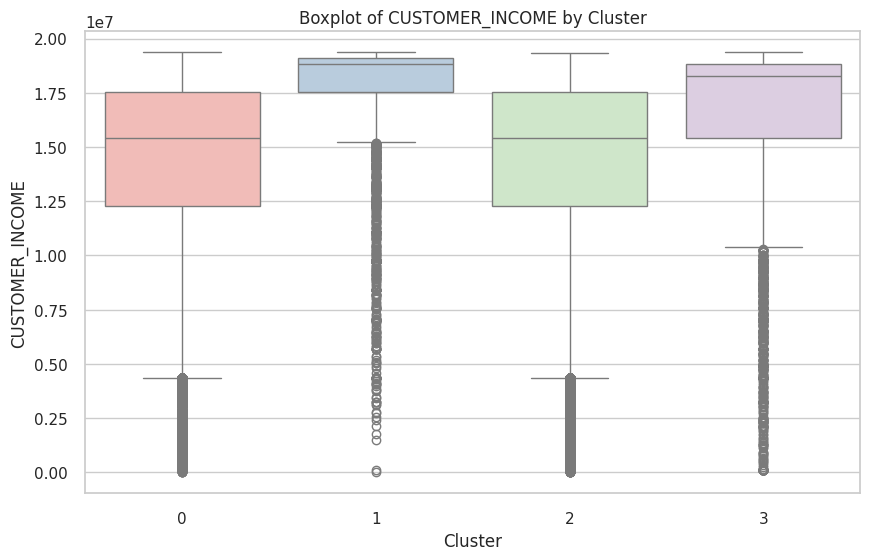

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


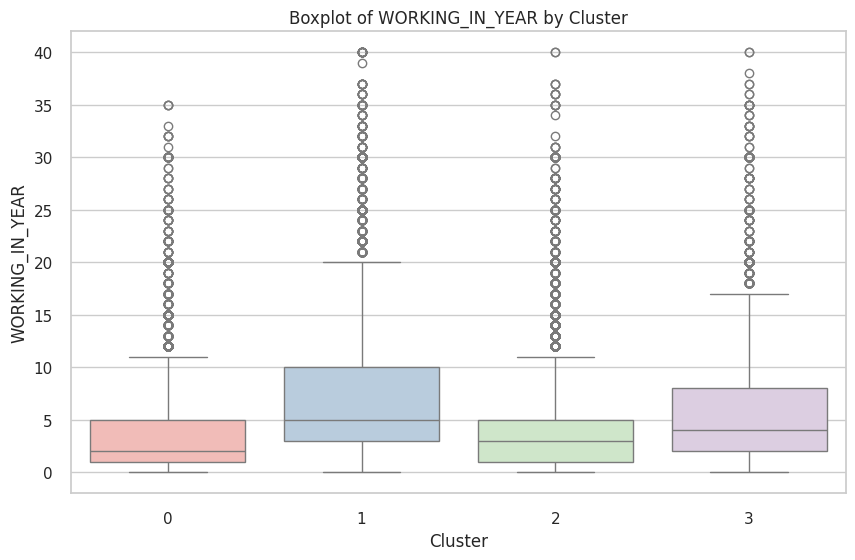

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


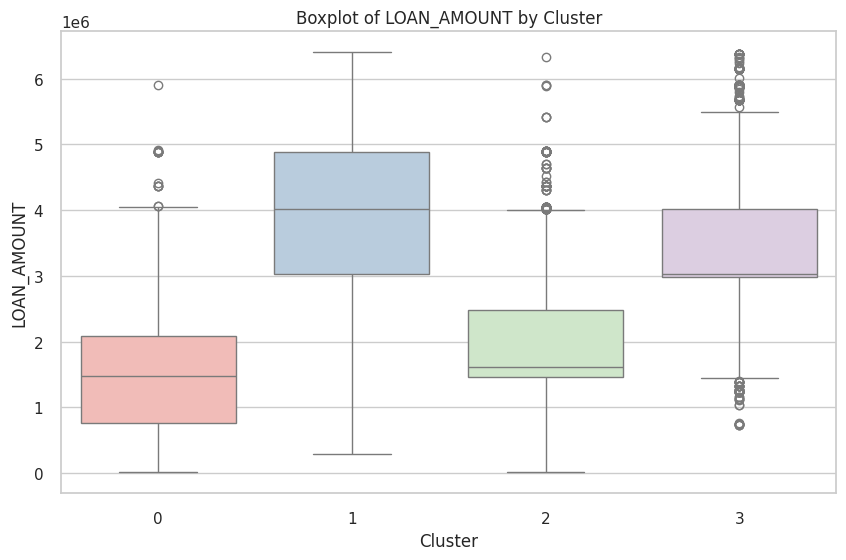

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


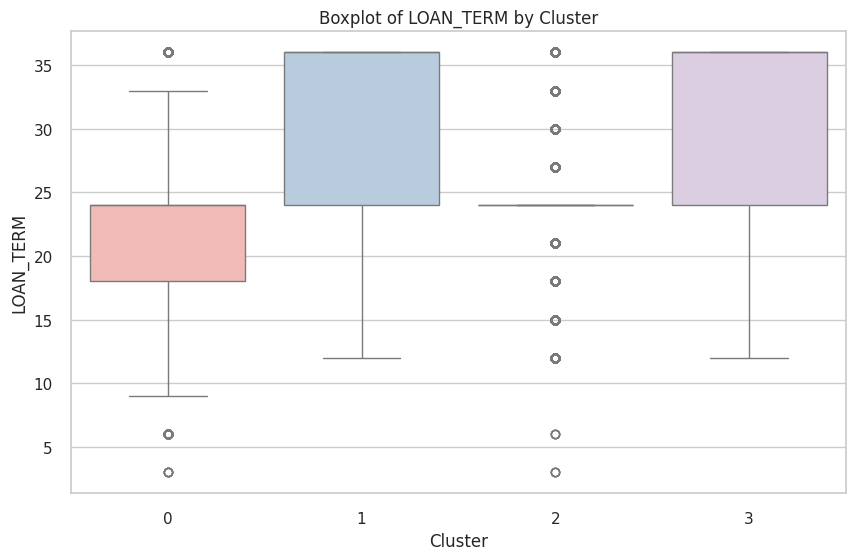

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


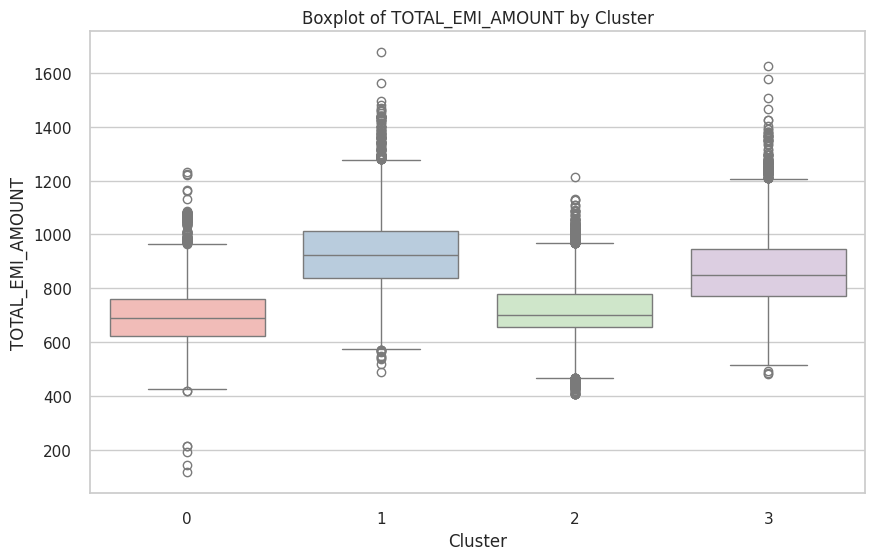

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


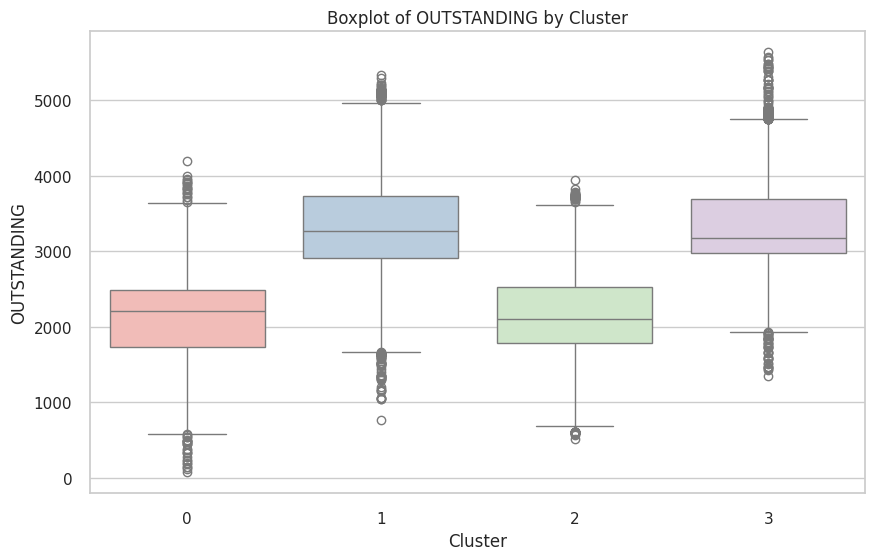

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


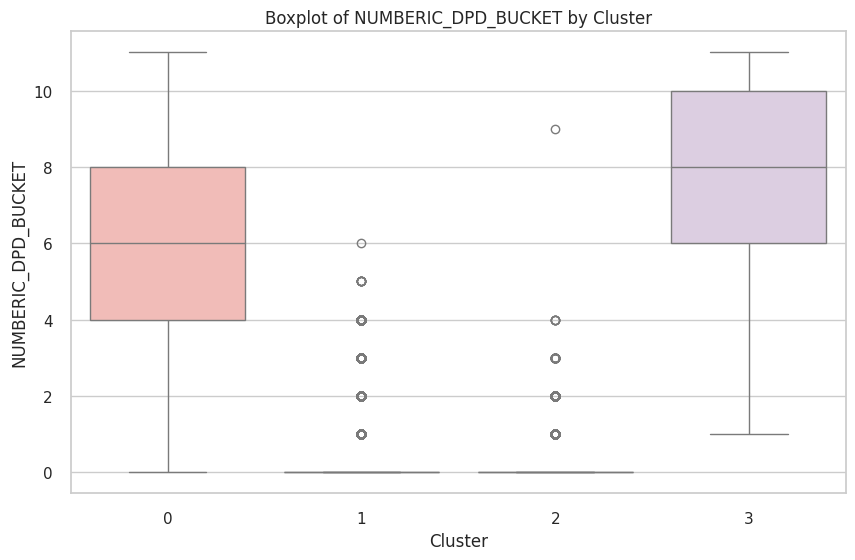

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


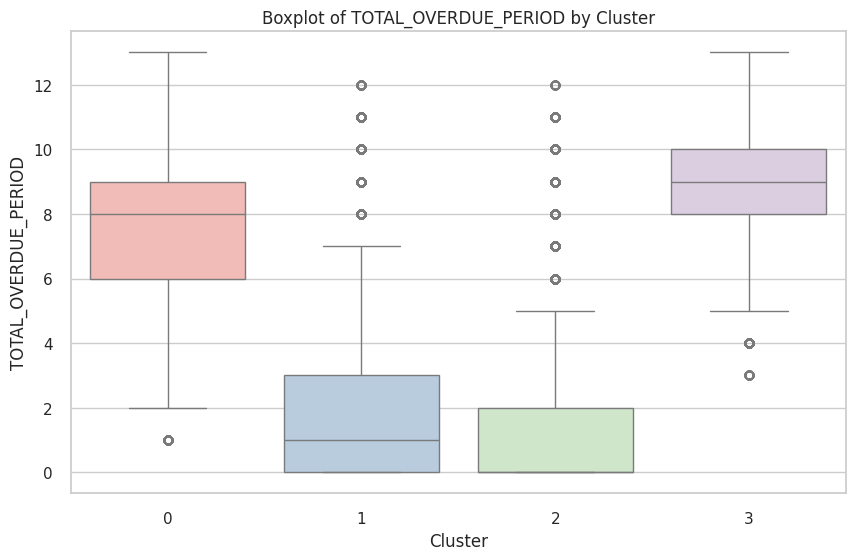

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


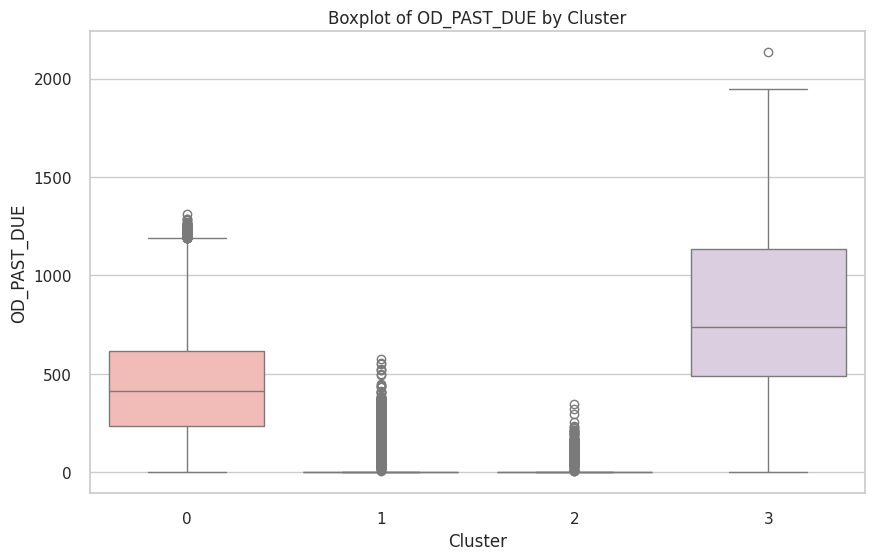

<ipython-input-328-e5854f77204d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")


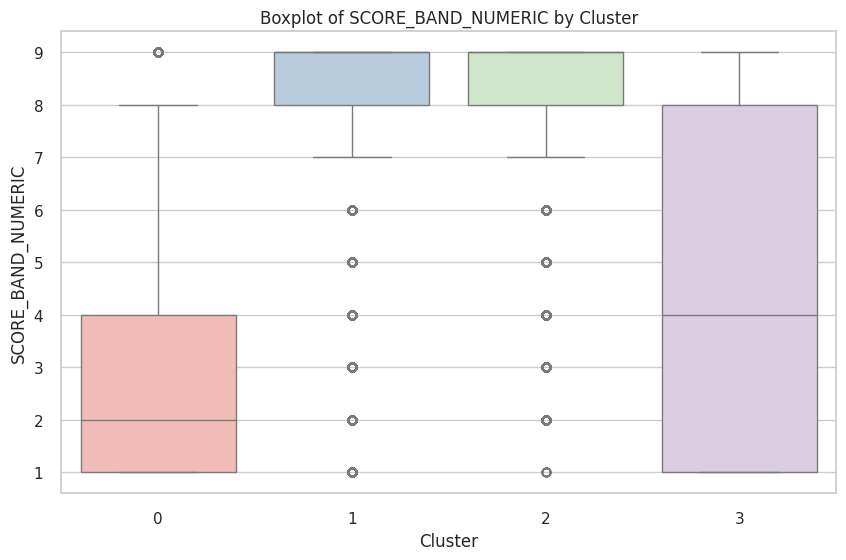

In [ ]:
# 1. Boxplot for each features by cluster
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=df_cluster, palette="Pastel1")
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.show()



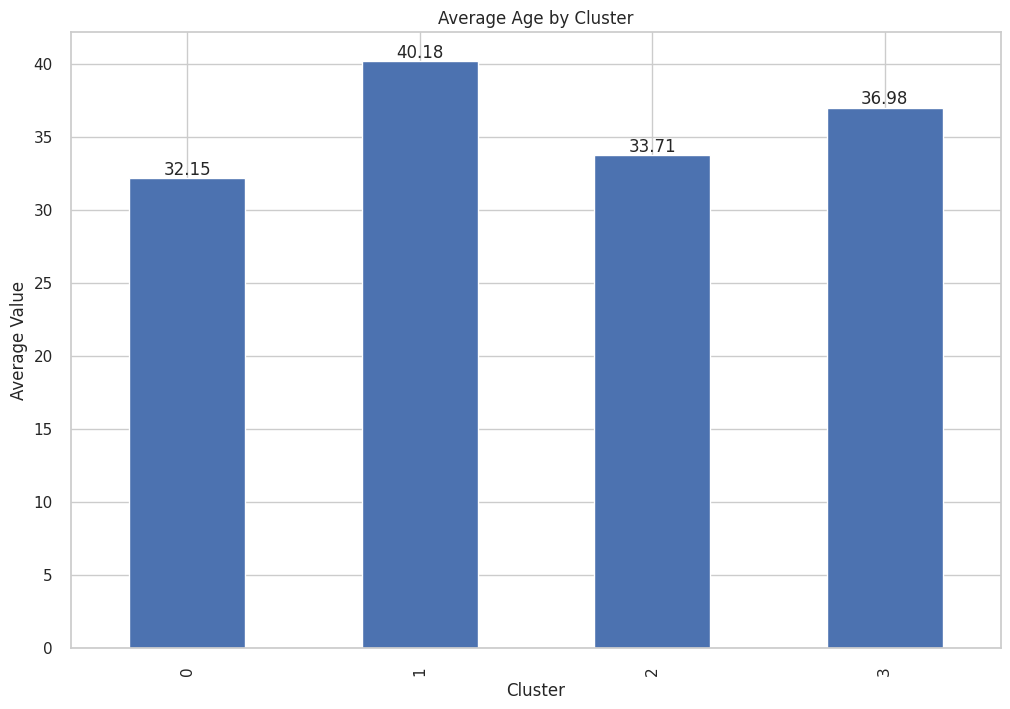

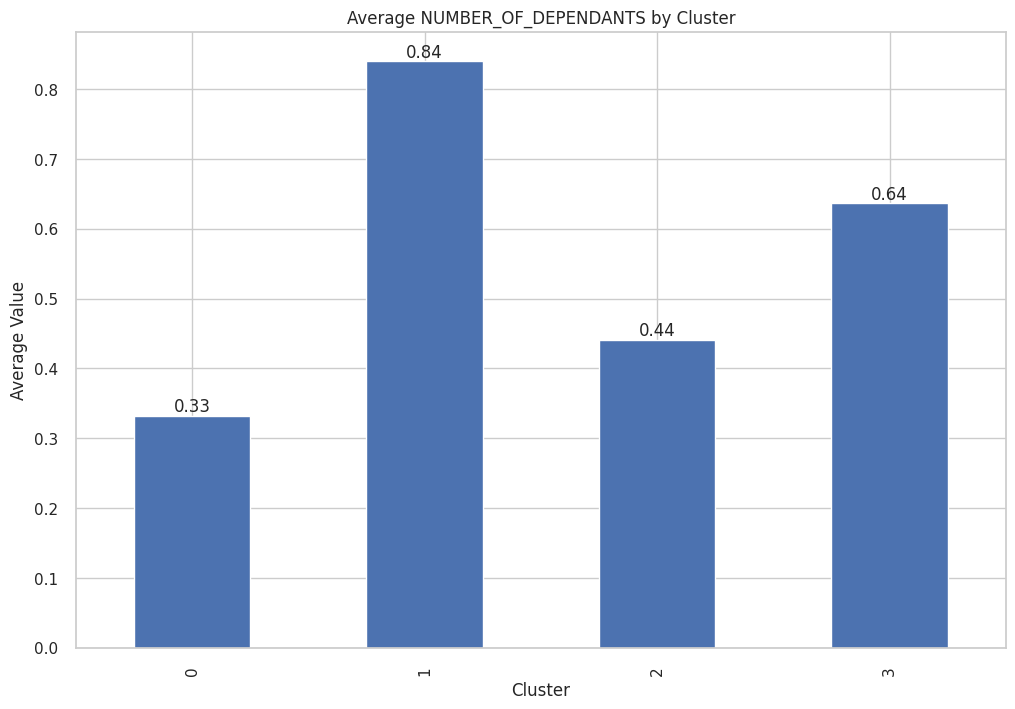

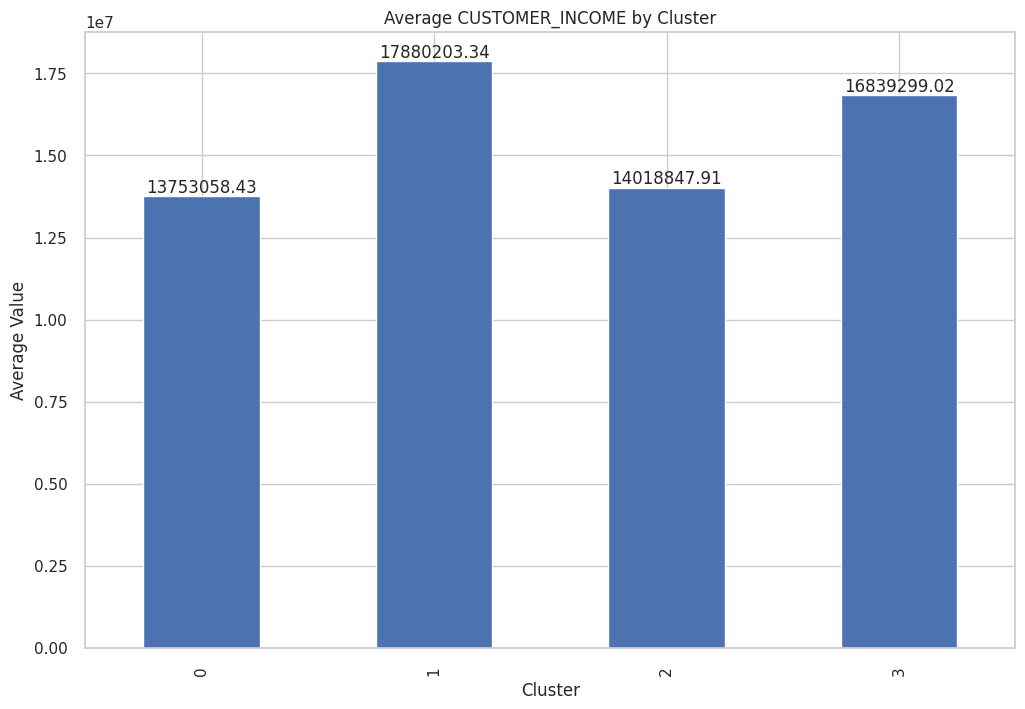

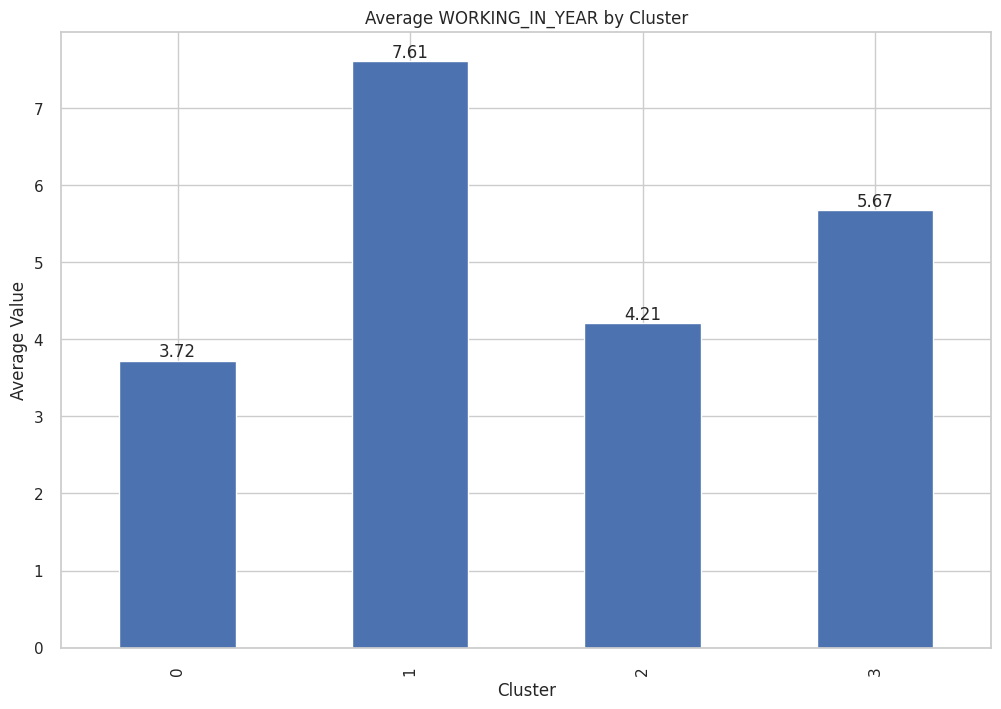

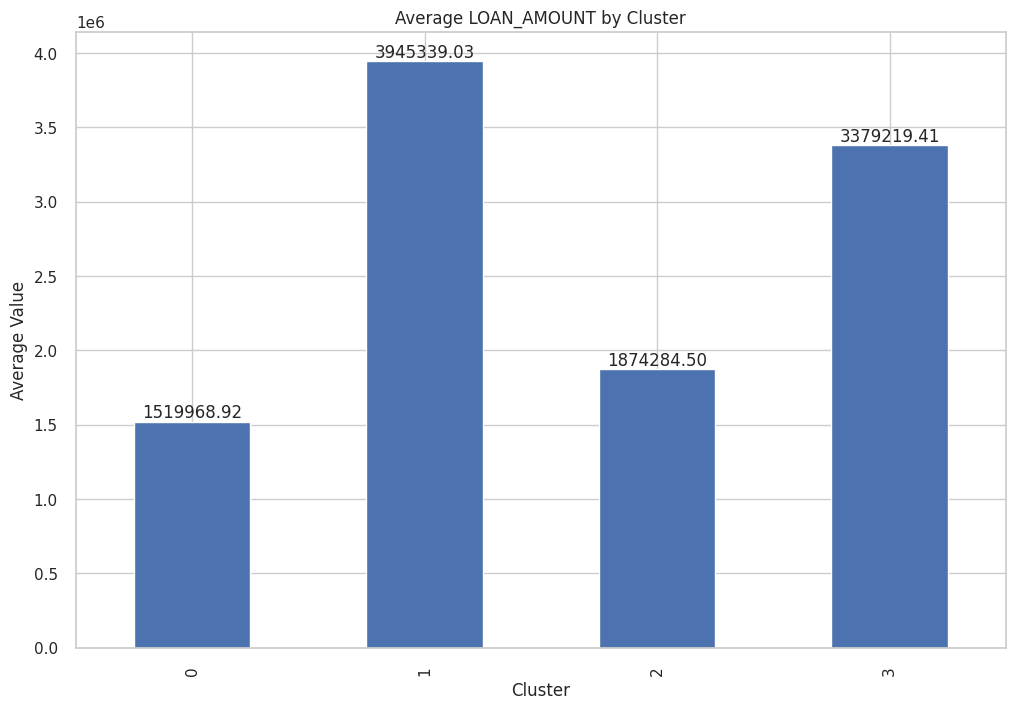

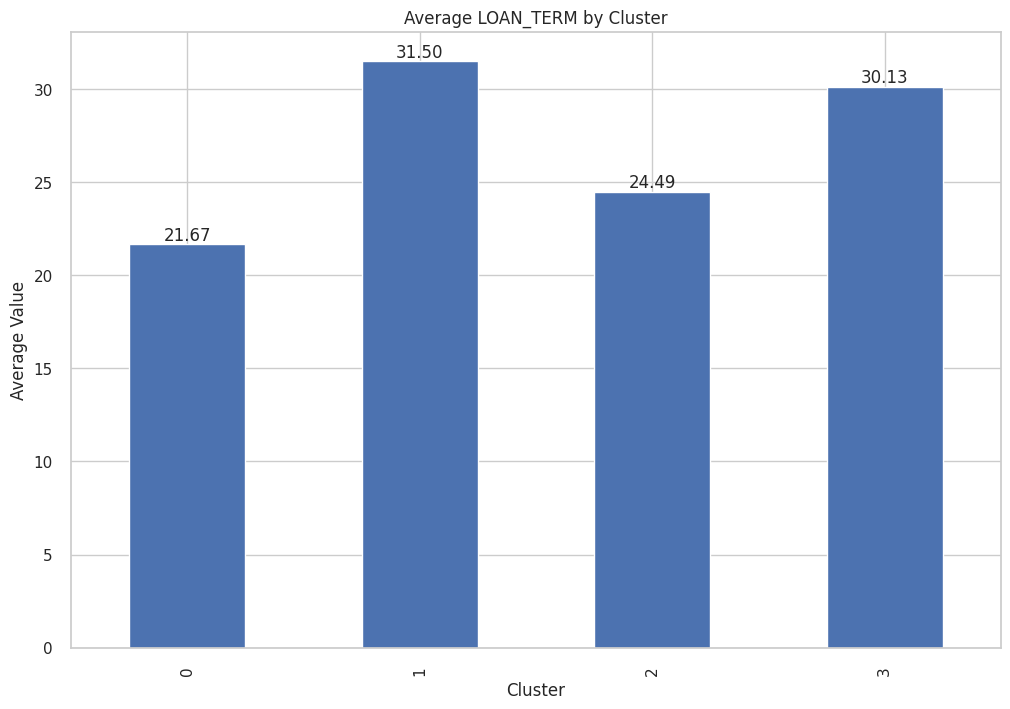

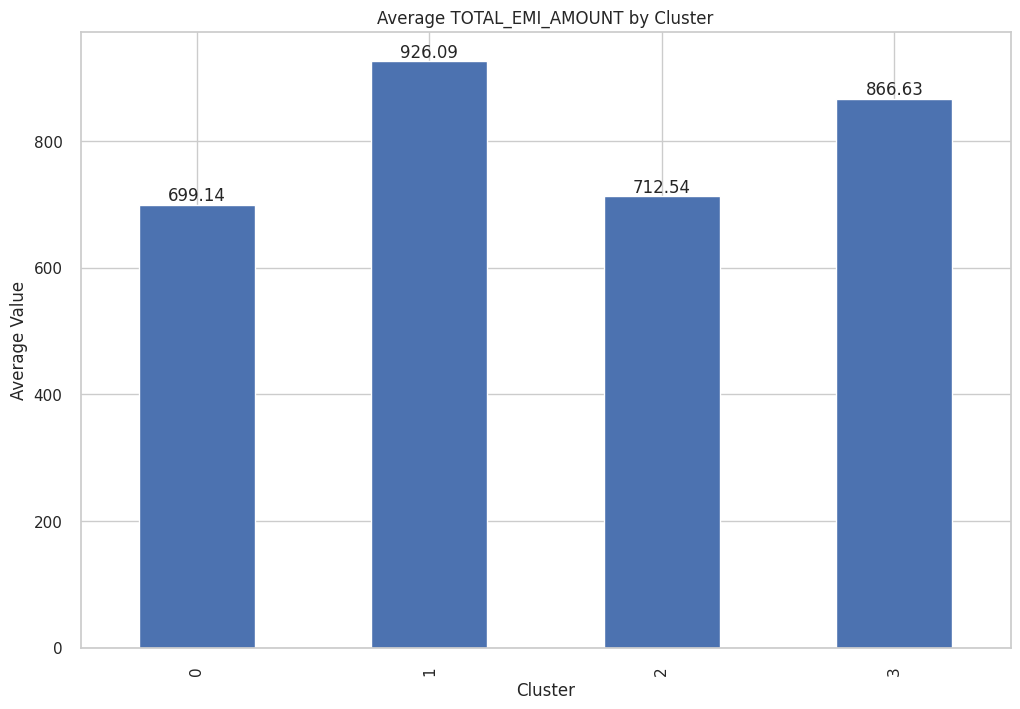

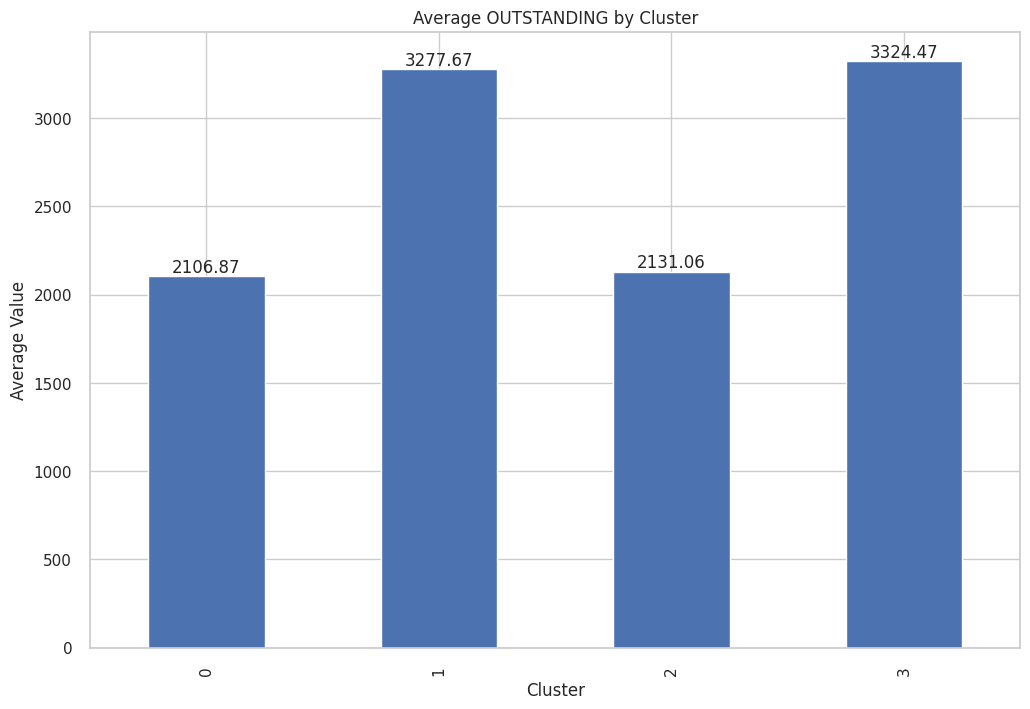

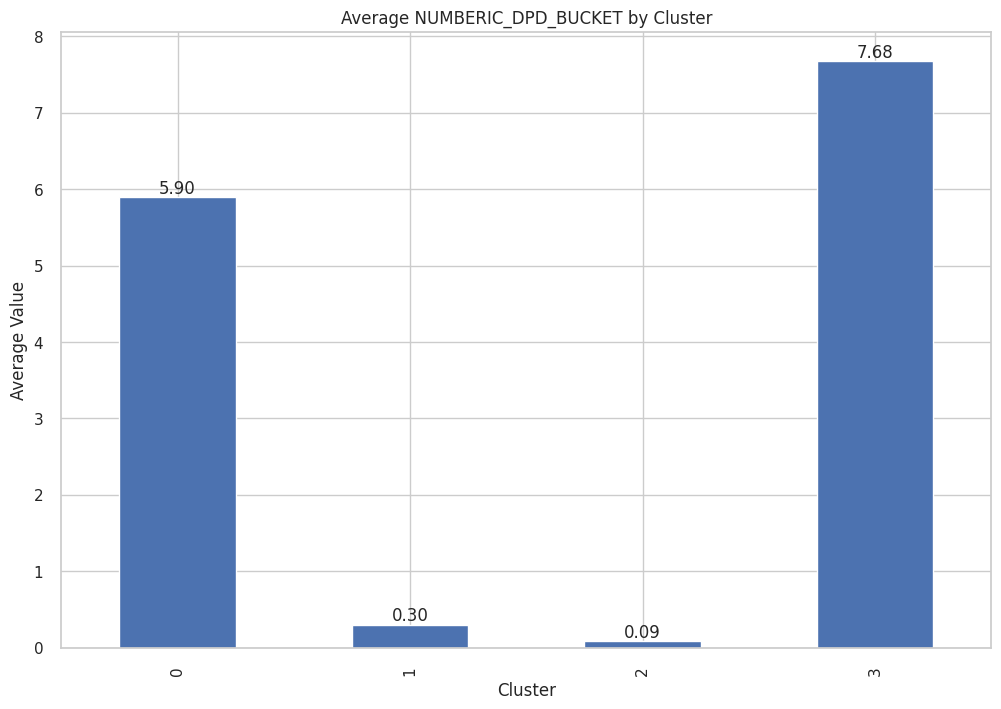

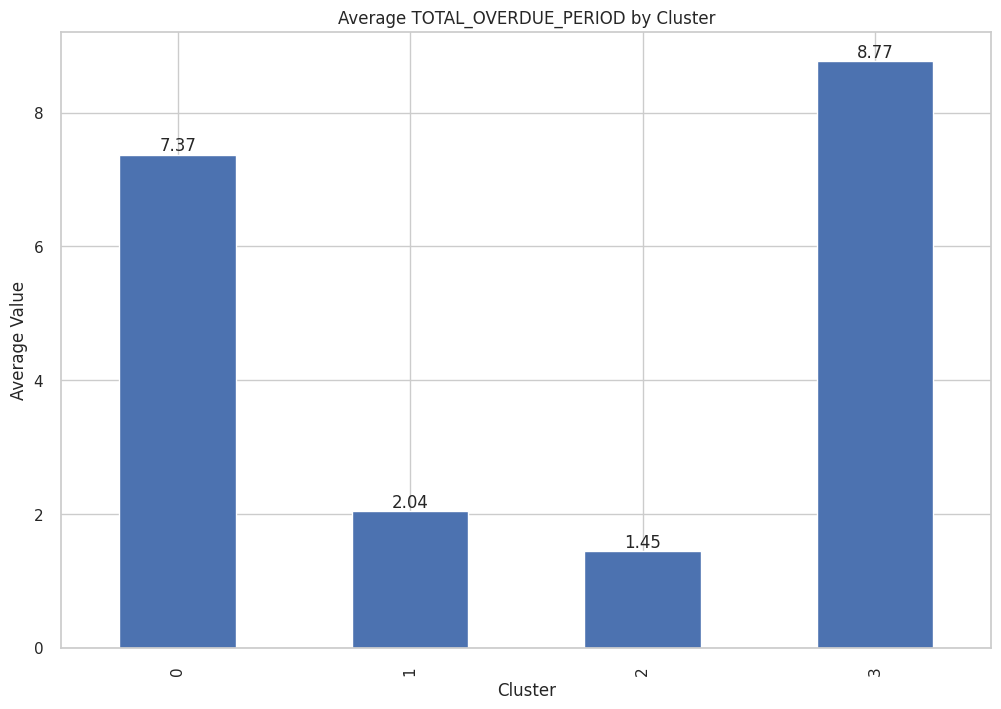

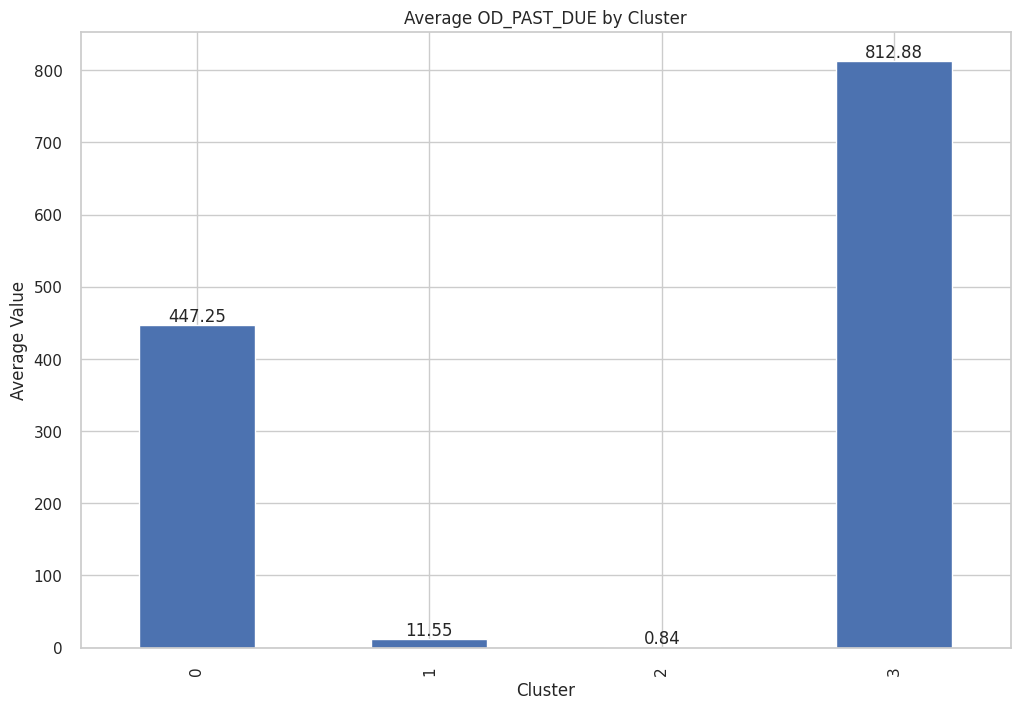

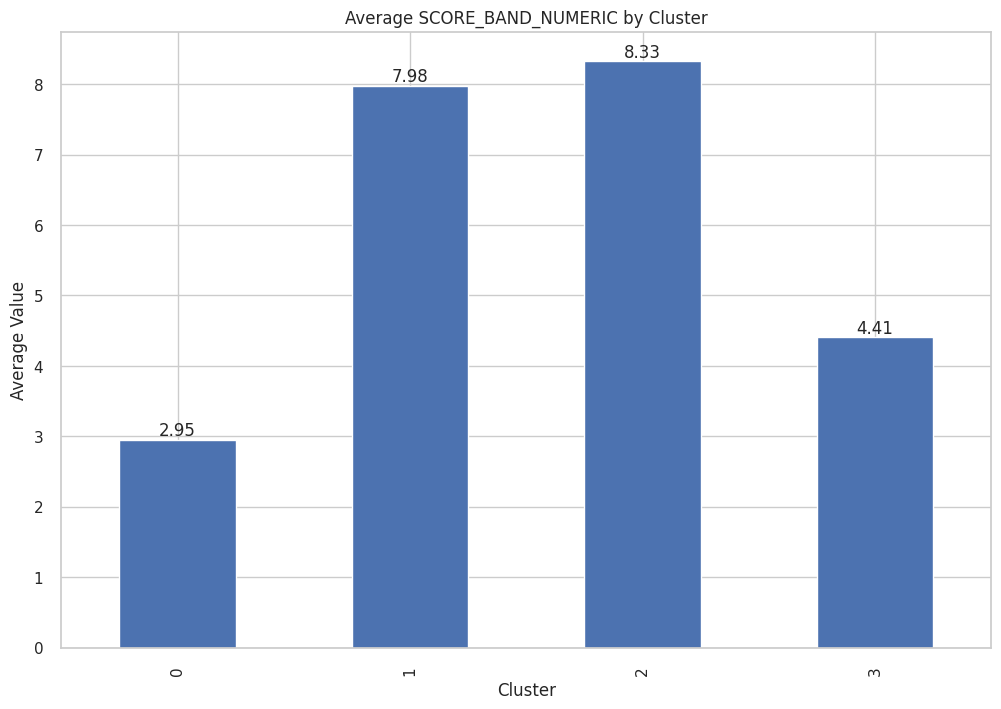

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot with data labels for each feature
for feature in features:
    # Calculate the mean values by cluster
    cluster_means = df_cluster.groupby('Cluster')[feature].mean()

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    ax = cluster_means.plot(kind='bar')
    plt.title(f'Average {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Value')

    # Add data labels to each bar
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f')  # Format the labels to 2 decimal places

    plt.show()


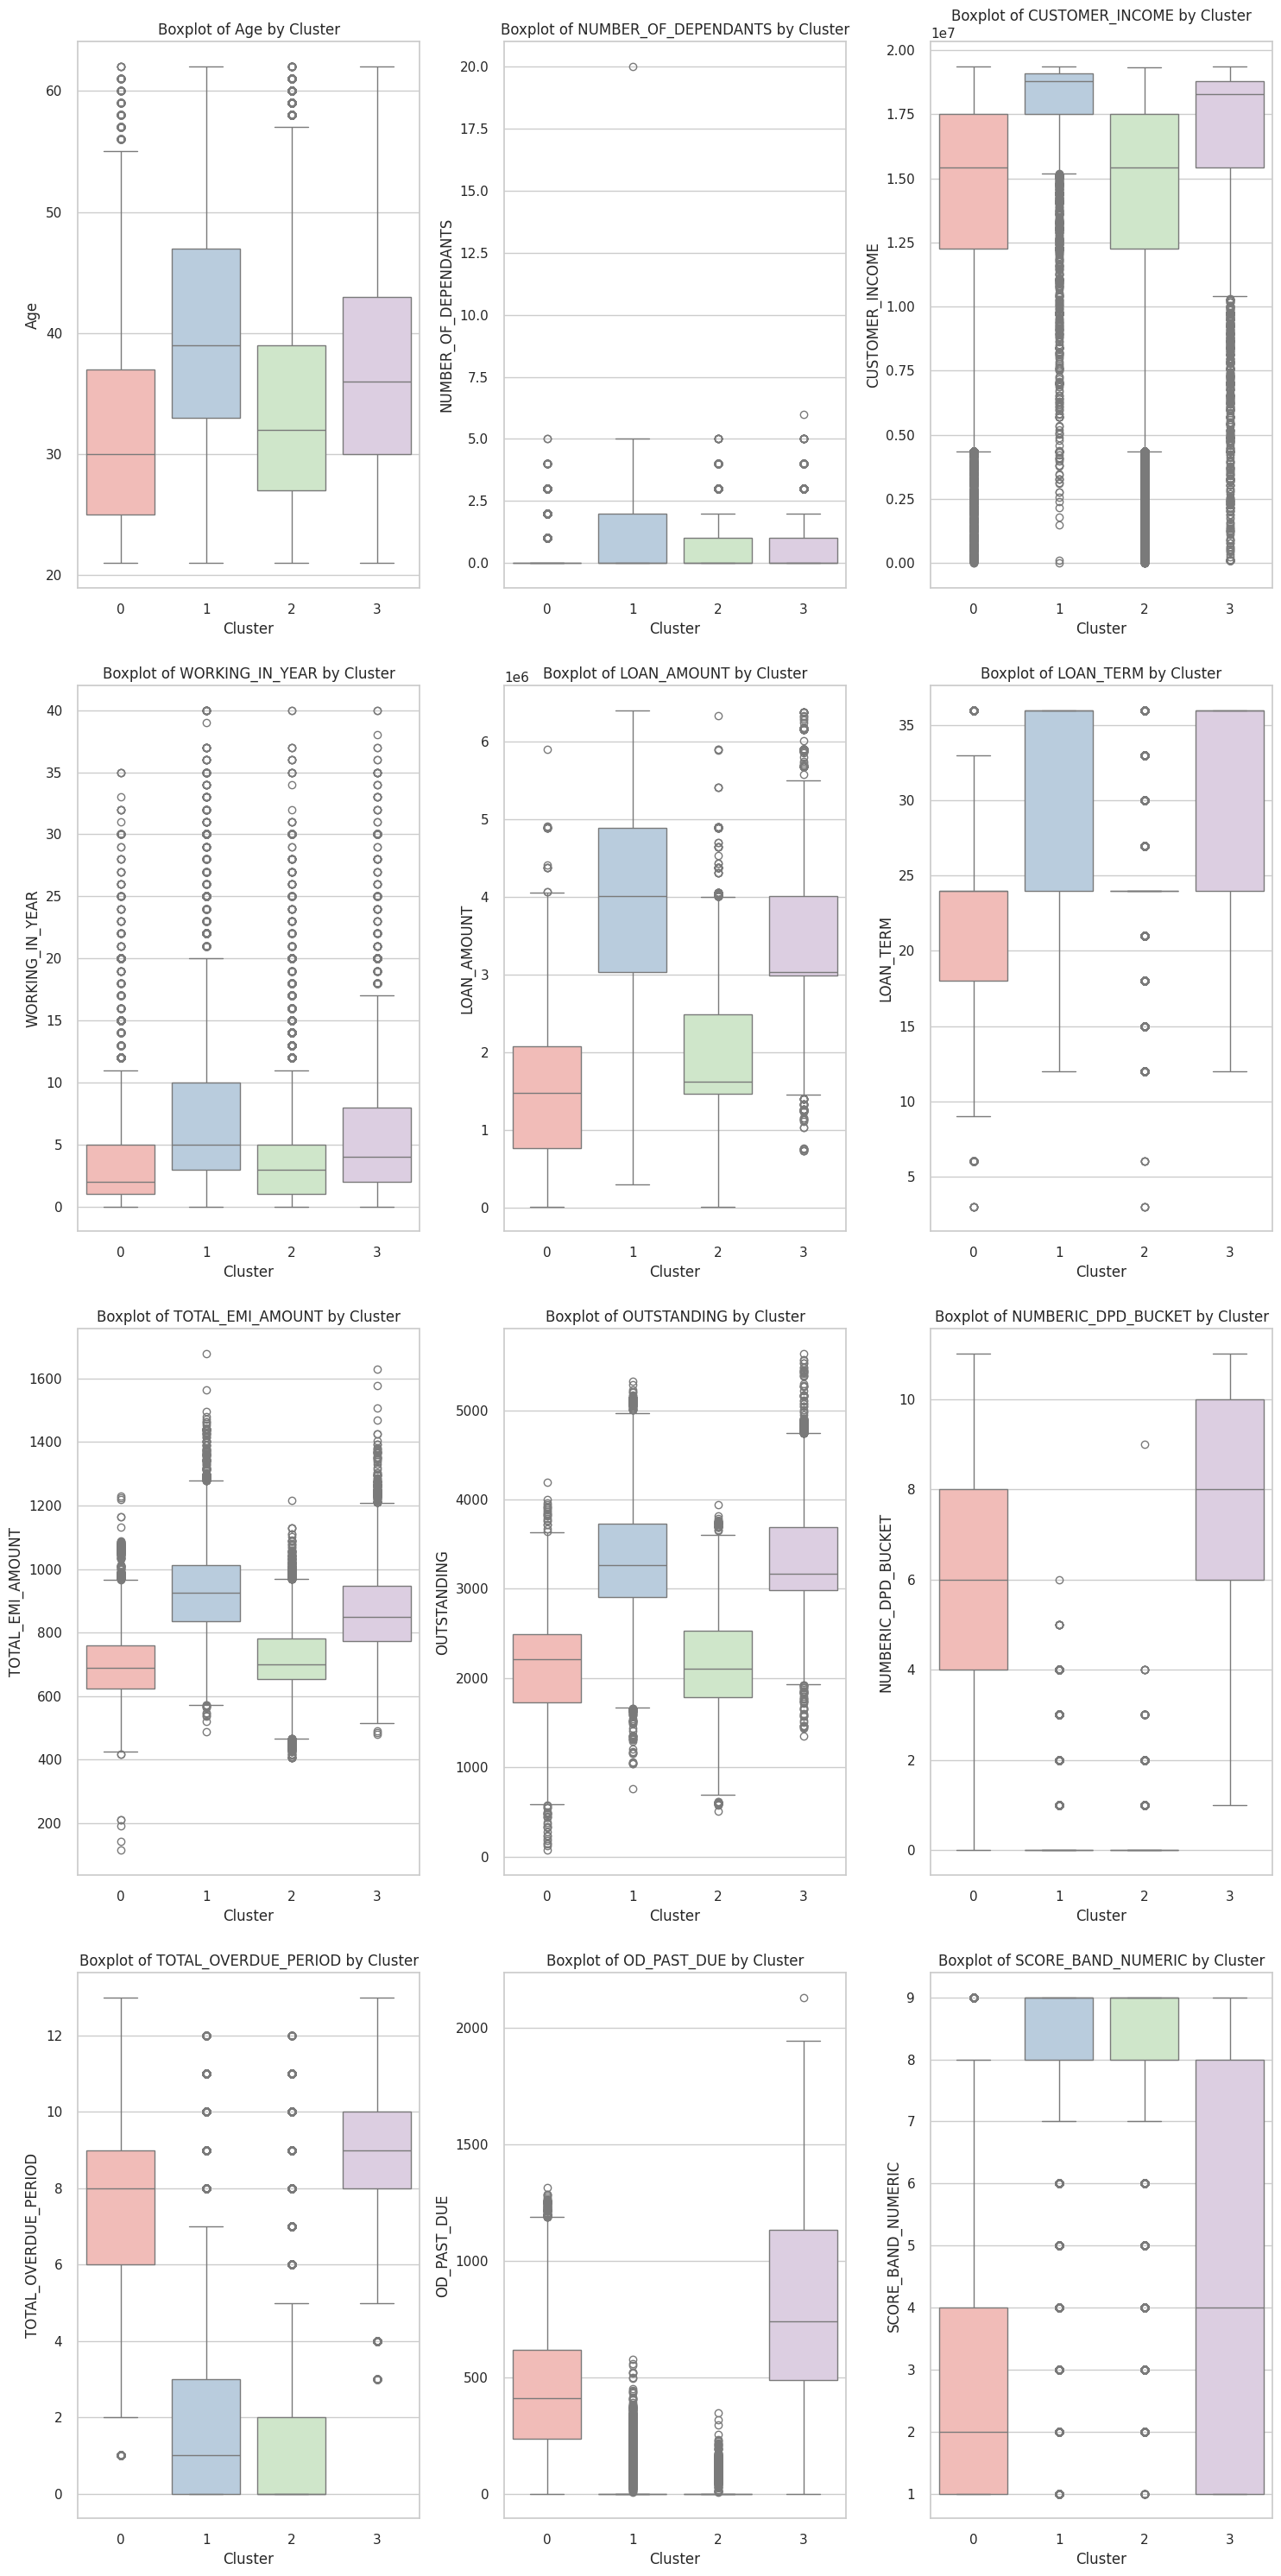

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of features
num_features = len(features)

# Create subplots with a grid layout (you can adjust rows and columns as needed)
fig, axes = plt.subplots(nrows=(num_features // 3) + (num_features % 3 > 0), ncols=3, figsize=(15, num_features * 2.5))

# Flatten the axes array for easier iteration if there are more features than axes
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=df_cluster, hue = 'Cluster', legend = False, palette="Pastel1", ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} by Cluster')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


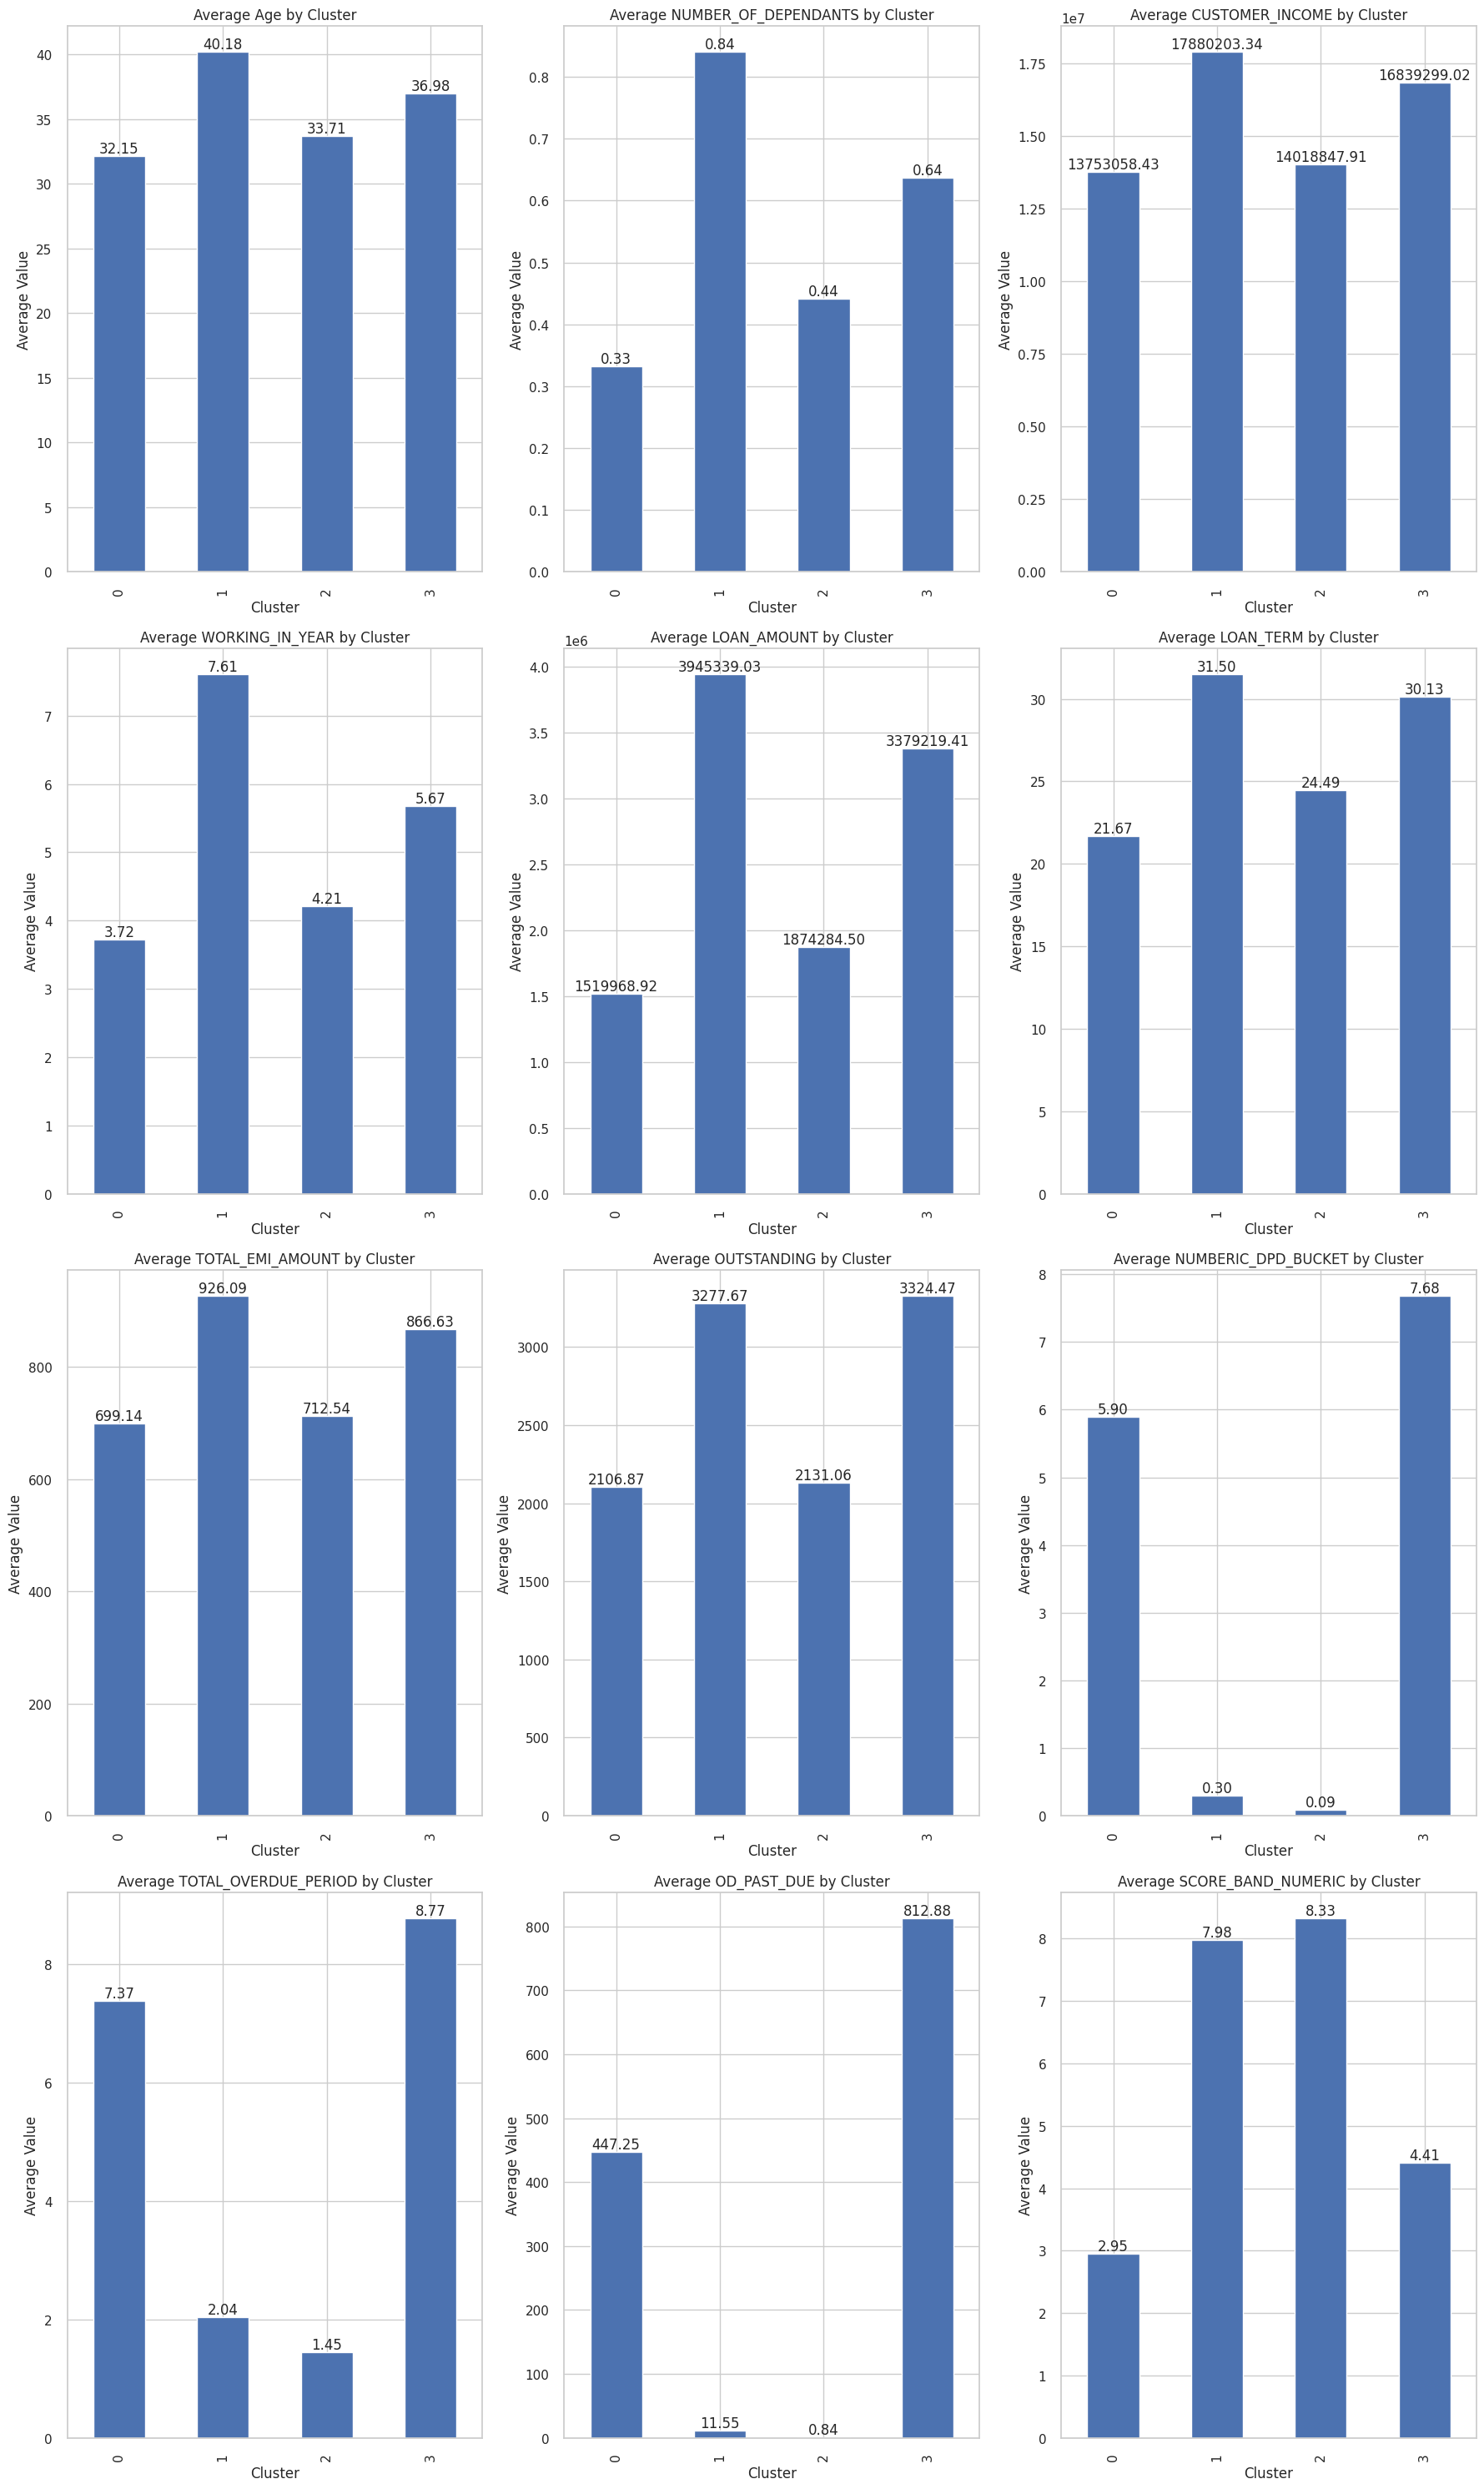

In [ ]:
import matplotlib.pyplot as plt

# Determine the number of features
num_features = len(features)

# Create subplots with a grid layout (adjust rows and columns as needed)
fig, axes = plt.subplots(nrows=(num_features // 3) + (num_features % 3 > 0), ncols=3, figsize=(18, num_features * 2.5))

# Flatten the axes array for easier iteration if there are more features than axes
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(features):
    # Calculate the mean values by cluster
    cluster_means = df_cluster.groupby('Cluster')[feature].mean()

    # Create the bar plot on the corresponding subplot axis
    ax = cluster_means.plot(kind='bar', ax=axes[i])
    ax.set_title(f'Average {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Value')

    # Add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')  # Format labels to 2 decimal places

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


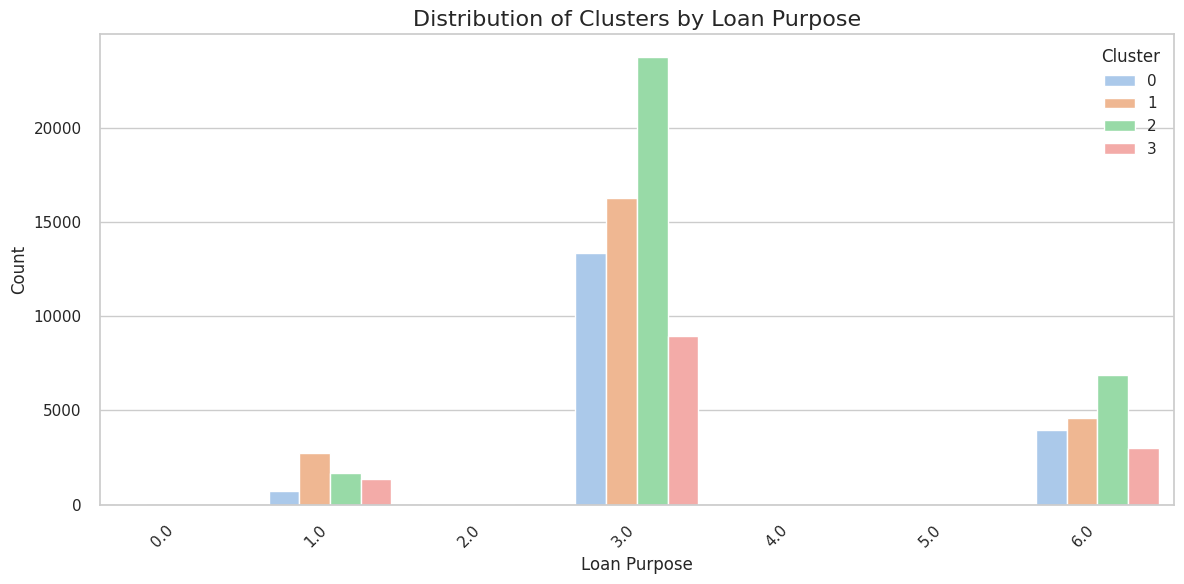

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the distribution of clusters with respect to LOAN_PURPOSE
sns.countplot(data=df_cluster, x='LOAN_PURPOSE', hue='Cluster', palette='pastel')

# Customize the plot
plt.title('Distribution of Clusters by Loan Purpose', fontsize=16)
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Cluster', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()
